## Figure 5 Code to Produce Figures

This figure will focus on the presentation of Motif Analysis.

In [151]:
# importing packages
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import pickle
import json
from tqdm import tqdm
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import squareform, pdist
from scipy import stats
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from difflib import diff_bytes
import seaborn as sns
import scipy
import networkx as nx
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (10,10)
sns.set_theme(style="whitegrid")

In [152]:
def invert_dict(original_dict):
    inverted_dict = {}
    for key, items in original_dict.items():
        for item in items:
            if item not in inverted_dict:
                inverted_dict[item] = [key]
            else:
                inverted_dict[item].append(key)
    return inverted_dict

### Developing Connectome Network Graph

In [3]:
### Insert Code from Sai involving Connectome Network

### Load in Data from LSMMData Wrangler

In [153]:
# Import Stefan's Library for Data Management of V1DD
from lsmm_data import LSMMData

with open('pyr_rectangular.json') as f:
    loaded_json = json.load(f)
v1dd_data_all_to_all = LSMMData.LSMMData(loaded_json)
tables = v1dd_data_all_to_all.data
params = v1dd_data_all_to_all.params
dirs = v1dd_data_all_to_all.dirs
mappings = v1dd_data_all_to_all.mappings

Generating Connectome...


100%|██████████| 4565/4565 [00:00<00:00, 16918.08it/s]


Generating Connectome...


100%|██████████| 4565/4565 [00:00<00:00, 12494.32it/s]


In [154]:
tables['structural'].keys()

dict_keys(['post_cell', 'pre_cell', 'synapse', 'synapse_count_connectome', 'binary_connectome', 'summed_size_connectome'])

In [155]:
binary_connectome = tables['structural']['binary_connectome']
synapse_count_connectome = tables['structural']['synapse_count_connectome']
summed_size_connectome = tables['structural']['summed_size_connectome']

# Initialize AS with the same shape as SC and SS
average_size_connectome = np.zeros_like(synapse_count_connectome, dtype=float)
average_size_connectome[synapse_count_connectome > 0] = summed_size_connectome[synapse_count_connectome > 0] / synapse_count_connectome[synapse_count_connectome > 0]

In [156]:
### Produce a dictionary for Assemblies by Coregistered
assemblies_by_coregistered = invert_dict(mappings['assemblies_by_connectome_index'])
# Produce Indexes for Assembly Cells and Non Assembly Cells
assembly_connectome_indexes = []
no_assembly_connectome_indexes = []
for key, val in mappings['assemblies_by_connectome_index'].items():
    if val == ['No A']:
        no_assembly_connectome_indexes.append(key)
    else:
        assembly_connectome_indexes.append(key)

In [157]:
# Grab Connectome with root ids, develop counts of first-order connections for assembly and no assembly set
assembly_first_order_connections = []
c_in_assembly = 0
non_assembly_first_order_connections = []
c_no_assembly = 0
for i in range(len(binary_connectome[0])):
    if i in assembly_connectome_indexes:
        c_in_assembly += 1
        assembly_first_order_connections.append(np.sum(binary_connectome[i,:]))
    elif i in no_assembly_connectome_indexes:
        c_no_assembly += 1
        non_assembly_first_order_connections.append(np.sum(binary_connectome[i,:]))

print("Number in Assembly Set:", c_in_assembly)
print("Number in No Assembly Set:", c_no_assembly)
print("Mean First-Order Binary Connections of Assembly Set:", np.mean(assembly_first_order_connections))
print("Mean First-Order Binary Connections of No Assembly Set:", np.mean(non_assembly_first_order_connections))

Number in Assembly Set: 43
Number in No Assembly Set: 12
Mean First-Order Binary Connections of Assembly Set: 10.279069767441861
Mean First-Order Binary Connections of No Assembly Set: 6.416666666666667


### First-Order Analysis with Binary Connectome

In [165]:
def produce_first_order_connections_plot(input_connections_dict: dict,
                                         total_cells : int,
                                         binary_counts: bool,
                                         syn_counts: bool, 
                                         directionality: str, 
                                         summed_psd : bool,
                                         average_psd: bool, 
                                         prob: bool, 
                                         intragroup: bool,
                                         grouped: bool,
                                         show_p_vals: bool, 
                                         fdr_correction: bool,
                                         save_fig = True):
    
    if binary_counts and syn_counts:
        raise ValueError("Must either be working with binary or synaptic count connectome.")
    if summed_psd and average_psd:
        raise ValueError("Must either be working with summed or average PSD values.")
    if (binary_counts or syn_counts) and (summed_psd or average_psd):
        raise ValueError("Must either be working with PSD or connectivity.")
    if (grouped and intragroup) and (not prob):
        raise ValueError("If inspecting grouped and intragroup, by default is already normalized. prob flag must be set to True.")
    
    # Based on the connectome flags, save it in the right folder, set the correct y_label and plot title
    if binary_counts:
        connectome_desc = "Binary"
        folder = "binary_connectome"
        suffix = f"{directionality} Binary Connectivity"
        y_lab = "Binary Connections"
    elif summed_psd:
        connectome_desc = "Summed_PSD"
        folder = "summed_size_connectome"
        suffix = f"{directionality} Post Syanptic Strength"
        y_lab = "Summed Synaptic Strength (PSD in nm^3)"
    elif average_psd: 
        connectome_desc = "Average_PSD"
        folder = "average_size_connectome"
        suffix = f"{directionality} Post Syanptic Strength"
        y_lab = "Average Synaptic Strength (PSD in nm^3)"
    elif syn_counts:
        connectome_desc = "SynCounts"
        folder = "synapse_count_connectome"
        suffix = f"{directionality} First-Order Connectivity"
        y_lab = "Synaptic Counts"
    else:
        raise ValueError("Must specify which connectome is being used.")

    connections_dict = {}
    # If Required, produce probability arrays of connections
    if prob:
        for key in input_connections_dict.keys():
            if grouped and intragroup: # this case has already been normalized when producing the connections dictionary
                print("Probability Already Normalized.")
                connections_dict[key] = np.array(input_connections_dict[key])
            elif intragroup: # adding a flag for intragroup, and divide by number of cells in group
                print("Producing Probability of Connections with count of cells in group")
                connections_dict[key] = np.array(input_connections_dict[key]) / (len(input_connections_dict[key]) - 1)
            else:
                print(f"Producing Probability of Connections with total cell count: {total_cells}")
                connections_dict[key] = np.array(input_connections_dict[key]) / (total_cells - 1)
    else:
        for key in input_connections_dict.keys():
            connections_dict[key] = np.array(input_connections_dict[key])

    prefix = 'Grouped ' if grouped else ""
    suffix = "Intragroup " + suffix if intragroup else suffix
    suffix = "Probability of " + suffix if prob and binary_counts else "Normalized " + suffix if prob else suffix
    y_lab = "Probability of " + y_lab if prob and binary_counts else "Normalized " + y_lab if prob else y_lab

    if not grouped:
        all_arr = [connections_dict['No A']]
        x_ticks = ["No A"]
        arr_medians = [np.median(np.array(connections_dict['No A']))]
        p_values = [np.nan]
        # Sort the dictionary keys
        sorted_keys = sorted(connections_dict.keys(), key=lambda s: (0, 0) if s == 'No A' else (1, int(s.split()[1])))
        for key in sorted_keys:
            if key != 'No A':
                if len(connections_dict[key]) < 5:
                    print(f"No Empirical Testing Performed. Assembly {key} has less than 5 coregistered cells.")
                    continue
                all_arr.append(connections_dict[key])
                x_ticks.append(key)
                arr_medians.append(np.median(np.array(connections_dict[key])))
                p_values.append(stats.ranksums(connections_dict[key], connections_dict['No A'], 'greater').pvalue)
        
        # Perform False Discoery Correction for our P-Values
        p_values = np.array(p_values)
        print(p_values)
        if fdr_correction:
            p_values[1:] = stats.false_discovery_control(p_values[1:], method = 'bh')
        for i, val in enumerate(p_values):
            p_values[i] = '{:.3g}'.format(val, 5) if i != 0 else p_values[i]
    else:
        all_arr = [connections_dict['No A'], connections_dict['All A']]
        x_ticks = ["No A", 'All A']
        arr_medians = [np.median(np.array(connections_dict['No A'])), np.median(np.array(connections_dict['All A']))]
        val = stats.ranksums(connections_dict['All A'], connections_dict['No A'], 'greater').pvalue
        p_values = [np.nan, '{:.3g}'.format(val, 5)]

    # Define Colors based on Signfiicance
    colors = ['lightgrey' if float(p_val) >= 0.05 or np.isnan(float(p_val)) else (.4, .6, .8, .5) for p_val in p_values]

    # Create a figure with specific size
    _, ax = plt.subplots(figsize=(12, 8))  # Width = 12 inches, Height = 6 inches

    sns.set_theme(style="whitegrid")
    sns.boxplot(data=all_arr,
                    notch= False, showcaps=True,
                    flierprops={"marker": "x"},
                    medianprops={"color": "coral"},
                    palette= colors,
                    ax = ax
                )
    ax.set_xticklabels(x_ticks, size = 14)
    ax.set_title(f'{prefix}Assembly Cell Involvement: {suffix}', size = 16)
    ax.set_ylabel(y_lab, size = 14)
    plt.xticks(rotation=45)

    # Create legend
    custom_legend = [plt.Line2D([0], [0], color='lightgrey', lw=7, label='No Significant Difference from No A'),
                    plt.Line2D([0], [0], color=(.4, .6, .8, .5), lw=7, label='Significant Difference from No A')]
    plt.legend(handles=custom_legend, loc='best')

    # If you want to print P-Values, place them on the plot above the median

    if show_p_vals:
        medians = np.array(arr_medians)
        vertical_offset = medians * 0.005 # offset from median for display
            
        for xtick in ax.get_xticks():
            if xtick != 0:
                ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick],  # type: ignore
                        horizontalalignment='center', fontsize=10, color='black', weight='semibold')

    desc = "Grouped" if grouped else "All"
    fig_title = f"{directionality}_{connectome_desc}_First_Order_{desc}_Assemblies_Boxplot.png"
    fig_title = "Intragroup_" + fig_title if intragroup else fig_title
    fig_title = "Normalized_" + fig_title if prob else fig_title
    
    if save_fig:
        plt.savefig(f'pyr_only_results/{folder}/{fig_title}', dpi = 1200)
    plt.tight_layout()
    plt.show()

In [159]:
### Produce Plot for each assembly
coregistered_cell_indexes = mappings['assemblies_by_connectome_index'].keys()
no_a_cell_indexes = mappings['connectome_indexes_by_assembly']['No A']

In [160]:
# Produce Counts for Inbound and Outbound Connections
outbound_binary_first_order_connections = {}
inbound_binary_first_order_connections = {}
outbound_binary_intragroup_first_order_connections = {}
inbound_binary_intragroup_first_order_connections = {}

for A in assemblies_by_coregistered.keys():
    if len(assemblies_by_coregistered[A]) >= 5:
        outbound_binary_first_order_connections[A] = []
        inbound_binary_first_order_connections[A] = []
        outbound_binary_intragroup_first_order_connections[A] = []
        inbound_binary_intragroup_first_order_connections[A] = []
        for c_index in assemblies_by_coregistered[A]:
            outbound_binary_first_order_connections[A].append(np.sum(binary_connectome[c_index,:]))
            inbound_binary_first_order_connections[A].append(np.sum(binary_connectome[:,c_index]))
            outbound_binary_intragroup_first_order_connections[A].append(np.sum(binary_connectome[c_index,assemblies_by_coregistered[A]]))
            inbound_binary_intragroup_first_order_connections[A].append(np.sum(binary_connectome[assemblies_by_coregistered[A],c_index]))

print("Outbound Binary: ", outbound_binary_first_order_connections)
print("Inbound Binary: ", inbound_binary_first_order_connections)
print("Outbound Binary Intragroup: ", outbound_binary_intragroup_first_order_connections)
print("Inbound Binary Intragroup: ", inbound_binary_intragroup_first_order_connections)

Outbound Binary:  {'A 1': [16.0, 11.0, 7.0, 11.0, 4.0, 8.0, 12.0, 7.0, 16.0, 27.0, 7.0, 6.0, 2.0, 2.0, 6.0, 10.0, 6.0, 8.0, 29.0, 10.0, 10.0], 'A 3': [11.0, 4.0, 27.0, 6.0, 2.0, 8.0, 10.0, 5.0, 10.0, 4.0], 'A 4': [11.0, 12.0, 7.0, 10.0, 8.0, 4.0, 28.0, 8.0, 4.0, 22.0], 'A 5': [11.0, 11.0, 6.0, 4.0, 4.0, 22.0, 6.0, 9.0], 'A 7': [11.0, 11.0, 12.0, 7.0, 10.0, 4.0, 22.0, 6.0], 'A 8': [11.0, 12.0, 7.0, 16.0, 10.0, 10.0, 4.0, 22.0], 'A 10': [11.0, 10.0, 24.0, 11.0, 3.0], 'A 2': [16.0, 2.0, 29.0, 6.0, 7.0, 8.0, 10.0, 4.0, 24.0], 'No A': [4.0, 7.0, 8.0, 8.0, 9.0, 7.0, 7.0, 9.0, 5.0, 2.0, 4.0, 7.0]}
Inbound Binary:  {'A 1': [15.0, 2.0, 14.0, 11.0, 18.0, 8.0, 5.0, 11.0, 13.0, 16.0, 7.0, 12.0, 12.0, 6.0, 5.0, 6.0, 14.0, 6.0, 1.0, 5.0, 7.0], 'A 3': [2.0, 18.0, 16.0, 12.0, 12.0, 6.0, 7.0, 16.0, 1.0, 2.0], 'A 4': [2.0, 5.0, 11.0, 6.0, 6.0, 7.0, 16.0, 4.0, 6.0, 2.0], 'A 5': [2.0, 11.0, 12.0, 7.0, 6.0, 2.0, 10.0, 7.0], 'A 7': [2.0, 11.0, 5.0, 11.0, 1.0, 6.0, 2.0, 10.0], 'A 8': [2.0, 5.0, 11.0, 13.0, 7

In [12]:
# Produce Grouped Counts for Inbound and Outbound Connections
grouped_outbound_binary_first_order_connections = {'No A': [], "All A": []}
grouped_inbound_binary_first_order_connections = {'No A': [], "All A": []}
grouped_intragroup_outbound_binary_first_order_connections = {'No A': [], "All A": []}
grouped_intragroup_inbound_binary_first_order_connections = {'No A': [], "All A": []}

for A in assemblies_by_coregistered.keys():
    if len(assemblies_by_coregistered[A]) >= 5:
        for c_index in assemblies_by_coregistered[A]:
            if A == 'No A':
                grouped_outbound_binary_first_order_connections['No A'].append(np.sum(binary_connectome[c_index,:]))
                grouped_inbound_binary_first_order_connections['No A'].append(np.sum(binary_connectome[:,c_index]))
                # Will normalize already by all possible connections in group
                grouped_intragroup_outbound_binary_first_order_connections['No A'].append(np.sum(binary_connectome[c_index,assemblies_by_coregistered[A]]) / (len(assemblies_by_coregistered[A]) - 1))
                grouped_intragroup_inbound_binary_first_order_connections['No A'].append(np.sum(binary_connectome[assemblies_by_coregistered[A],c_index]) / (len(assemblies_by_coregistered[A]) - 1))
            else:
                grouped_outbound_binary_first_order_connections['All A'].append(np.sum(binary_connectome[c_index,:]))
                grouped_inbound_binary_first_order_connections['All A'].append(np.sum(binary_connectome[:,c_index]))
                # Will normalize already by all possible connections in group
                grouped_intragroup_outbound_binary_first_order_connections['All A'].append(np.sum(binary_connectome[c_index,assemblies_by_coregistered[A]]) / (len(assemblies_by_coregistered[A]) - 1))
                grouped_intragroup_inbound_binary_first_order_connections['All A'].append(np.sum(binary_connectome[assemblies_by_coregistered[A],c_index]) / (len(assemblies_by_coregistered[A]) - 1))

print("Grouped Outbound Binary: ", grouped_outbound_binary_first_order_connections)
print("Grouped Inbound Binary: ", grouped_inbound_binary_first_order_connections)
print("Grouped Outbound Binary Intragroup: ", grouped_intragroup_outbound_binary_first_order_connections)
print("Grouped Inbound Binary Intragroup: ", grouped_intragroup_inbound_binary_first_order_connections)

Grouped Outbound Binary:  {'No A': [4.0, 7.0, 8.0, 8.0, 9.0, 7.0, 7.0, 9.0, 5.0, 2.0, 4.0, 7.0], 'All A': [16.0, 11.0, 7.0, 11.0, 4.0, 8.0, 12.0, 7.0, 16.0, 27.0, 7.0, 6.0, 2.0, 2.0, 6.0, 10.0, 6.0, 8.0, 29.0, 10.0, 10.0, 11.0, 4.0, 27.0, 6.0, 2.0, 8.0, 10.0, 5.0, 10.0, 4.0, 11.0, 12.0, 7.0, 10.0, 8.0, 4.0, 28.0, 8.0, 4.0, 22.0, 11.0, 11.0, 6.0, 4.0, 4.0, 22.0, 6.0, 9.0, 11.0, 11.0, 12.0, 7.0, 10.0, 4.0, 22.0, 6.0, 11.0, 12.0, 7.0, 16.0, 10.0, 10.0, 4.0, 22.0, 11.0, 10.0, 24.0, 11.0, 3.0, 16.0, 2.0, 29.0, 6.0, 7.0, 8.0, 10.0, 4.0, 24.0]}
Grouped Inbound Binary:  {'No A': [5.0, 13.0, 10.0, 6.0, 2.0, 17.0, 9.0, 4.0, 6.0, 6.0, 6.0, 4.0], 'All A': [15.0, 2.0, 14.0, 11.0, 18.0, 8.0, 5.0, 11.0, 13.0, 16.0, 7.0, 12.0, 12.0, 6.0, 5.0, 6.0, 14.0, 6.0, 1.0, 5.0, 7.0, 2.0, 18.0, 16.0, 12.0, 12.0, 6.0, 7.0, 16.0, 1.0, 2.0, 2.0, 5.0, 11.0, 6.0, 6.0, 7.0, 16.0, 4.0, 6.0, 2.0, 2.0, 11.0, 12.0, 7.0, 6.0, 2.0, 10.0, 7.0, 2.0, 11.0, 5.0, 11.0, 1.0, 6.0, 2.0, 10.0, 2.0, 5.0, 11.0, 13.0, 7.0, 1.0, 6.0, 2.

[       nan 0.04608285 0.1353315  0.27644255 0.03242684 0.19803291
 0.03203875 0.00677733 0.02260068]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


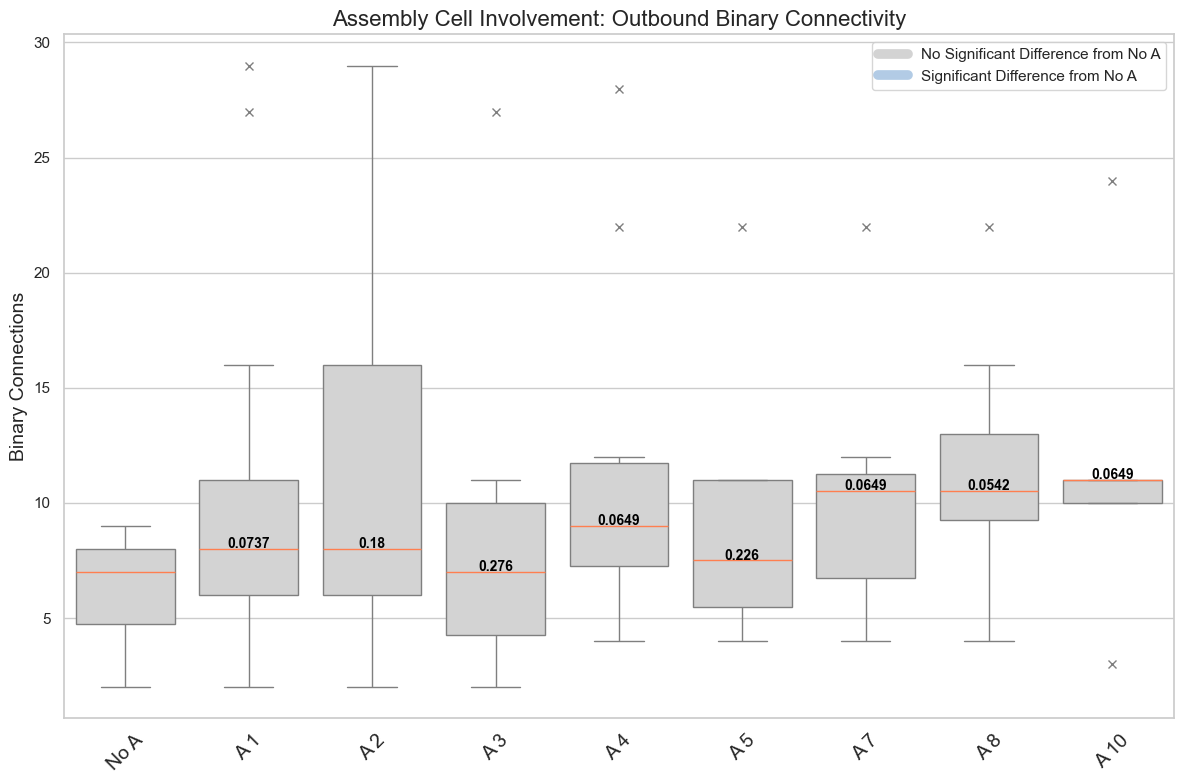

In [13]:
## Produce Outbound First-Order Connections Plot
produce_first_order_connections_plot(input_connections_dict = outbound_binary_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
[       nan 0.04608285 0.1353315  0.27644255 0.03242684 0.19803291
 0.03203875 0.00677733 0.02260068]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


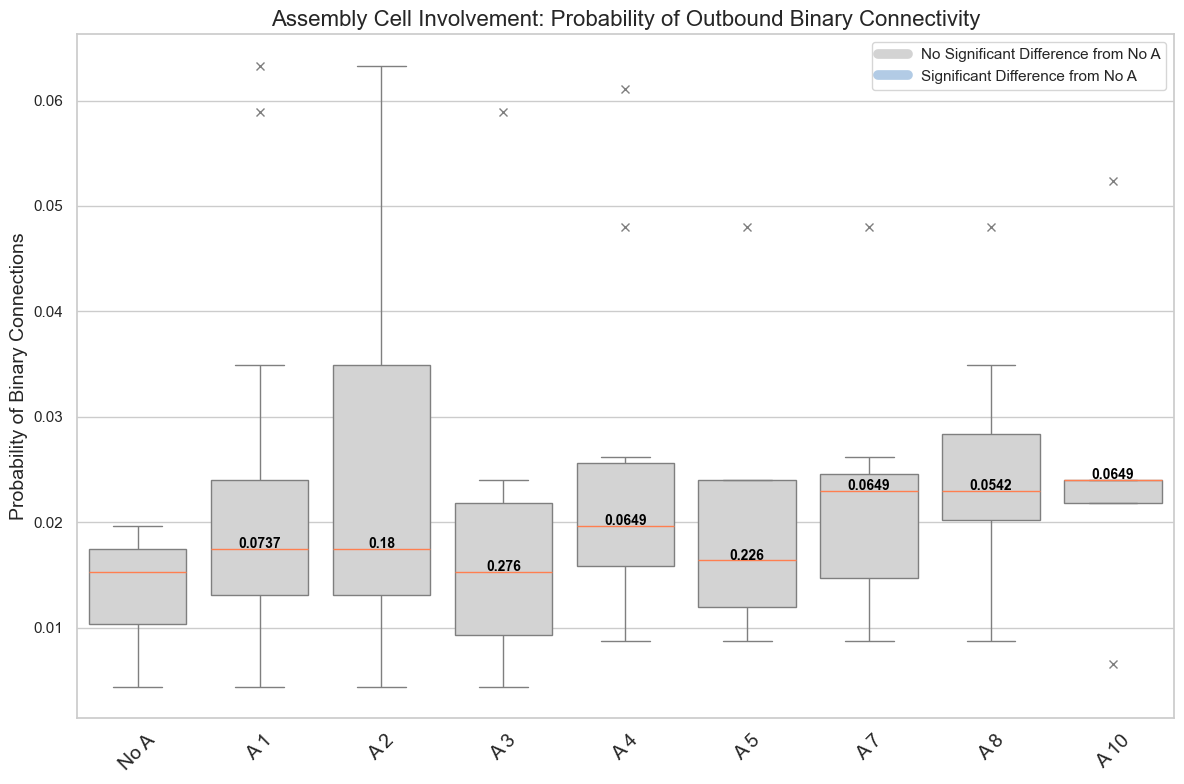

In [14]:
## Produce Outbound First-Order Connections Plot
produce_first_order_connections_plot(input_connections_dict = outbound_binary_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

[       nan 0.10497444 0.12775441 0.27644255 0.66589185 0.36422709
 0.73145301 0.75627335 0.43718353]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


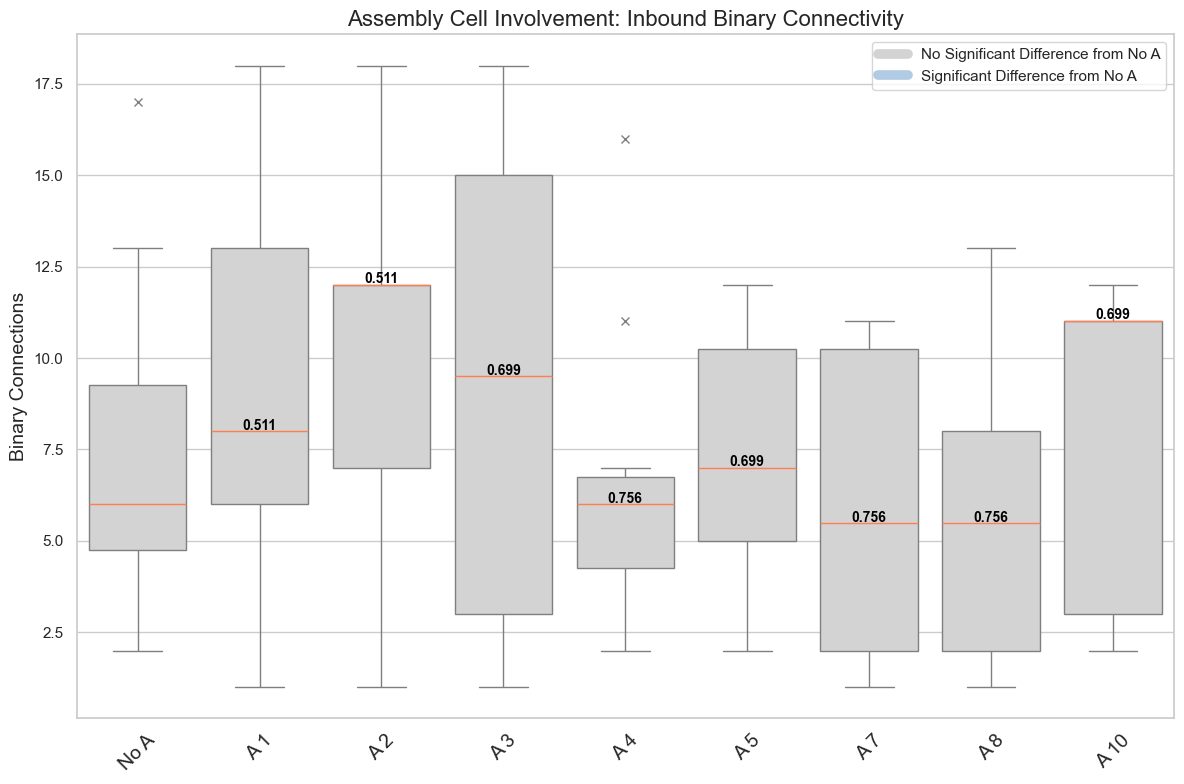

In [15]:
## Produce Inbound First-Order Connections Plot
produce_first_order_connections_plot(input_connections_dict = inbound_binary_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
[       nan 0.10497444 0.12775441 0.27644255 0.66589185 0.36422709
 0.73145301 0.75627335 0.43718353]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


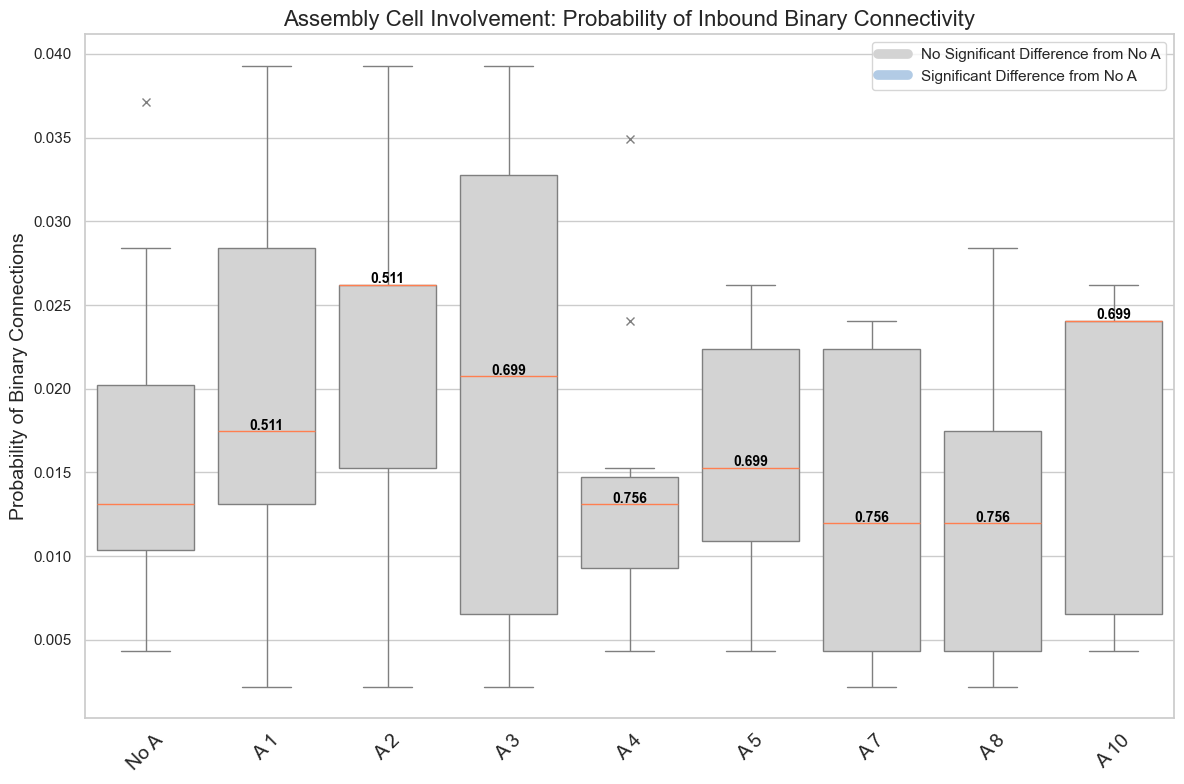

In [16]:
## Produce Inbound First-Order Connections Plot with Normalization
produce_first_order_connections_plot(input_connections_dict = inbound_binary_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

[       nan 0.13077784 0.33490768 0.62918298 0.16131427 0.43868528
 0.43868528 0.15793724 0.70091927]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


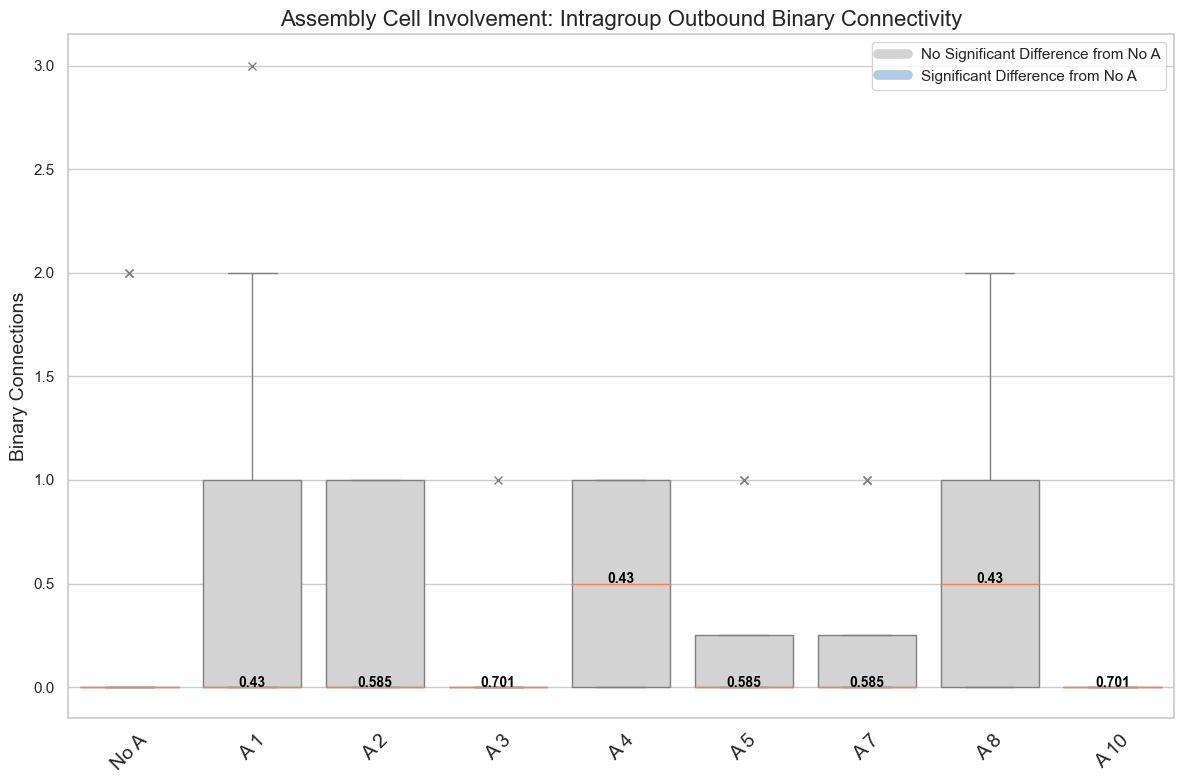

In [17]:
produce_first_order_connections_plot(input_connections_dict = outbound_binary_intragroup_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = True,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
[       nan 0.18454548 0.33490768 0.62918298 0.16131427 0.43868528
 0.43868528 0.14004361 0.70091927]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


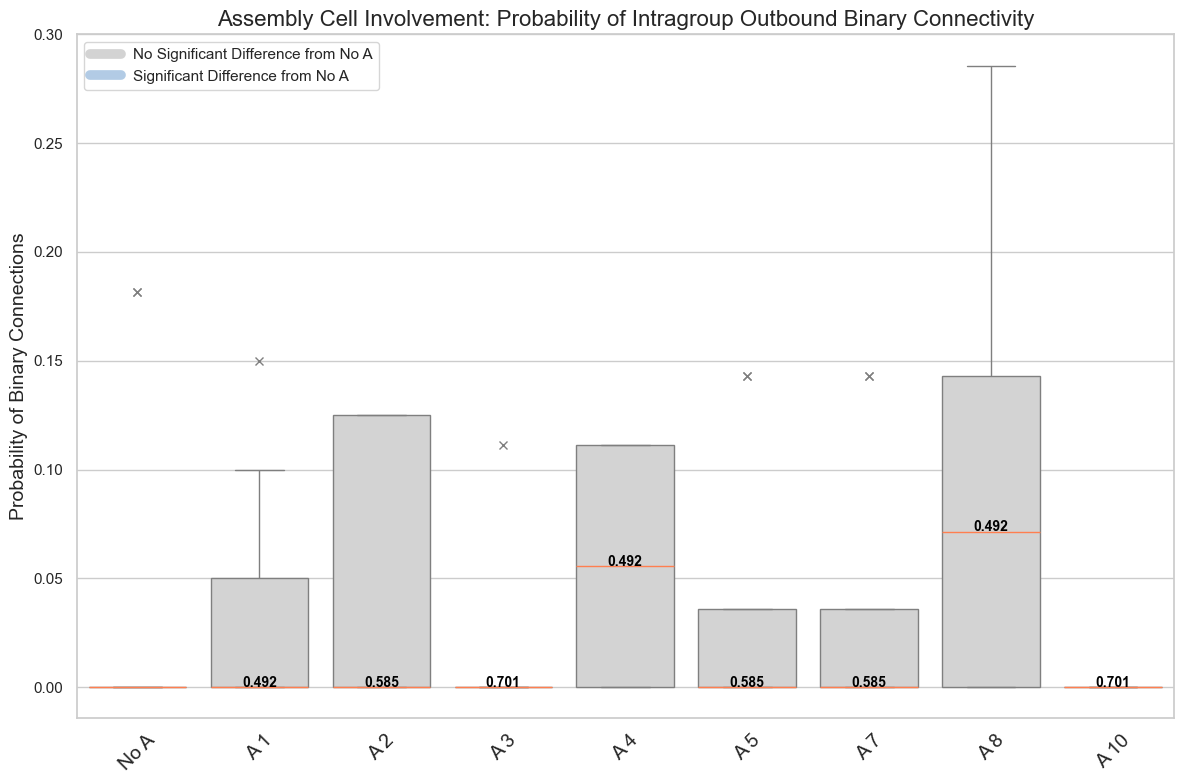

In [18]:
produce_first_order_connections_plot(input_connections_dict = outbound_binary_intragroup_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

[       nan 0.22708498 0.52832775 0.73447745 0.20490569 0.53074856
 0.65016219 0.28141688 0.78540235]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


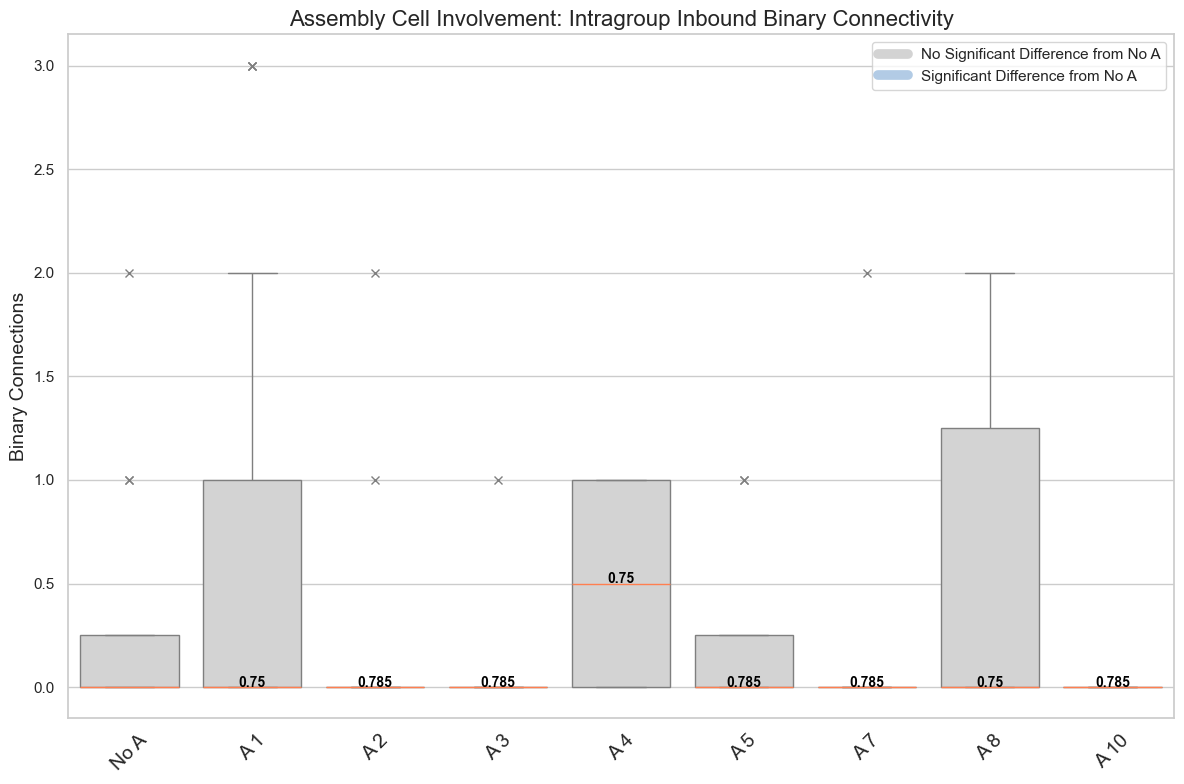

In [19]:
produce_first_order_connections_plot(input_connections_dict = inbound_binary_intragroup_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = True,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
[       nan 0.31996354 0.48582719 0.71242171 0.12426734 0.46925144
 0.63577291 0.23179723 0.78540235]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


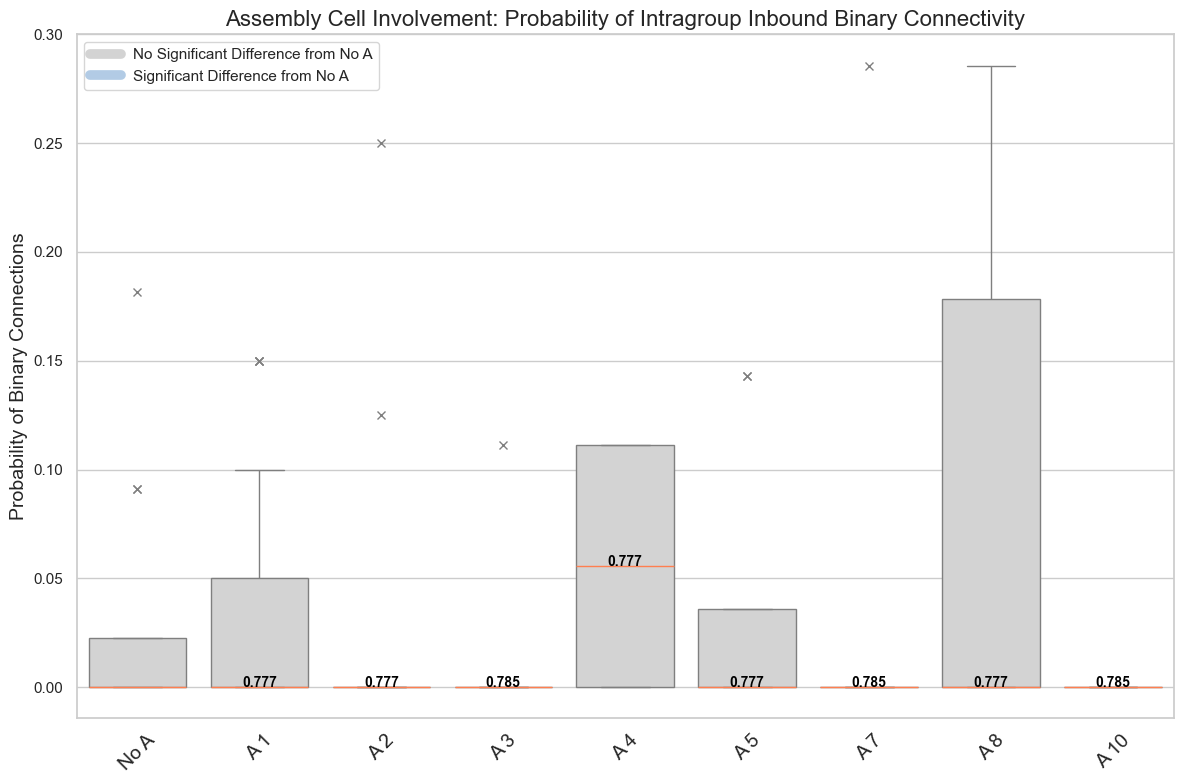

In [20]:
produce_first_order_connections_plot(input_connections_dict = inbound_binary_intragroup_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


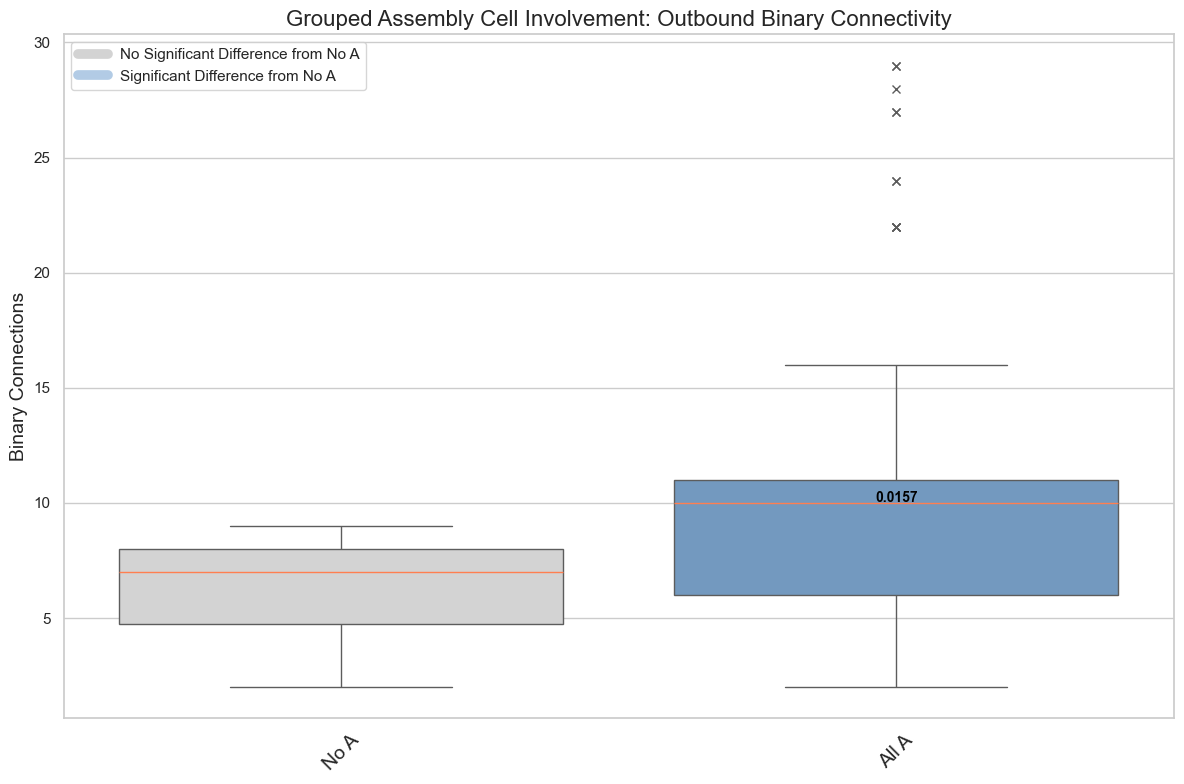

In [21]:
## Produce Grouped Outbound First-Order Connections Plot
produce_first_order_connections_plot(input_connections_dict = grouped_outbound_binary_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


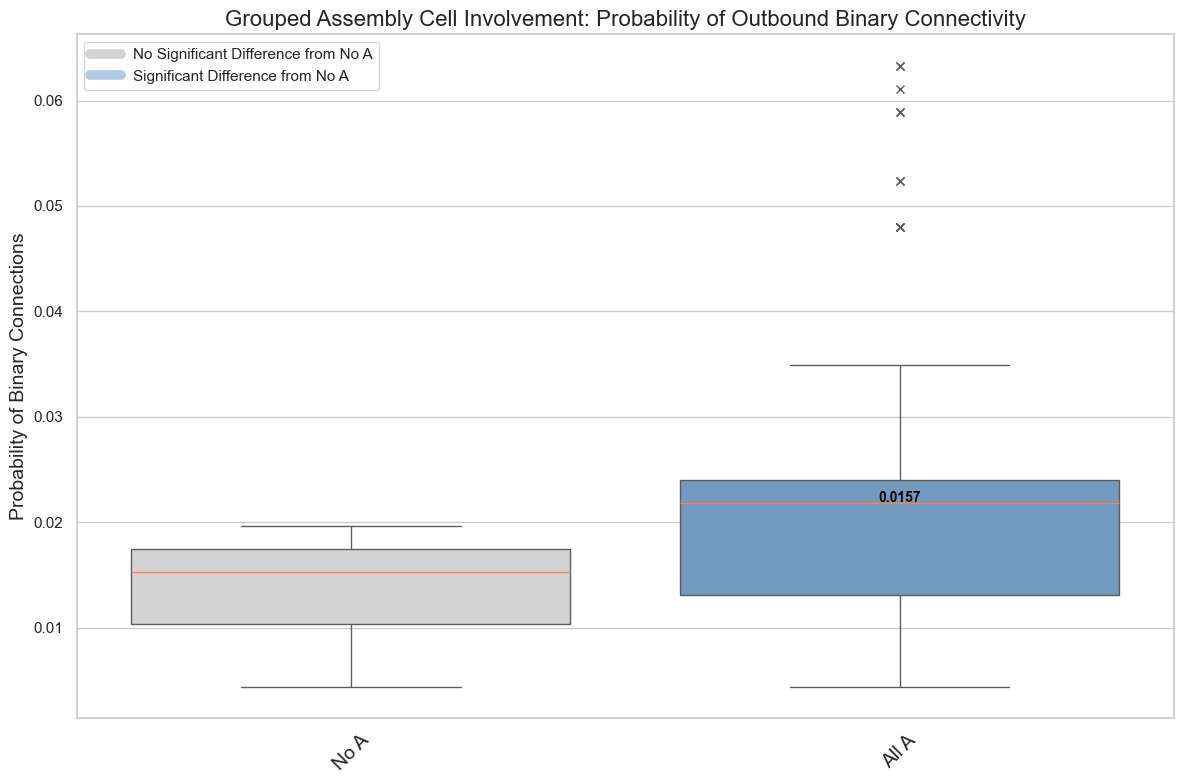

In [22]:
## Produce Grouped Outbound First-Order Connections Plot with Normalization
produce_first_order_connections_plot(input_connections_dict = grouped_outbound_binary_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


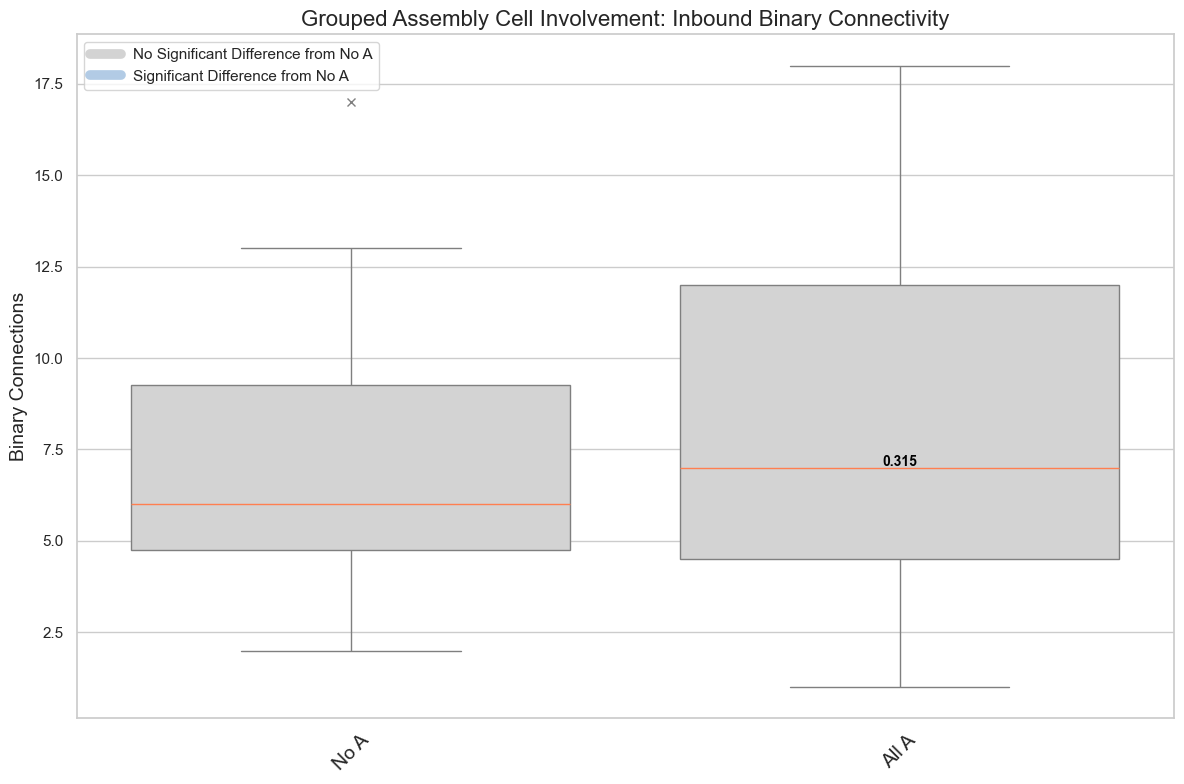

In [23]:
## Produce Grouped Outbound First-Order Connections Plot with Normalization
produce_first_order_connections_plot(input_connections_dict = grouped_inbound_binary_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


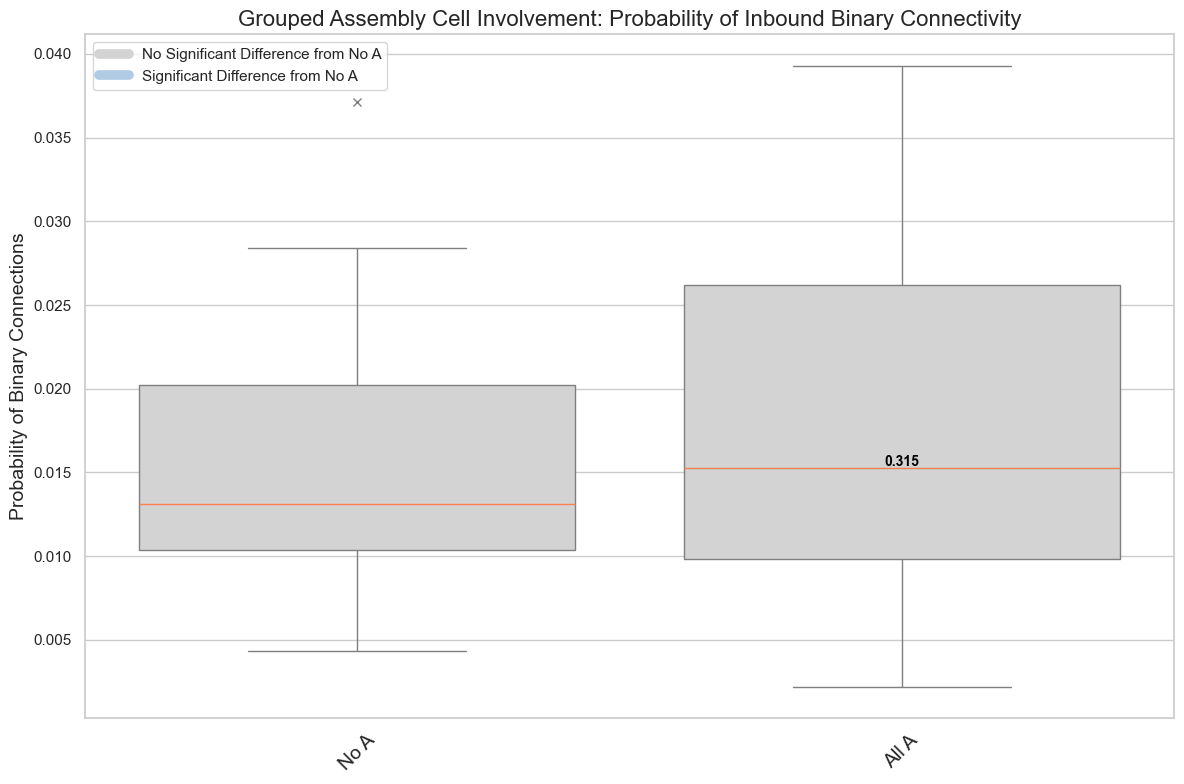

In [24]:
## Produce Grouped Outbound First-Order Connections Plot with Normalization
produce_first_order_connections_plot(input_connections_dict = grouped_inbound_binary_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

Probability Already Normalized.
Probability Already Normalized.


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


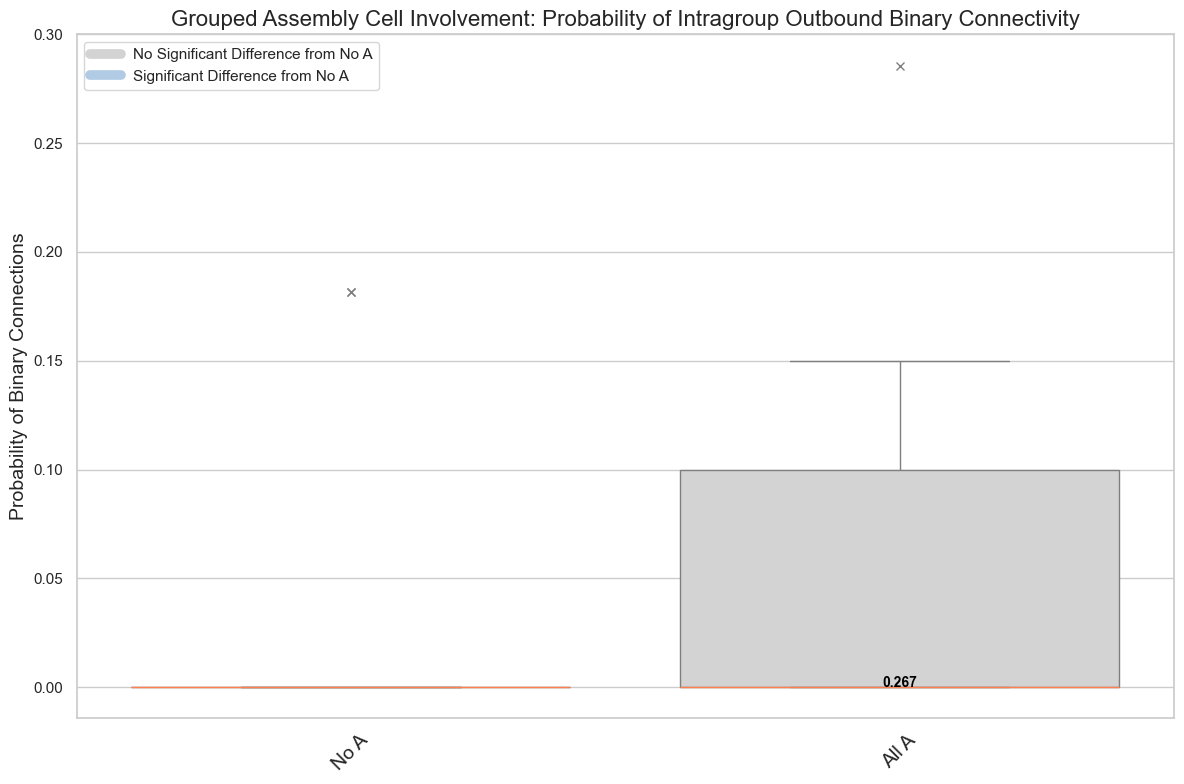

In [25]:
## Produce Grouped Outbound Intragroup First-Order Connections Plot
produce_first_order_connections_plot(input_connections_dict = grouped_intragroup_outbound_binary_first_order_connections,
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

Probability Already Normalized.
Probability Already Normalized.


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


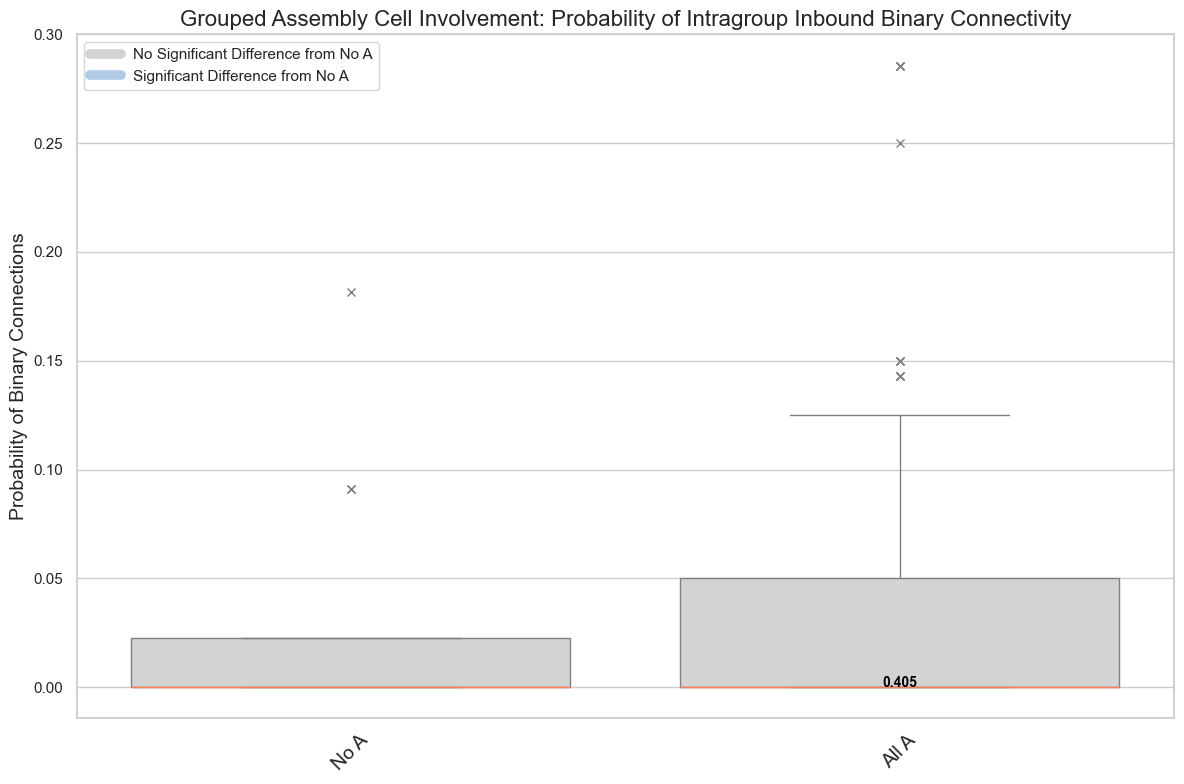

In [26]:
## Produce Grouped Inbound Intragroup First-Order Connections Plot
produce_first_order_connections_plot(input_connections_dict = grouped_intragroup_inbound_binary_first_order_connections,
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

### First-Order Analyss with Synapse Count Connectome

In [27]:
# Produce Counts for Inbound and Outbound Connections
outbound_syncount_first_order_connections = {}
inbound_syncount_first_order_connections = {}
outbound_syncount_intragroup_first_order_connections = {}
inbound_syncount_intragroup_first_order_connections = {}

for A in assemblies_by_coregistered.keys():
    if len(assemblies_by_coregistered[A]) >= 5:
        outbound_syncount_first_order_connections[A] = []
        inbound_syncount_first_order_connections[A] = []
        outbound_syncount_intragroup_first_order_connections[A] = []
        inbound_syncount_intragroup_first_order_connections[A] = []
        for connectome_id in assemblies_by_coregistered[A]:
            outbound_syncount_first_order_connections[A].append(np.sum(synapse_count_connectome[connectome_id,:]))
            inbound_syncount_first_order_connections[A].append(np.sum(synapse_count_connectome[:,connectome_id]))
            outbound_syncount_intragroup_first_order_connections[A].append(np.sum(synapse_count_connectome[connectome_id,assemblies_by_coregistered[A]]))
            inbound_syncount_intragroup_first_order_connections[A].append(np.sum(synapse_count_connectome[assemblies_by_coregistered[A], connectome_id]))

print("Outbound SynCount: ", outbound_syncount_first_order_connections)
print("Inbound SynCount: ", inbound_syncount_first_order_connections)
print("Outbound SynCount Intragroup: ", outbound_syncount_intragroup_first_order_connections)
print("Inbound SynCount Intragroup: ", inbound_syncount_intragroup_first_order_connections)

Outbound SynCount:  {'A 1': [17.0, 12.0, 7.0, 11.0, 4.0, 9.0, 12.0, 7.0, 21.0, 32.0, 7.0, 7.0, 2.0, 2.0, 8.0, 12.0, 6.0, 8.0, 32.0, 17.0, 12.0], 'A 3': [12.0, 4.0, 32.0, 7.0, 2.0, 8.0, 12.0, 11.0, 12.0, 4.0], 'A 4': [12.0, 12.0, 7.0, 12.0, 8.0, 4.0, 38.0, 9.0, 5.0, 22.0], 'A 5': [12.0, 11.0, 7.0, 4.0, 5.0, 22.0, 6.0, 10.0], 'A 7': [12.0, 11.0, 12.0, 7.0, 12.0, 5.0, 22.0, 6.0], 'A 8': [12.0, 12.0, 7.0, 21.0, 12.0, 12.0, 5.0, 22.0], 'A 10': [11.0, 12.0, 26.0, 11.0, 5.0], 'A 2': [21.0, 2.0, 32.0, 8.0, 7.0, 9.0, 12.0, 4.0, 26.0], 'No A': [4.0, 8.0, 9.0, 8.0, 10.0, 8.0, 7.0, 9.0, 5.0, 2.0, 4.0, 8.0]}
Inbound SynCount:  {'A 1': [16.0, 2.0, 14.0, 11.0, 19.0, 8.0, 5.0, 11.0, 14.0, 17.0, 7.0, 12.0, 13.0, 6.0, 5.0, 7.0, 14.0, 7.0, 1.0, 5.0, 9.0], 'A 3': [2.0, 19.0, 17.0, 12.0, 13.0, 7.0, 9.0, 19.0, 1.0, 2.0], 'A 4': [2.0, 5.0, 11.0, 7.0, 7.0, 7.0, 19.0, 5.0, 6.0, 2.0], 'A 5': [2.0, 11.0, 12.0, 7.0, 6.0, 2.0, 10.0, 7.0], 'A 7': [2.0, 11.0, 5.0, 11.0, 1.0, 6.0, 2.0, 10.0], 'A 8': [2.0, 5.0, 11.0, 

In [28]:
# Produce Grouped Counts for Inbound and Outbound Connections
grouped_outbound_syncount_first_order_connections = {'No A': [], "All A": []}
grouped_inbound_syncount_first_order_connections = {'No A': [], "All A": []}
grouped_intragroup_outbound_syncount_first_order_connections = {'No A': [], "All A": []}
grouped_intragroup_inbound_syncount_first_order_connections = {'No A': [], "All A": []}

for A in assemblies_by_coregistered.keys():
    if len(assemblies_by_coregistered[A]) >= 5:
        for c_index in assemblies_by_coregistered[A]:
            if A == 'No A':
                grouped_outbound_syncount_first_order_connections['No A'].append(np.sum(synapse_count_connectome[c_index,:]))
                grouped_inbound_syncount_first_order_connections['No A'].append(np.sum(synapse_count_connectome[:,c_index]))
                # Will normalize already by all possible connections in group
                grouped_intragroup_outbound_syncount_first_order_connections['No A'].append(np.sum(synapse_count_connectome[c_index,assemblies_by_coregistered[A]]) / (len(assemblies_by_coregistered[A]) - 1))
                grouped_intragroup_inbound_syncount_first_order_connections['No A'].append(np.sum(synapse_count_connectome[assemblies_by_coregistered[A],c_index]) / (len(assemblies_by_coregistered[A]) - 1))
            else:
                grouped_outbound_syncount_first_order_connections['All A'].append(np.sum(synapse_count_connectome[c_index,:]))
                grouped_inbound_syncount_first_order_connections['All A'].append(np.sum(synapse_count_connectome[:,c_index]))
                # Will normalize already by all possible connections in group
                grouped_intragroup_outbound_syncount_first_order_connections['All A'].append(np.sum(synapse_count_connectome[c_index,assemblies_by_coregistered[A]]) / (len(assemblies_by_coregistered[A]) - 1))
                grouped_intragroup_inbound_syncount_first_order_connections['All A'].append(np.sum(synapse_count_connectome[assemblies_by_coregistered[A],c_index]) / (len(assemblies_by_coregistered[A]) - 1))

print("Grouped Outbound SynCount: ", grouped_outbound_syncount_first_order_connections)
print("Grouped Inbound SynCount: ", grouped_inbound_syncount_first_order_connections)
print("Grouped Outbound SynCount Intragroup: ", grouped_intragroup_outbound_syncount_first_order_connections)
print("Grouped Inbound SynCount Intragroup: ", grouped_intragroup_inbound_syncount_first_order_connections)

Grouped Outbound SynCount:  {'No A': [4.0, 8.0, 9.0, 8.0, 10.0, 8.0, 7.0, 9.0, 5.0, 2.0, 4.0, 8.0], 'All A': [17.0, 12.0, 7.0, 11.0, 4.0, 9.0, 12.0, 7.0, 21.0, 32.0, 7.0, 7.0, 2.0, 2.0, 8.0, 12.0, 6.0, 8.0, 32.0, 17.0, 12.0, 12.0, 4.0, 32.0, 7.0, 2.0, 8.0, 12.0, 11.0, 12.0, 4.0, 12.0, 12.0, 7.0, 12.0, 8.0, 4.0, 38.0, 9.0, 5.0, 22.0, 12.0, 11.0, 7.0, 4.0, 5.0, 22.0, 6.0, 10.0, 12.0, 11.0, 12.0, 7.0, 12.0, 5.0, 22.0, 6.0, 12.0, 12.0, 7.0, 21.0, 12.0, 12.0, 5.0, 22.0, 11.0, 12.0, 26.0, 11.0, 5.0, 21.0, 2.0, 32.0, 8.0, 7.0, 9.0, 12.0, 4.0, 26.0]}
Grouped Inbound SynCount:  {'No A': [5.0, 15.0, 11.0, 7.0, 2.0, 18.0, 10.0, 4.0, 6.0, 6.0, 6.0, 4.0], 'All A': [16.0, 2.0, 14.0, 11.0, 19.0, 8.0, 5.0, 11.0, 14.0, 17.0, 7.0, 12.0, 13.0, 6.0, 5.0, 7.0, 14.0, 7.0, 1.0, 5.0, 9.0, 2.0, 19.0, 17.0, 12.0, 13.0, 7.0, 9.0, 19.0, 1.0, 2.0, 2.0, 5.0, 11.0, 7.0, 7.0, 7.0, 19.0, 5.0, 6.0, 2.0, 2.0, 11.0, 12.0, 7.0, 6.0, 2.0, 10.0, 7.0, 2.0, 11.0, 5.0, 11.0, 1.0, 6.0, 2.0, 10.0, 2.0, 5.0, 11.0, 14.0, 9.0, 1.0,

Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
[       nan 0.05378253 0.10041256 0.14571066 0.03751121 0.14881073
 0.03203875 0.00677733 0.01171654]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


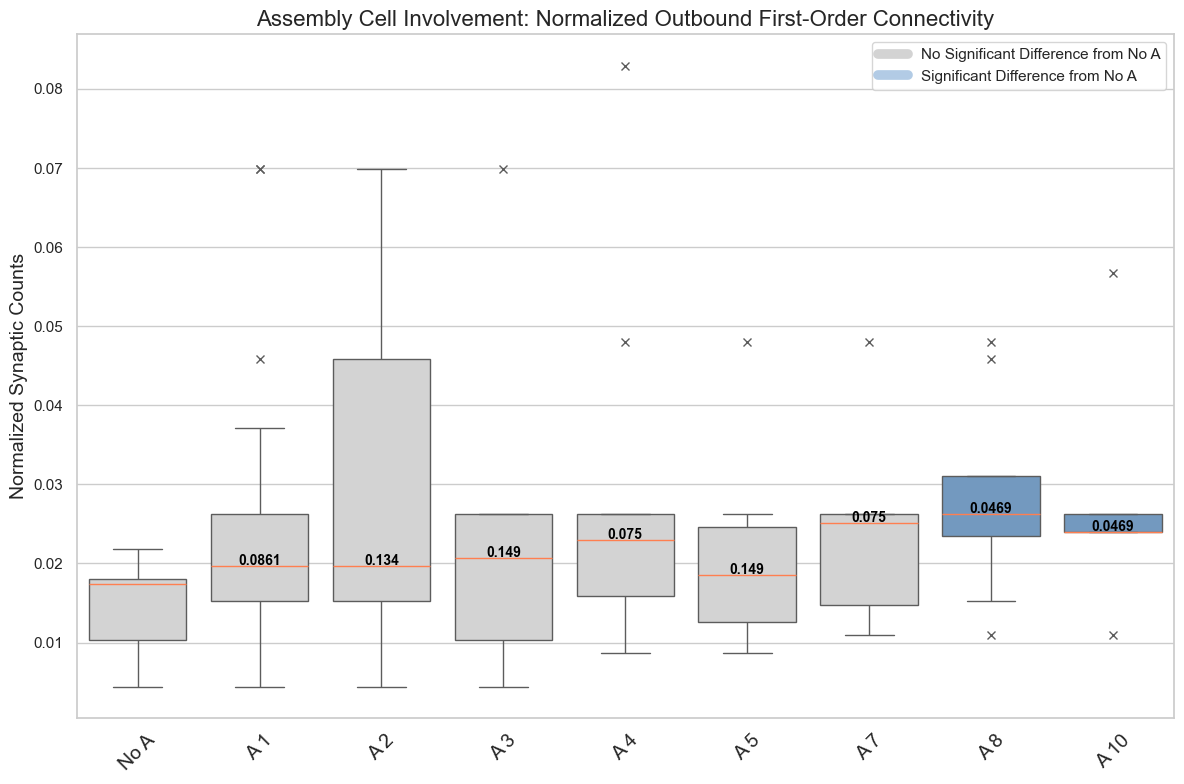

In [29]:
produce_first_order_connections_plot(input_connections_dict = outbound_syncount_first_order_connections, 
                                     total_cells = synapse_count_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459
[       nan 0.11554225 0.15139468 0.22413943 0.56546705 0.45393425
 0.79105652 0.79105652 0.45802554]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


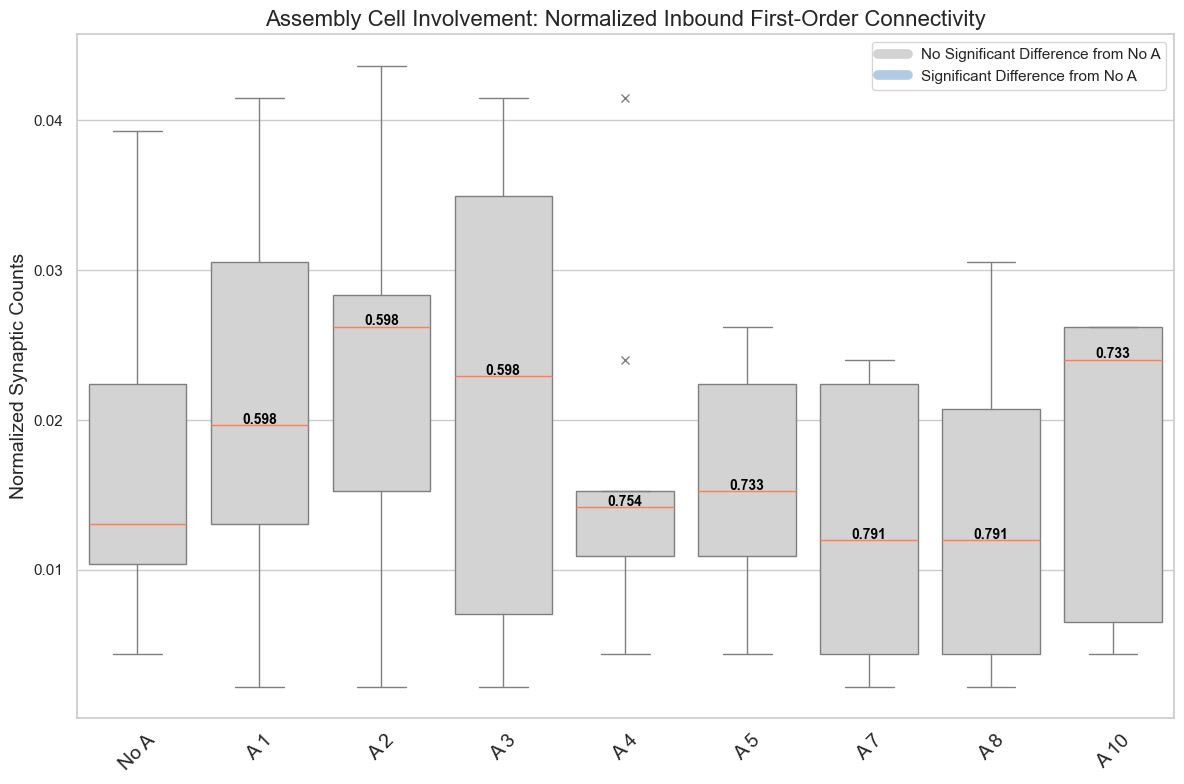

In [30]:
produce_first_order_connections_plot(input_connections_dict = inbound_syncount_first_order_connections, 
                                     total_cells = synapse_count_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


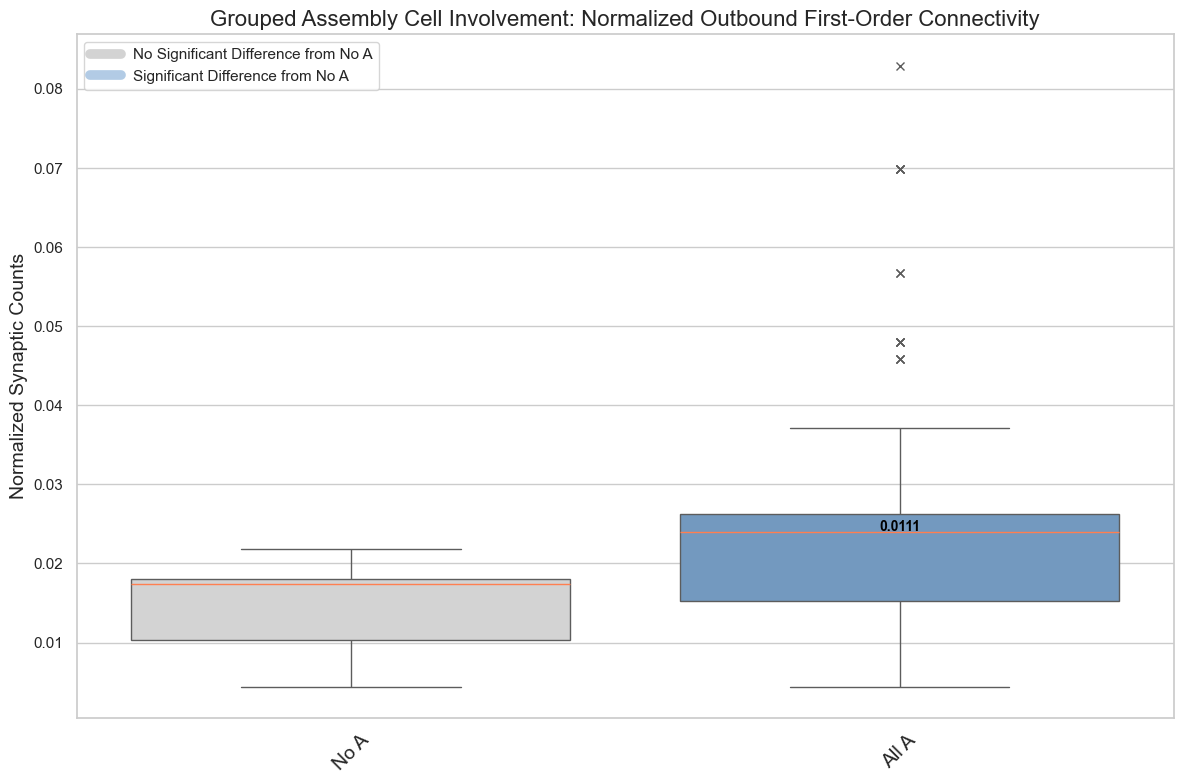

In [31]:
produce_first_order_connections_plot(input_connections_dict = grouped_outbound_syncount_first_order_connections, 
                                     total_cells = synapse_count_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

Producing Probability of Connections with total cell count: 459
Producing Probability of Connections with total cell count: 459


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


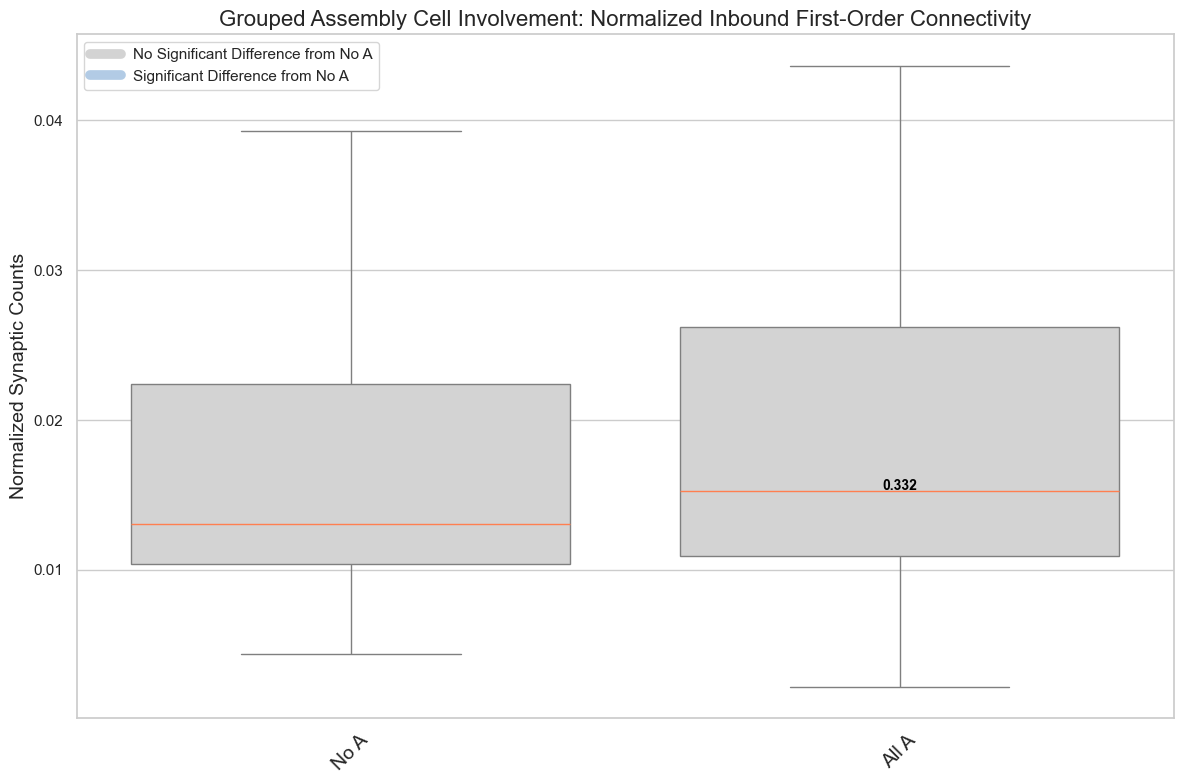

In [32]:
produce_first_order_connections_plot(input_connections_dict = grouped_inbound_syncount_first_order_connections, 
                                     total_cells = synapse_count_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

Probability Already Normalized.
Probability Already Normalized.


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


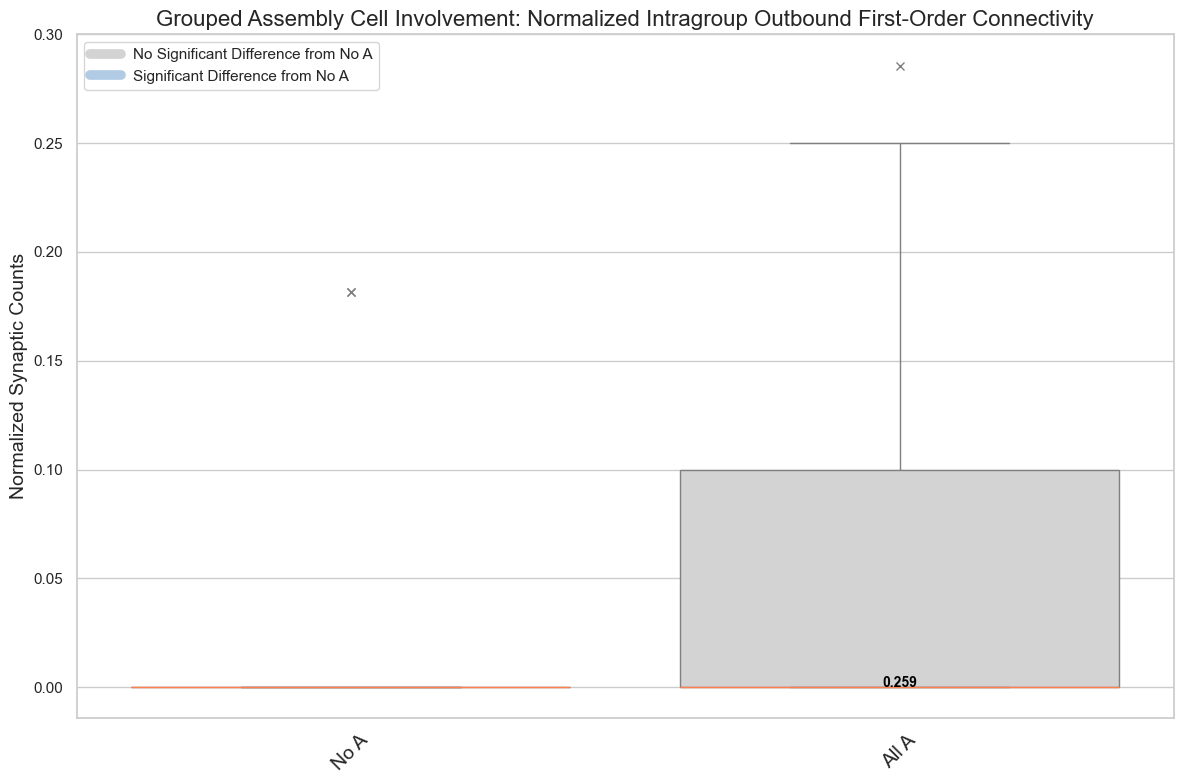

In [33]:
produce_first_order_connections_plot(input_connections_dict = grouped_intragroup_outbound_syncount_first_order_connections, 
                                     total_cells = synapse_count_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

Probability Already Normalized.
Probability Already Normalized.


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


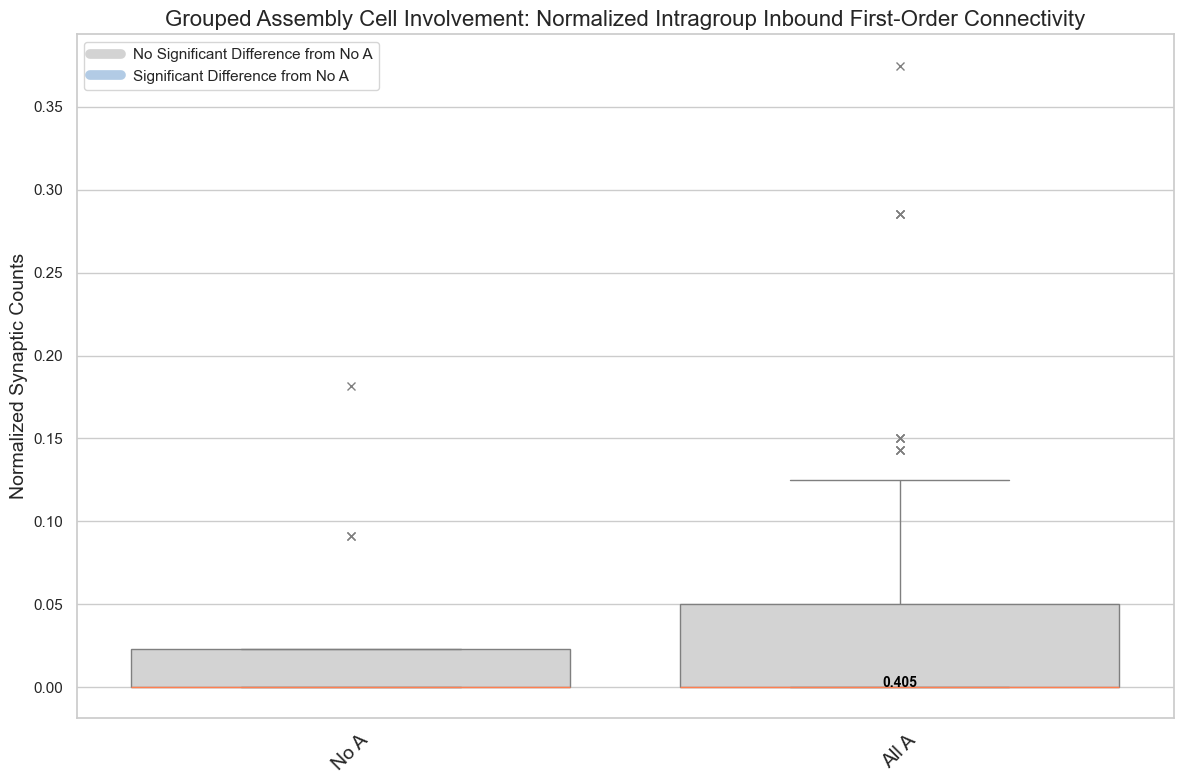

In [34]:
produce_first_order_connections_plot(input_connections_dict = grouped_intragroup_inbound_syncount_first_order_connections, 
                                     total_cells = synapse_count_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

### First-Order Analysis with Summed PSD Connectome

In [172]:
# Produce Counts for Inbound and Outbound Connections
outbound_summed_psd_first_order_connections = {}
inbound_summed_psd_first_order_connections = {}
outbound_summed_psd_intragroup_first_order_connections = {}
inbound_summed_psd_intragroup_first_order_connections = {}

for A in assemblies_by_coregistered.keys():
    if len(assemblies_by_coregistered[A]) >= 5:
        outbound_summed_psd_first_order_connections[A] = []
        inbound_summed_psd_first_order_connections[A] = []
        outbound_summed_psd_intragroup_first_order_connections[A] = []
        inbound_summed_psd_intragroup_first_order_connections[A] = []
        for connectome_id in assemblies_by_coregistered[A]:
            outbound_summed_psd_first_order_connections[A].append(np.sum(summed_size_connectome[connectome_id,:]))
            inbound_summed_psd_first_order_connections[A].append(np.sum(summed_size_connectome[:,connectome_id]))
            outbound_summed_psd_intragroup_first_order_connections[A].append(np.sum(summed_size_connectome[connectome_id,assemblies_by_coregistered[A]]))
            inbound_summed_psd_intragroup_first_order_connections[A].append(np.sum(summed_size_connectome[assemblies_by_coregistered[A], connectome_id]))

print("Outbound Summed PSD: ", outbound_summed_psd_first_order_connections)
print("Inbound Summed PSD: ", inbound_summed_psd_first_order_connections)
print("Outbound Summed PSD Intragroup: ", outbound_summed_psd_intragroup_first_order_connections)
print("Inbound Summed PSD Intragroup: ", inbound_summed_psd_intragroup_first_order_connections)

Outbound Summed PSD:  {'A 1': [37460.0, 23381.0, 15830.0, 21065.0, 6232.0, 13381.0, 20245.0, 15494.0, 24757.0, 54047.0, 9124.0, 17496.0, 6024.0, 1600.0, 9360.0, 17704.0, 14571.0, 19321.0, 55891.0, 28637.0, 16262.0], 'A 3': [23381.0, 6232.0, 54047.0, 17496.0, 6024.0, 19321.0, 16262.0, 26485.0, 22133.0, 7276.0], 'A 4': [23381.0, 20245.0, 15494.0, 17704.0, 19321.0, 7315.0, 85343.0, 26288.0, 6874.0, 42770.0], 'A 5': [23381.0, 21065.0, 17496.0, 7315.0, 6874.0, 42770.0, 15869.0, 24003.0], 'A 7': [23381.0, 21065.0, 20245.0, 15494.0, 22133.0, 6874.0, 42770.0, 15869.0], 'A 8': [23381.0, 20245.0, 15494.0, 24757.0, 16262.0, 22133.0, 6874.0, 42770.0], 'A 10': [21065.0, 29219.0, 60493.0, 21519.0, 11412.0], 'A 2': [24757.0, 6024.0, 55891.0, 25136.0, 5923.0, 23586.0, 29219.0, 7315.0, 60493.0], 'No A': [1765.0, 14213.0, 15270.0, 17274.0, 11432.0, 7831.0, 15692.0, 23404.0, 5013.0, 5852.0, 9790.0, 14196.0]}
Inbound Summed PSD:  {'A 1': [71212.0, 5204.0, 47277.0, 10795.0, 48145.0, 19102.0, 12311.0, 25731

V 2396.0
V 5755.0
A 1 S 0.02144260928117728
V 1735.0
V 3059.0
V 2212.0
A 1 S 0.02108219572323198
V 267.0
A 1 S 0.01330297299619107
V 441.0
V 1320.0
A 1 S 0.01779437406784811
V 1597.0
V 2233.0
A 1 S 0.01964433352898736
V 642.0
A 1 S 0.015391876913547526
V 1397.0
V 658.0
A 1 S 0.018161978873643653
V 3854.0
A 1 S 0.01965920678327217
V 388.0
A 1 S 0.014192869856245889
V 3059.0
A 3 S 0.08917603715723225
V 2212.0
A 4 S 0.08557391514046918
V 2558.0
A 4 S 0.08718867757931988
V 1977.0
A 4 S 0.08432595359078464
V 772.0
A 4 S 0.0738776061113864
V 4921.0
A 4 S 0.09445852267628864
V 159.0
A 5 S 0.09051614646821841
V 1632.0
A 5 S 0.13209931313435808
V 2381.0
A 7 S 0.13884421154440826
V 4921.0
A 7 S 0.1518083400154639
V 1735.0
A 8 S 0.1331921909353743
V 3467.0
A 8 S 0.14555437403008972
V 2381.0
V 1652.0
A 8 S 0.14825474633702443
V 4921.0
A 8 S 0.1518083400154639
V 5735.0
A 2 S 0.1201992087439371
V 8360.0
A 2 S 0.12543352369553815
V 2406.0
A 2 S 0.10813501245186978
V 6714.0
V 1476.0
No A S 0.068262645

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_7333/1332959194.py:115: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


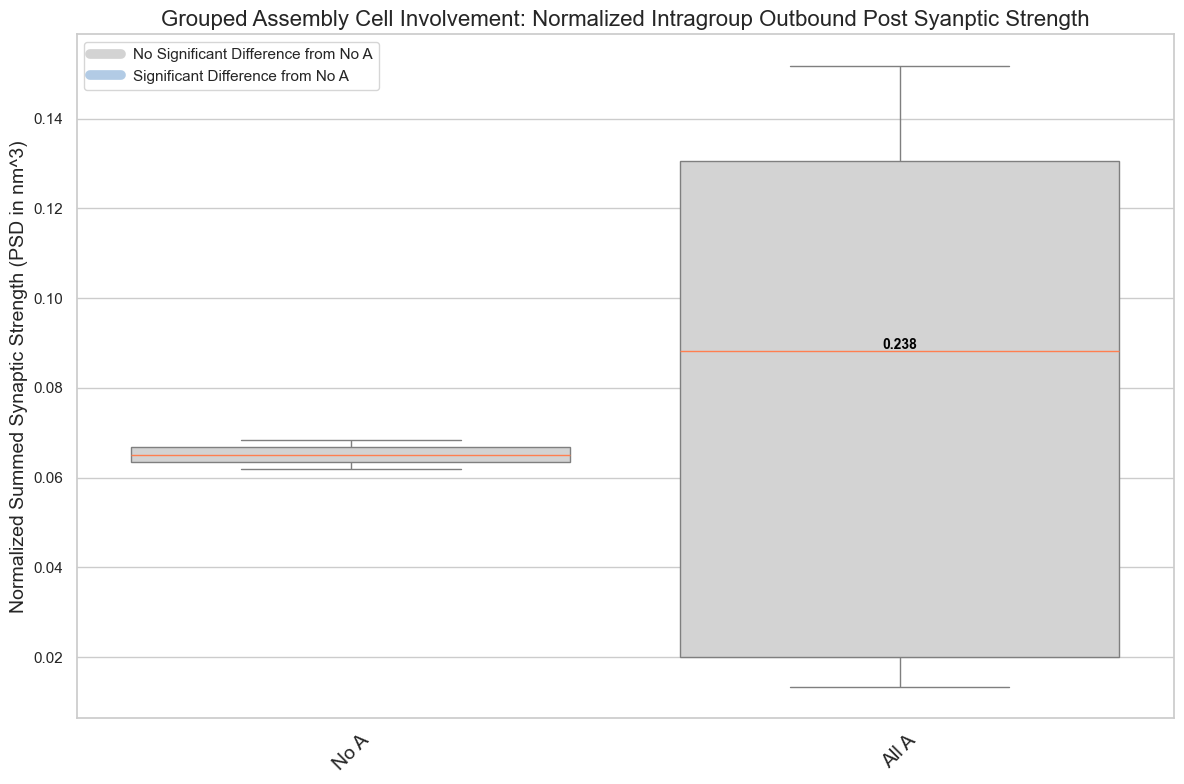

1.3263814164568197

In [230]:
stefan_check = {"All A": [], "No A": []}
c_in = 0
c_out = 0
for A in assemblies_by_coregistered.keys():
    if len(assemblies_by_coregistered[A]) >= 2:
        for connectome_id in assemblies_by_coregistered[A]:
            if A == 'No A':
                s = 0
                a = summed_size_connectome[connectome_id,assemblies_by_coregistered[A]]
                for v in a[np.nonzero(a)]:
                    print("V", v)
                    s += v
                if s != 0:
                    l = len(assemblies_by_coregistered[A])
                    print(A, "S", np.log(s) / (l * (l-1)))
                    stefan_check['No A'].append(np.log(s) / (l * (l-1)))
                    c_out += 1
            else:
                s = 0
                a = summed_size_connectome[connectome_id,assemblies_by_coregistered[A]]
                for v in a[np.nonzero(a)]:
                    print("V", v)
                    s += v
                if s != 0:
                    l = len(assemblies_by_coregistered[A])
                    print(A, "S", np.log(s) / (l * (l-1)))
                    stefan_check['All A'].append(np.log(s) / (l * (l-1)))
                    c_in += 1
print(c_in, c_out)

produce_first_order_connections_plot(input_connections_dict = stefan_check, 
                                     total_cells = summed_size_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True,
                                     save_fig = False)
-np.log(summed_size_connectome[i,j] / sum(summed_size_connectome[:,j]))


In [173]:
# Produce Grouped Counts for Inbound and Outbound Connections
grouped_outbound_summed_psd_first_order_connections = {'No A': [], "All A": []}
grouped_inbound_summed_psd_first_order_connections = {'No A': [], "All A": []}
grouped_intragroup_outbound_summed_psd_first_order_connections = {'No A': [], "All A": []}
grouped_intragroup_inbound_summed_psd_first_order_connections = {'No A': [], "All A": []}

for A in assemblies_by_coregistered.keys():
    if len(assemblies_by_coregistered[A]) >= 5:
        for c_index in assemblies_by_coregistered[A]:
            if A == 'No A':
                grouped_outbound_summed_psd_first_order_connections['No A'].append(np.sum(summed_size_connectome[c_index,:]))
                grouped_inbound_summed_psd_first_order_connections['No A'].append(np.sum(summed_size_connectome[:,c_index]))
                # Will normalize already by all possible connections in group
                grouped_intragroup_outbound_summed_psd_first_order_connections['No A'].append(np.sum(summed_size_connectome[c_index,assemblies_by_coregistered[A]]) / (len(assemblies_by_coregistered[A]) - 1))
                grouped_intragroup_inbound_summed_psd_first_order_connections['No A'].append(np.sum(summed_size_connectome[assemblies_by_coregistered[A],c_index]) / (len(assemblies_by_coregistered[A]) - 1))
            else:
                grouped_outbound_summed_psd_first_order_connections['All A'].append(np.sum(summed_size_connectome[c_index,:]))
                grouped_inbound_summed_psd_first_order_connections['All A'].append(np.sum(summed_size_connectome[:,c_index]))
                # Will normalize already by all possible connections in group
                grouped_intragroup_outbound_summed_psd_first_order_connections['All A'].append(np.sum(summed_size_connectome[c_index,assemblies_by_coregistered[A]]) / (len(assemblies_by_coregistered[A]) - 1))
                grouped_intragroup_inbound_summed_psd_first_order_connections['All A'].append(np.sum(summed_size_connectome[assemblies_by_coregistered[A],c_index]) / (len(assemblies_by_coregistered[A]) - 1))

print("Grouped Outbound Summed PSD: ", grouped_outbound_summed_psd_first_order_connections)
print("Grouped Inbound Summed PSD: ", grouped_inbound_summed_psd_first_order_connections)
print("Grouped Outbound Summed PSD Intragroup: ", grouped_intragroup_outbound_summed_psd_first_order_connections)
print("Grouped Inbound Summed PSD Intragroup: ", grouped_intragroup_inbound_summed_psd_first_order_connections)

Grouped Outbound Summed PSD:  {'No A': [1765.0, 14213.0, 15270.0, 17274.0, 11432.0, 7831.0, 15692.0, 23404.0, 5013.0, 5852.0, 9790.0, 14196.0], 'All A': [37460.0, 23381.0, 15830.0, 21065.0, 6232.0, 13381.0, 20245.0, 15494.0, 24757.0, 54047.0, 9124.0, 17496.0, 6024.0, 1600.0, 9360.0, 17704.0, 14571.0, 19321.0, 55891.0, 28637.0, 16262.0, 23381.0, 6232.0, 54047.0, 17496.0, 6024.0, 19321.0, 16262.0, 26485.0, 22133.0, 7276.0, 23381.0, 20245.0, 15494.0, 17704.0, 19321.0, 7315.0, 85343.0, 26288.0, 6874.0, 42770.0, 23381.0, 21065.0, 17496.0, 7315.0, 6874.0, 42770.0, 15869.0, 24003.0, 23381.0, 21065.0, 20245.0, 15494.0, 22133.0, 6874.0, 42770.0, 15869.0, 23381.0, 20245.0, 15494.0, 24757.0, 16262.0, 22133.0, 6874.0, 42770.0, 21065.0, 29219.0, 60493.0, 21519.0, 11412.0, 24757.0, 6024.0, 55891.0, 25136.0, 5923.0, 23586.0, 29219.0, 7315.0, 60493.0]}
Grouped Inbound Summed PSD:  {'No A': [11748.0, 36824.0, 17638.0, 22734.0, 5408.0, 37455.0, 16164.0, 1604.0, 17921.0, 13119.0, 9981.0, 10280.0], 'All A

[       nan 0.01645533 0.02750442 0.03751121 0.01050425 0.02687835
 0.01031878 0.00838523 0.01342835]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


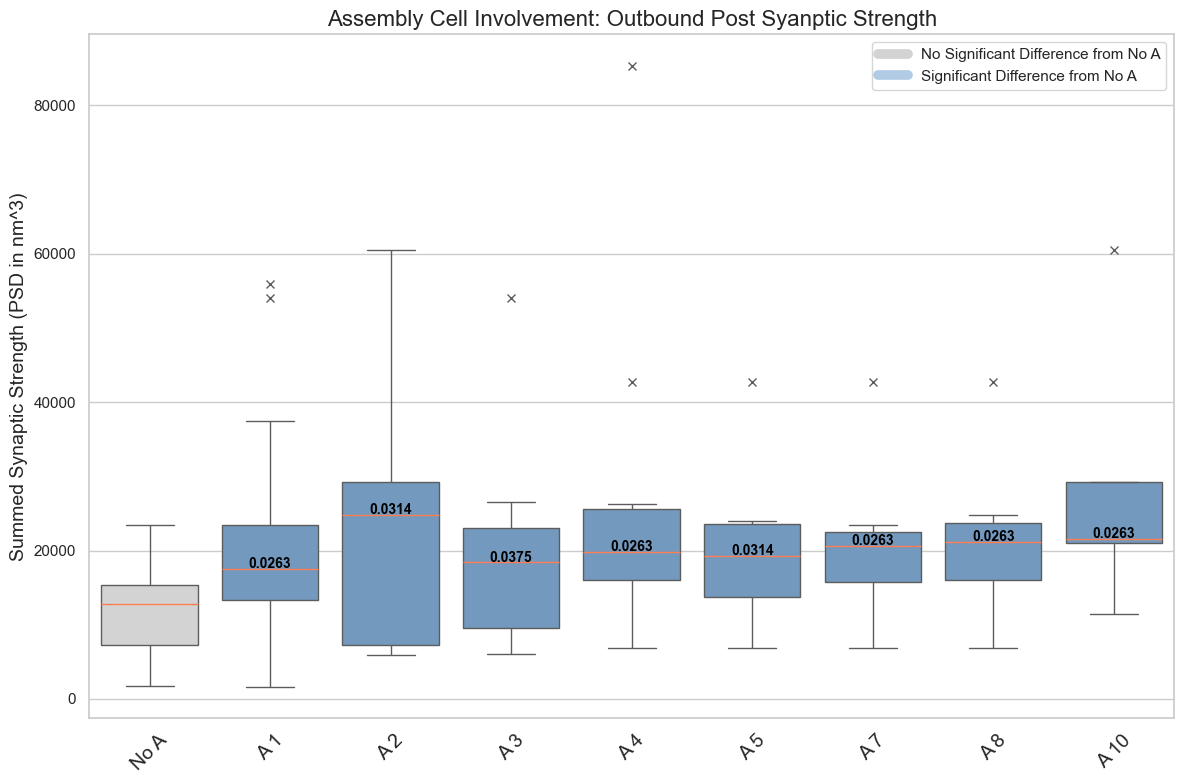

In [37]:
produce_first_order_connections_plot(input_connections_dict = outbound_summed_psd_first_order_connections, 
                                     total_cells = summed_size_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

[       nan 0.10161232 0.07760924 0.17796904 0.62918298 0.80196709
 0.85995639 0.59151934 0.58348555]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


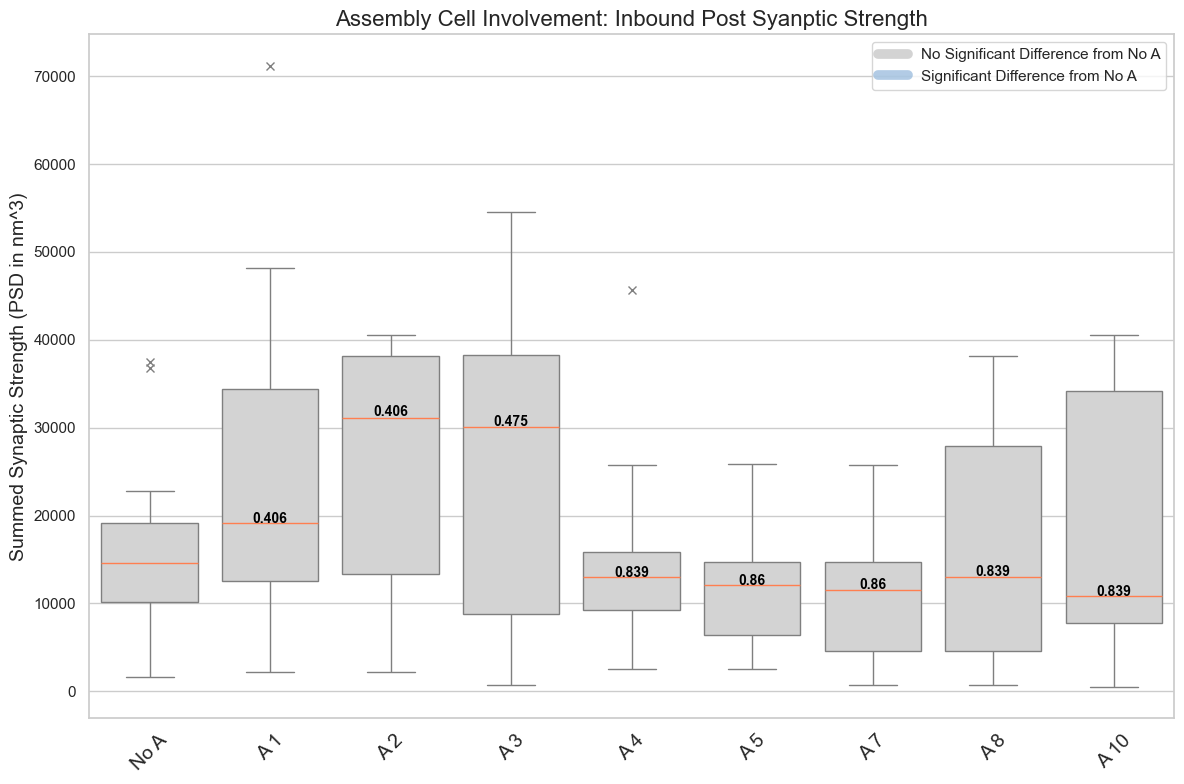

In [38]:
produce_first_order_connections_plot(input_connections_dict = inbound_summed_psd_first_order_connections, 
                                     total_cells = summed_size_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


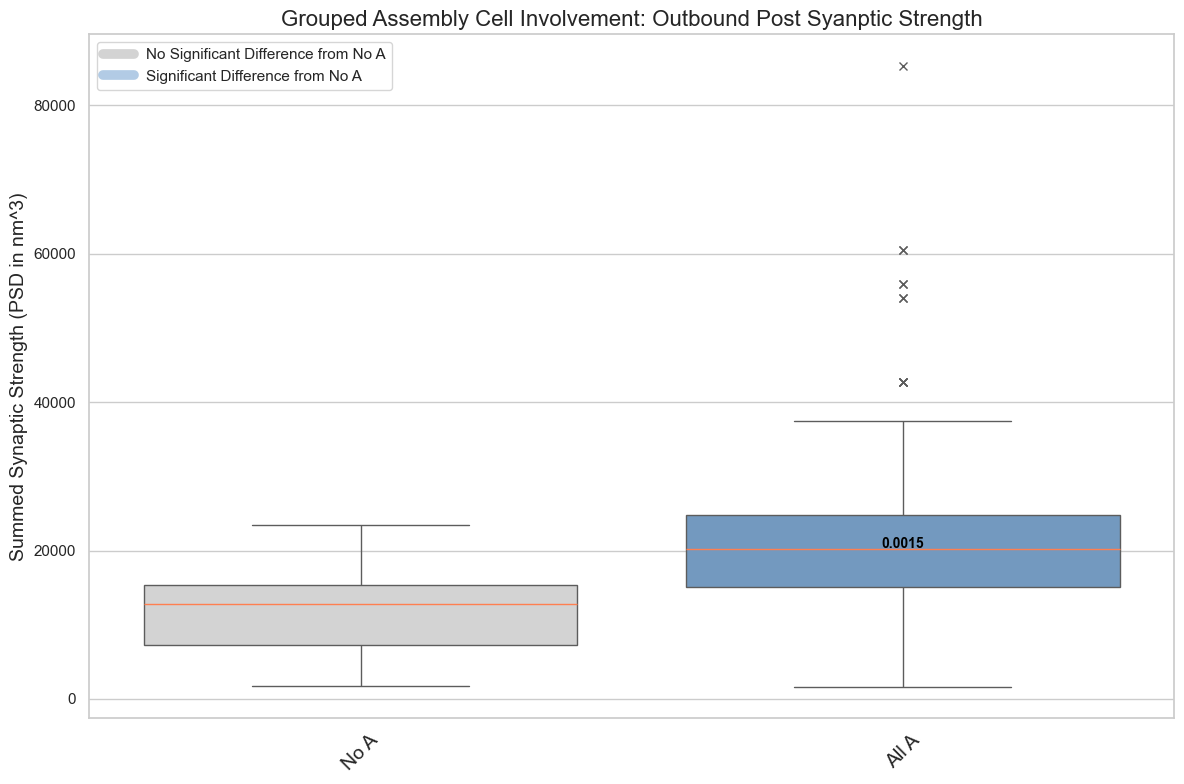

In [39]:
produce_first_order_connections_plot(input_connections_dict = grouped_outbound_summed_psd_first_order_connections, 
                                     total_cells = summed_size_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


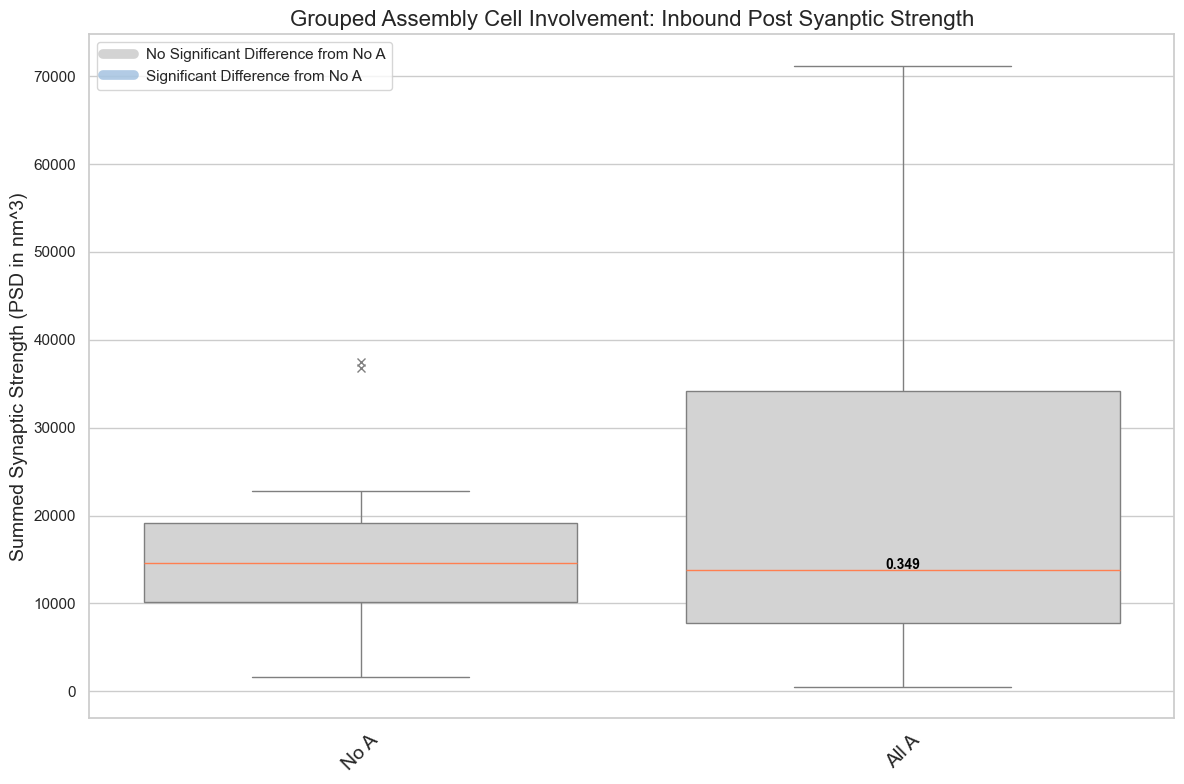

In [40]:
produce_first_order_connections_plot(input_connections_dict = grouped_inbound_summed_psd_first_order_connections, 
                                     total_cells = summed_size_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

Probability Already Normalized.
Probability Already Normalized.


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_7333/1332959194.py:115: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


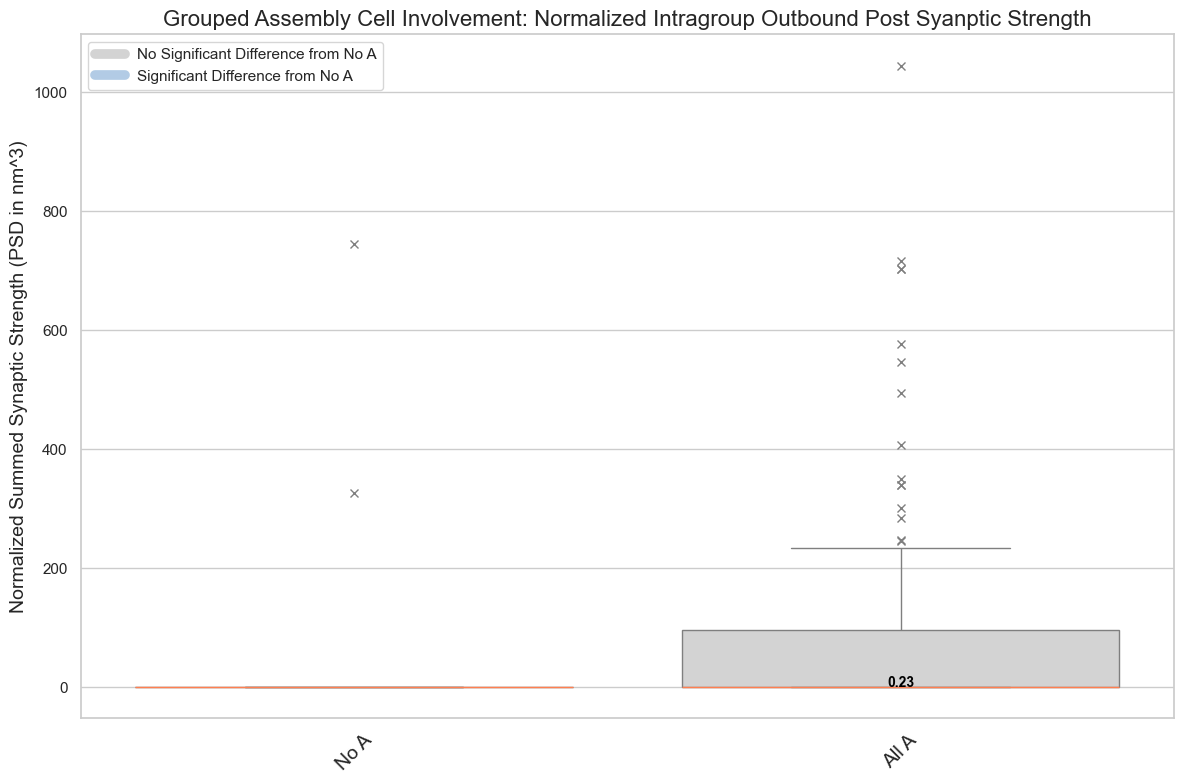

In [174]:
produce_first_order_connections_plot(input_connections_dict = grouped_intragroup_outbound_summed_psd_first_order_connections, 
                                     total_cells = summed_size_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

### First-Order Analysis with Average PSD Connectome

In [42]:
outbound_averaged_psd_first_order_connections = {}
inbound_averaged_psd_first_order_connections = {}
outbound_averaged_psd_intragroup_first_order_connections = {}
inbound_averaged_psd_intragroup_first_order_connections = {}

for A in assemblies_by_coregistered.keys():
    if len(assemblies_by_coregistered[A]) >= 5:
        outbound_averaged_psd_first_order_connections[A] = []
        inbound_averaged_psd_first_order_connections[A] = []
        outbound_averaged_psd_intragroup_first_order_connections[A] = []
        inbound_averaged_psd_intragroup_first_order_connections[A] = []
        for connectome_id in assemblies_by_coregistered[A]:
            outbound_averaged_psd_first_order_connections[A].append(np.sum(average_size_connectome[connectome_id,:]))
            inbound_averaged_psd_first_order_connections[A].append(np.sum(average_size_connectome[:,connectome_id]))
            outbound_averaged_psd_intragroup_first_order_connections[A].append(np.sum(average_size_connectome[connectome_id,assemblies_by_coregistered[A]]))
            inbound_averaged_psd_intragroup_first_order_connections[A].append(np.sum(average_size_connectome[assemblies_by_coregistered[A], connectome_id]))

print("Outbound Averaged PSD: ", outbound_averaged_psd_first_order_connections)
print("Inbound Averaged PSD: ", inbound_averaged_psd_first_order_connections)
print("Outbound Averaged PSD Intragroup: ", outbound_averaged_psd_intragroup_first_order_connections)
print("Inbound Averaged PSD Intragroup: ", inbound_averaged_psd_intragroup_first_order_connections)

Outbound Averaged PSD:  {'A 1': [36947.5, 22497.5, 15830.0, 21065.0, 6232.0, 12971.5, 20245.0, 15494.0, 20085.5, 49293.5, 9124.0, 14332.0, 6024.0, 1600.0, 7645.0, 15121.5, 14571.0, 19321.0, 49332.166666666664, 18297.8, 14064.0], 'A 3': [22497.5, 6232.0, 49293.5, 14332.0, 6024.0, 19321.0, 14064.0, 10973.666666666666, 13997.0, 7276.0], 'A 4': [22497.5, 20245.0, 15494.0, 15121.5, 19321.0, 7315.0, 57446.86666666667, 23521.0, 4884.0, 42770.0], 'A 5': [22497.5, 21065.0, 14332.0, 7315.0, 4884.0, 42770.0, 15869.0, 21281.0], 'A 7': [22497.5, 21065.0, 20245.0, 15494.0, 13997.0, 4884.0, 42770.0, 15869.0], 'A 8': [22497.5, 20245.0, 15494.0, 20085.5, 14064.0, 13997.0, 4884.0, 42770.0], 'A 10': [21065.0, 24751.0, 59125.5, 21519.0, 6144.0], 'A 2': [20085.5, 6024.0, 49332.166666666664, 23751.333333333336, 5923.0, 19048.5, 24751.0, 7315.0, 59125.5], 'No A': [1765.0, 13061.5, 14055.5, 17274.0, 9806.5, 5558.5, 15692.0, 23404.0, 5013.0, 5852.0, 9790.0, 12467.5]}
Inbound Averaged PSD:  {'A 1': [67701.0, 52

In [43]:
# Produce Grouped Counts for Inbound and Outbound Connections
grouped_outbound_averaged_psd_first_order_connections = {'No A': [], "All A": []}
grouped_inbound_averaged_psd_first_order_connections = {'No A': [], "All A": []}
grouped_intragroup_outbound_averaged_psd_first_order_connections = {'No A': [], "All A": []}
grouped_intragroup_inbound_averaged_psd_first_order_connections = {'No A': [], "All A": []}

for A in assemblies_by_coregistered.keys():
    if len(assemblies_by_coregistered[A]) >= 5:
        for c_index in assemblies_by_coregistered[A]:
            if A == 'No A':
                grouped_outbound_averaged_psd_first_order_connections['No A'].append(np.sum(average_size_connectome[c_index,:]))
                grouped_inbound_averaged_psd_first_order_connections['No A'].append(np.sum(average_size_connectome[:,c_index]))
                # Will normalize already by all possible connections in group
                grouped_intragroup_outbound_averaged_psd_first_order_connections['No A'].append(np.sum(average_size_connectome[c_index,assemblies_by_coregistered[A]]) / (len(assemblies_by_coregistered[A]) - 1))
                grouped_intragroup_inbound_averaged_psd_first_order_connections['No A'].append(np.sum(average_size_connectome[assemblies_by_coregistered[A],c_index]) / (len(assemblies_by_coregistered[A]) - 1))
            else:
                grouped_outbound_averaged_psd_first_order_connections['All A'].append(np.sum(average_size_connectome[c_index,:]))
                grouped_inbound_averaged_psd_first_order_connections['All A'].append(np.sum(average_size_connectome[:,c_index]))
                # Will normalize already by all possible connections in group
                grouped_intragroup_outbound_averaged_psd_first_order_connections['All A'].append(np.sum(average_size_connectome[c_index,assemblies_by_coregistered[A]]) / (len(assemblies_by_coregistered[A]) - 1))
                grouped_intragroup_inbound_averaged_psd_first_order_connections['All A'].append(np.sum(average_size_connectome[assemblies_by_coregistered[A],c_index]) / (len(assemblies_by_coregistered[A]) - 1))

print("Grouped Outbound Averaged PSD: ", grouped_outbound_averaged_psd_first_order_connections)
print("Grouped Inbound Averaged PSD: ", grouped_inbound_averaged_psd_first_order_connections)
print("Grouped Outbound Averaged PSD Intragroup: ", grouped_intragroup_outbound_averaged_psd_first_order_connections)
print("Grouped Inbound Averaged PSD Intragroup: ", grouped_intragroup_inbound_averaged_psd_first_order_connections)

Grouped Outbound Averaged PSD:  {'No A': [1765.0, 13061.5, 14055.5, 17274.0, 9806.5, 5558.5, 15692.0, 23404.0, 5013.0, 5852.0, 9790.0, 12467.5], 'All A': [36947.5, 22497.5, 15830.0, 21065.0, 6232.0, 12971.5, 20245.0, 15494.0, 20085.5, 49293.5, 9124.0, 14332.0, 6024.0, 1600.0, 7645.0, 15121.5, 14571.0, 19321.0, 49332.166666666664, 18297.8, 14064.0, 22497.5, 6232.0, 49293.5, 14332.0, 6024.0, 19321.0, 14064.0, 10973.666666666666, 13997.0, 7276.0, 22497.5, 20245.0, 15494.0, 15121.5, 19321.0, 7315.0, 57446.86666666667, 23521.0, 4884.0, 42770.0, 22497.5, 21065.0, 14332.0, 7315.0, 4884.0, 42770.0, 15869.0, 21281.0, 22497.5, 21065.0, 20245.0, 15494.0, 13997.0, 4884.0, 42770.0, 15869.0, 22497.5, 20245.0, 15494.0, 20085.5, 14064.0, 13997.0, 4884.0, 42770.0, 21065.0, 24751.0, 59125.5, 21519.0, 6144.0, 20085.5, 6024.0, 49332.166666666664, 23751.333333333336, 5923.0, 19048.5, 24751.0, 7315.0, 59125.5]}
Grouped Inbound Averaged PSD:  {'No A': [11748.0, 34872.5, 17215.5, 20086.0, 5408.0, 34950.0, 136

[       nan 0.0216451  0.02330244 0.11763652 0.01742842 0.05259625
 0.02687835 0.03203875 0.01750749]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


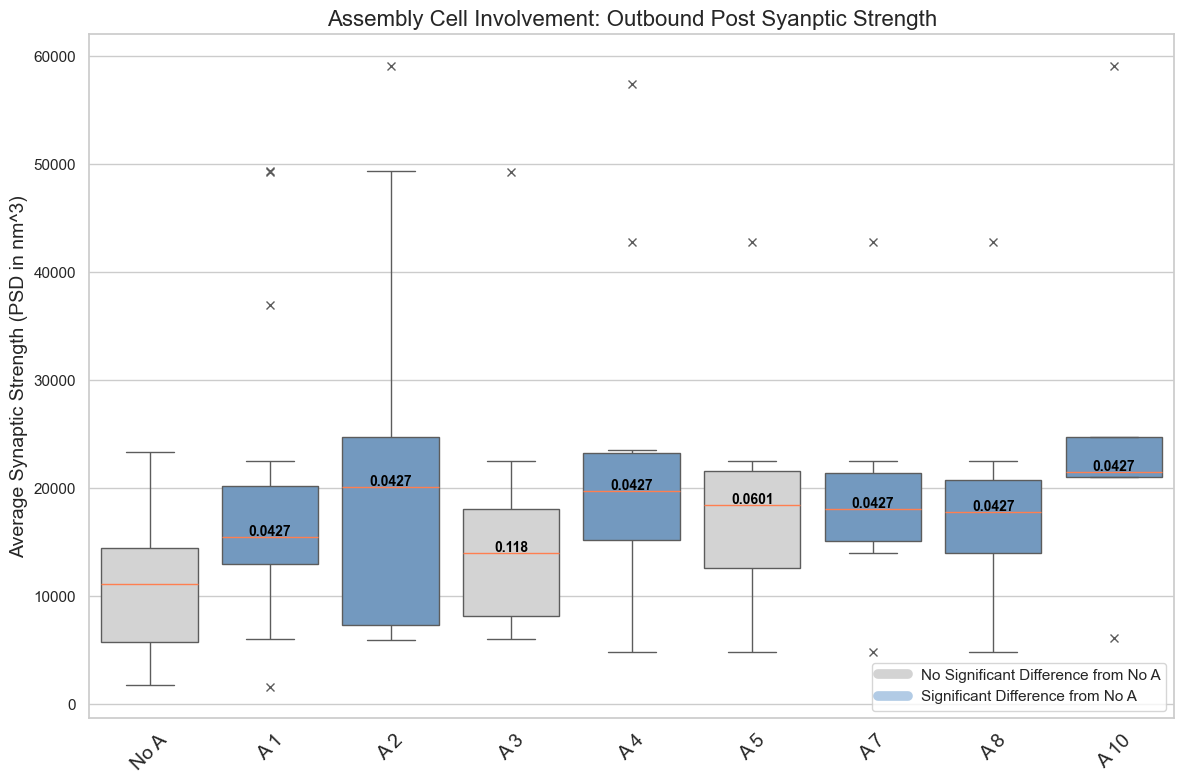

In [44]:
produce_first_order_connections_plot(input_connections_dict = outbound_averaged_psd_first_order_connections, 
                                     total_cells = average_size_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

[       nan 0.13077784 0.0677965  0.23412832 0.74517426 0.75627335
 0.82273026 0.56131472 0.58348555]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


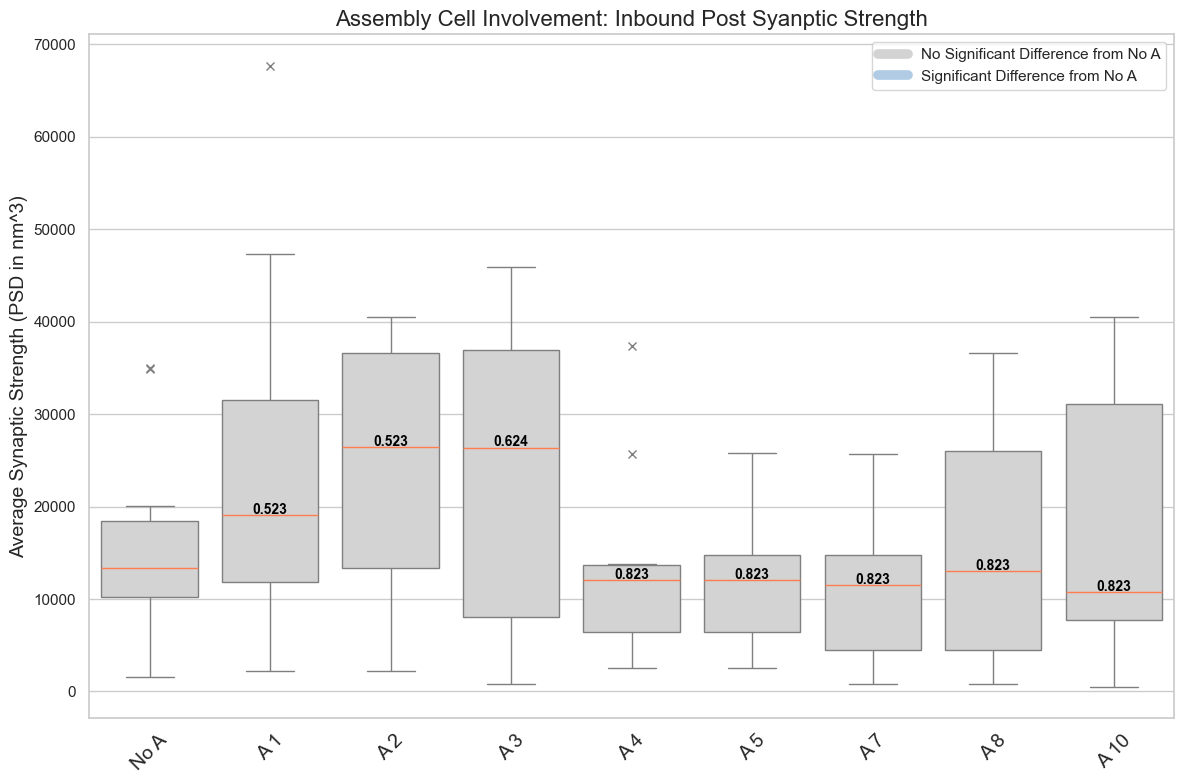

In [45]:
produce_first_order_connections_plot(input_connections_dict = inbound_averaged_psd_first_order_connections, 
                                     total_cells = average_size_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


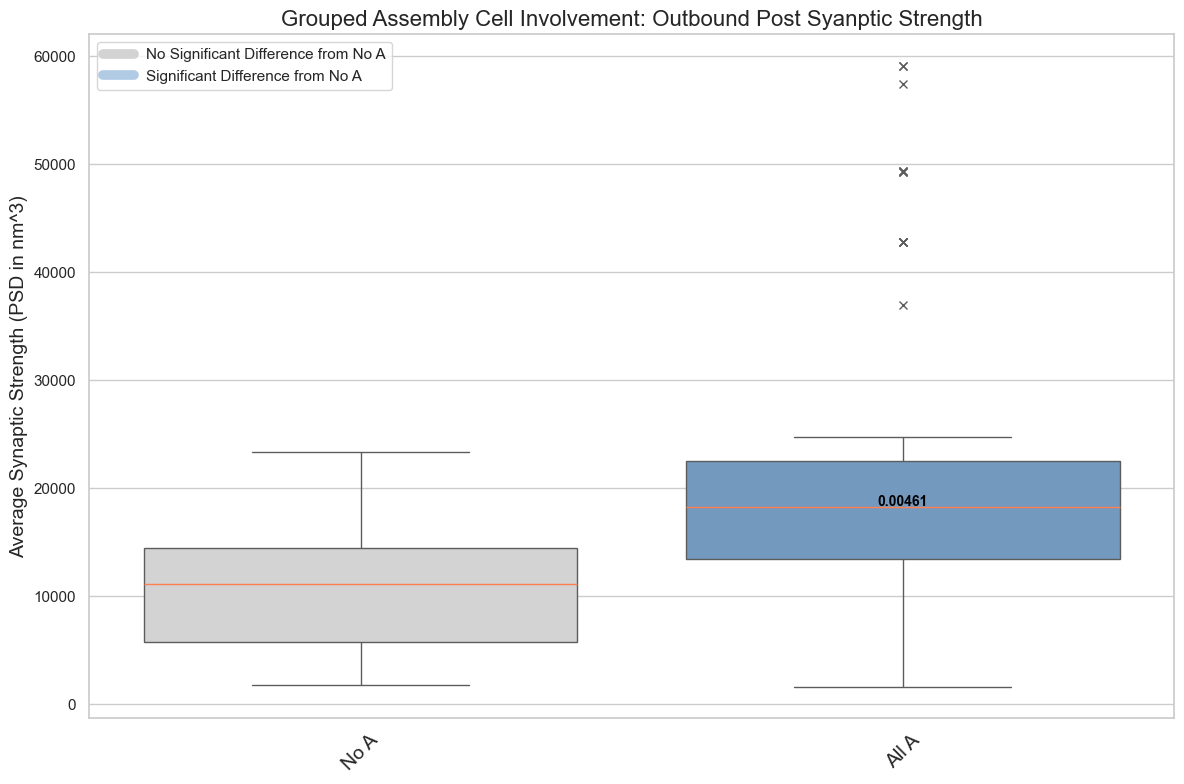

In [46]:
produce_first_order_connections_plot(input_connections_dict = grouped_outbound_averaged_psd_first_order_connections, 
                                     total_cells = average_size_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


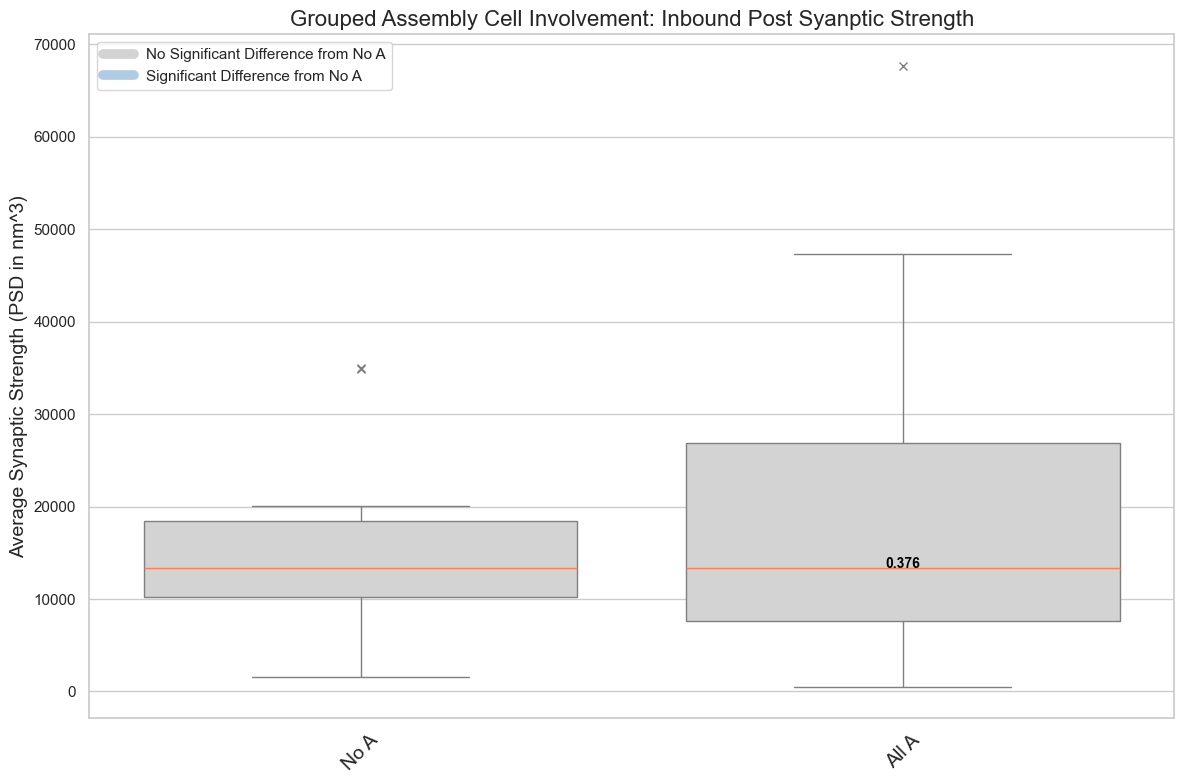

In [47]:
produce_first_order_connections_plot(input_connections_dict = grouped_inbound_averaged_psd_first_order_connections, 
                                     total_cells = average_size_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

Probability Already Normalized.
Probability Already Normalized.


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_27887/3348988887.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


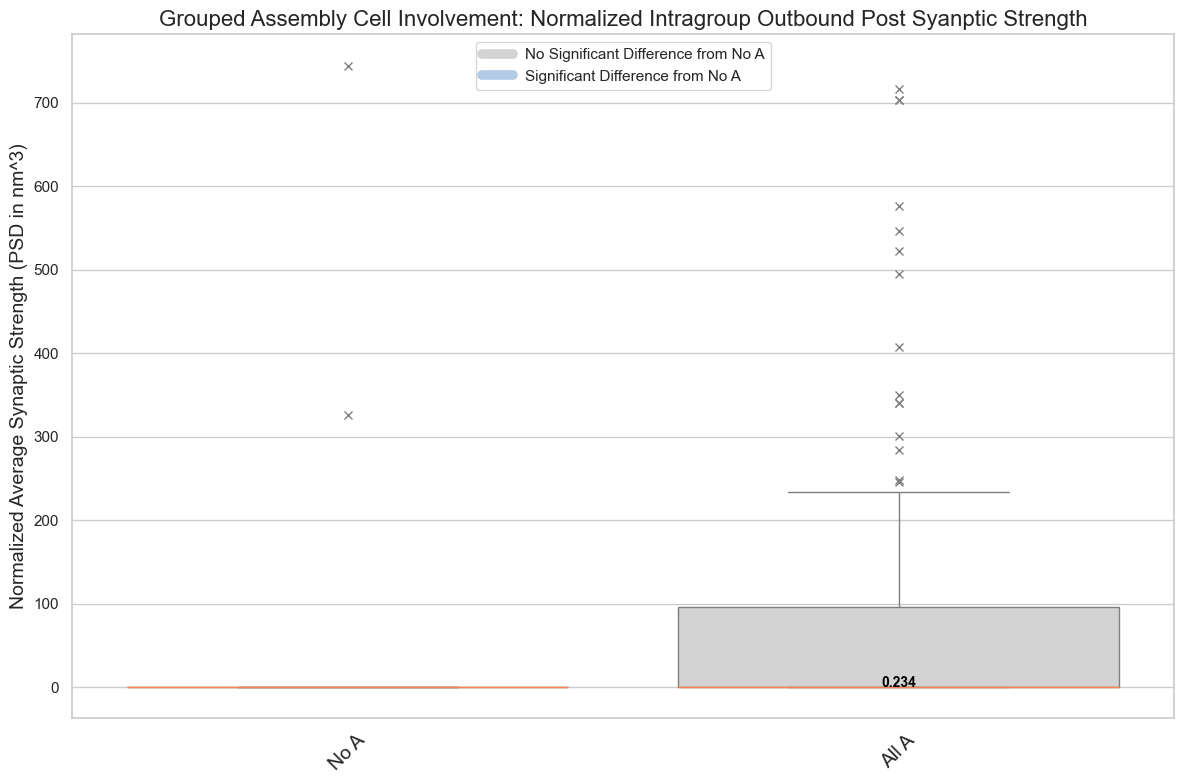

In [48]:
produce_first_order_connections_plot(input_connections_dict = grouped_intragroup_outbound_averaged_psd_first_order_connections, 
                                     total_cells = average_size_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

### Higher-Order Analysis: Min-Cost Path

In [147]:
assembly_connectome_indexes = np.array(assembly_connectome_indexes)
no_assembly_connectome_indexes = np.array(no_assembly_connectome_indexes)
print(assembly_connectome_indexes)
print(no_assembly_connectome_indexes)

[200 149   4 338 248  54 396  74 110 293 370 233 360 184 231  53  98  11
 450 166 404  25  46 247 386 426 210 150 111 198  21 357 431  73 379 121
 455 308 340  27 385 374 147]
[323 124 202 405 411 114  14 227 261 425 433  35]


In [148]:
print(binary_connectome)
print(average_size_connectome)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [149]:
# Create graph from the binary connectome, and set weights as average PSD
G = nx.DiGraph()
for i in range(binary_connectome.shape[0]):
    for j in range(binary_connectome.shape[1]):
        if binary_connectome[i, j] == 1:  # There is a connection
            # Every synapse would be noramlized by the sum of the psd values which are contirbuting to the same post-syanptic neurons
            G.add_edge(i, j, weight = -np.log(summed_size_connectome[i,j] / sum(summed_size_connectome[:,j])))

# Calculate minimum-cost paths within assembly neurons
assembly_min_cost_paths = []
for i in range(len(assembly_connectome_indexes)):
    for j in range(i + 1, len(assembly_connectome_indexes)):
        try:
            length = nx.shortest_path_length(G, source = assembly_connectome_indexes[i], target = assembly_connectome_indexes[j], weight='weight')
            assembly_min_cost_paths.append(length)
        except nx.NetworkXNoPath:
            assembly_min_cost_paths.append(np.inf)

# Calculate minimum-cost paths within non-assembly neurons
non_assembly_min_cost_paths = []
for i in range(len(no_assembly_connectome_indexes)):
    for j in range(i + 1, len(no_assembly_connectome_indexes)):
        try:
            length = nx.shortest_path_length(G, source = no_assembly_connectome_indexes[i], target = no_assembly_connectome_indexes[j], weight='weight')
            non_assembly_min_cost_paths.append(length)
        except nx.NetworkXNoPath:
            non_assembly_min_cost_paths.append(np.inf)

# Filter out np.inf values for meaningful comparisons
#assembly_min_cost_paths = [val for val in assembly_min_cost_paths if val != np.inf]
#non_assembly_min_cost_paths = [val for val in non_assembly_min_cost_paths if val != np.inf]

# Calculate and print statistics
print(f"Assembly Neurons: Mean path length = {np.mean(assembly_min_cost_paths)}, Median path length = {np.median(assembly_min_cost_paths)}")
print(f"Non-Assembly Neurons: Mean path length = {np.mean(non_assembly_min_cost_paths)}, Median path length = {np.median(non_assembly_min_cost_paths)}")

Assembly Neurons: Mean path length = 6.652541420649827, Median path length = 6.623184277930793
Non-Assembly Neurons: Mean path length = 6.558952589862719, Median path length = 6.660667058229011


Wilcox Rank-Sum:  0.46478436475356777
T-Test:  0.3490378639843179


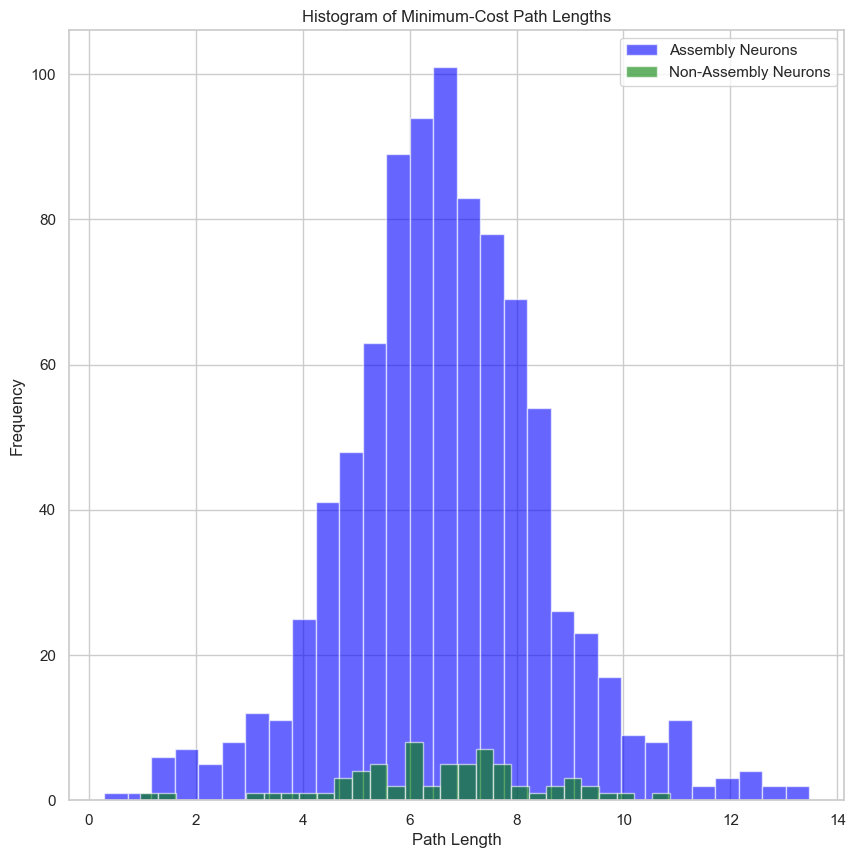

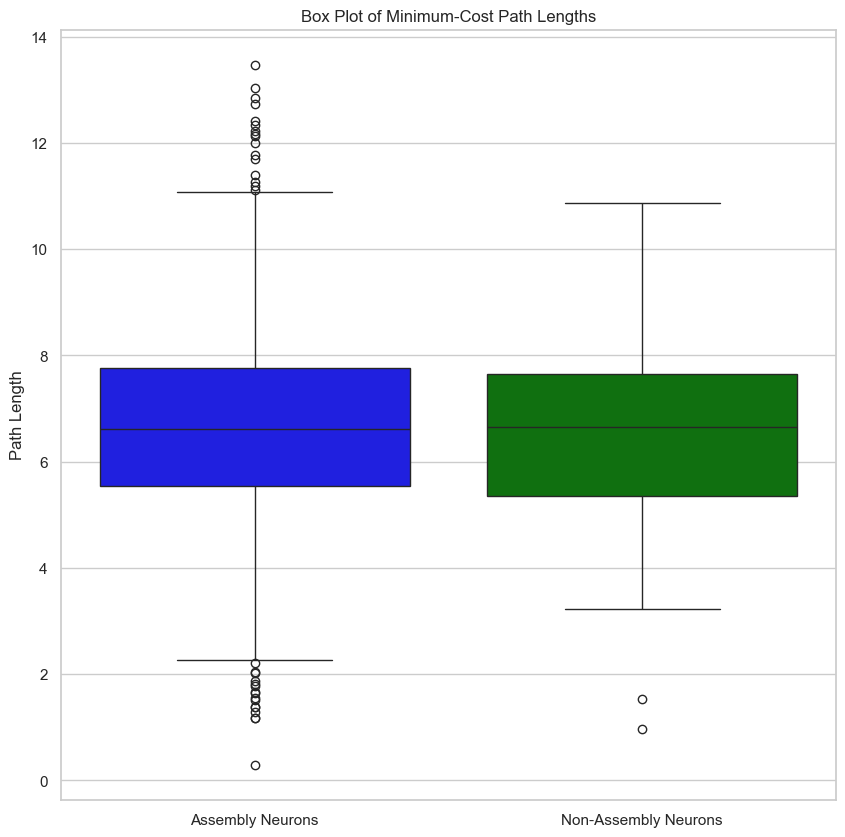

In [150]:
print("Wilcox Rank-Sum: ", stats.ranksums(assembly_min_cost_paths, non_assembly_min_cost_paths, alternative='greater').pvalue)
print("T-Test: ", stats.ttest_ind(assembly_min_cost_paths, non_assembly_min_cost_paths, alternative='greater').pvalue)

plt.hist(assembly_min_cost_paths, bins=30, color='blue', alpha=0.6, label='Assembly Neurons')
plt.hist(non_assembly_min_cost_paths, bins=30, color='green', alpha=0.6, label='Non-Assembly Neurons')
plt.title('Histogram of Minimum-Cost Path Lengths')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

sns.boxplot(data=[assembly_min_cost_paths, non_assembly_min_cost_paths], palette=['blue', 'green'])
plt.xticks([0, 1], ['Assembly Neurons', 'Non-Assembly Neurons'])
plt.title('Box Plot of Minimum-Cost Path Lengths')
plt.ylabel('Path Length')
plt.show()

In [145]:
# Create graph from the binary connectome, and set weights as average PSD
G = nx.DiGraph()
for i in range(binary_connectome.shape[0]):
    for j in range(binary_connectome.shape[1]):
        if binary_connectome[i, j] == 1:  # There is a connection
            # Every synapse would be noramlized by the sum of the psd values which are contirbuting to the same post-syanptic neurons
            G.add_edge(i, j, weight = -np.log(summed_size_connectome[i,j] / sum(summed_size_connectome[:,j])))

# Calculate minimum-cost paths within assembly neurons
assembly_min_cost_paths = []
for A in assemblies_by_coregistered:
    if A != 'No A':
        for i in range(len(assemblies_by_coregistered[A])):
            for j in range(i + 1, len(assemblies_by_coregistered[A])):
                try:
                    length = nx.shortest_path_length(G, source = assemblies_by_coregistered[A][i], target = assemblies_by_coregistered[A][j], weight='weight')
                    assembly_min_cost_paths.append(length)
                except nx.NetworkXNoPath:
                    assembly_min_cost_paths.append(np.inf)

# Calculate minimum-cost paths within non-assembly neurons
non_assembly_min_cost_paths = []
for i in range(len(no_assembly_connectome_indexes)):
    for j in range(i + 1, len(no_assembly_connectome_indexes)):
        try:
            length = nx.shortest_path_length(G, source = no_assembly_connectome_indexes[i], target = no_assembly_connectome_indexes[j], weight='weight')
            non_assembly_min_cost_paths.append(length)
        except nx.NetworkXNoPath:
            non_assembly_min_cost_paths.append(np.inf)

# Filter out np.inf values for meaningful comparisons
#assembly_min_cost_paths = [val for val in assembly_min_cost_paths if val != np.inf]
#non_assembly_min_cost_paths = [val for val in non_assembly_min_cost_paths if val != np.inf]


# Calculate and print statistics
print(f"Assembly Neurons: Intra-Group mean path length = {np.mean(assembly_min_cost_paths)}, Median path length = {np.median(assembly_min_cost_paths)}")
print(f"Non-Assembly Neurons: Intra-Group mean path length = {np.mean(non_assembly_min_cost_paths)}, Median path length = {np.median(non_assembly_min_cost_paths)}")

Assembly Neurons: Intra-Group mean path length = 6.530086798884214, Median path length = 6.47646790162727
Non-Assembly Neurons: Intra-Group mean path length = 6.558952589862719, Median path length = 6.660667058229011


Wilcox Rank-Sum:  0.6989992139776915
T-Test:  0.5458568819487276


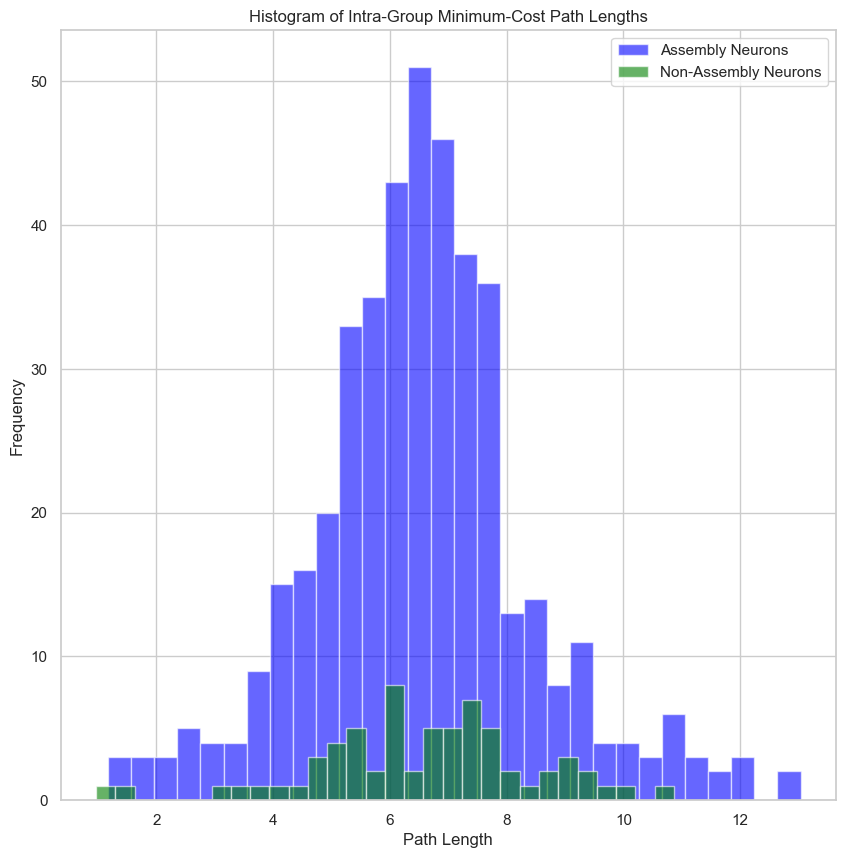

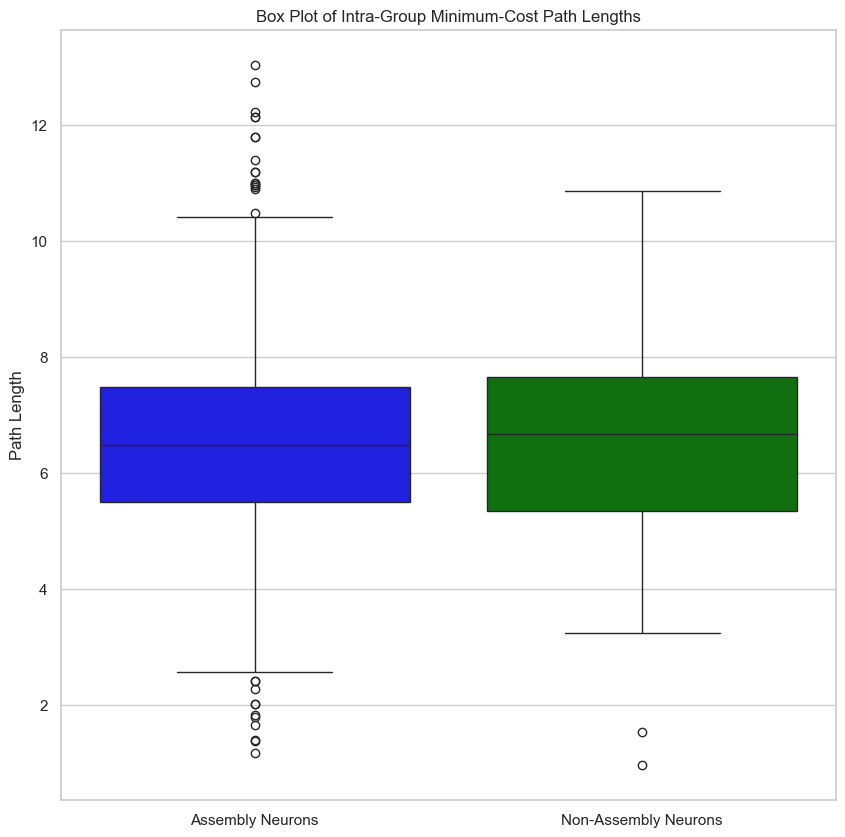

In [146]:
print("Wilcox Rank-Sum: ", stats.ranksums(assembly_min_cost_paths, non_assembly_min_cost_paths, alternative='greater').pvalue)
print("T-Test: ", stats.ttest_ind(assembly_min_cost_paths, non_assembly_min_cost_paths, alternative='greater').pvalue)

plt.hist(assembly_min_cost_paths, bins=30, color='blue', alpha=0.6, label='Assembly Neurons')
plt.hist(non_assembly_min_cost_paths, bins=30, color='green', alpha=0.6, label='Non-Assembly Neurons')
plt.title('Histogram of Intra-Group Minimum-Cost Path Lengths')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

sns.boxplot(data=[assembly_min_cost_paths, non_assembly_min_cost_paths], palette=['blue', 'green'])
plt.xticks([0, 1], ['Assembly Neurons', 'Non-Assembly Neurons'])
plt.title('Box Plot of Intra-Group Minimum-Cost Path Lengths')
plt.ylabel('Path Length')
plt.show()

### Try Bayesian Hypothesis Testing

In [ ]:
def bayesian_hypothesis_group_testing(connections_dict: dict, directionality: str, psd = False):

    suffix = f"{directionality} Summed Post Syanptic Strength" if psd else f"{directionality} First-Order Connectivity"
    lab = f"{directionality} Summed Synaptic Strength (PSD)" if psd else f"{directionality} First-Order Connections"
    
    connectivity = {key: val for key, val in connections_dict.items() if len(val) >= 5}

    empirical_mean_diffs = [np.mean(val) - np.mean(connectivity['No A']) for key, val in connectivity.items() if key != 'No A']

    # The data doesn’t follow a normal distribution, so we apply non-parametric likelihood of kernel density estimation (KDE).
    def likelihood(mean_diff, assembly_data, non_assembly_data):
        likelihoods = []
        for assembly in assembly_data:
            kde_assembly = stats.gaussian_kde(assembly + mean_diff)
            kde_non_assembly = stats.gaussian_kde(non_assembly_data)
            likelihood_assembly = kde_assembly.evaluate(assembly)
            likelihood_non_assembly = kde_non_assembly.evaluate(non_assembly_data)
            likelihoods.append(np.sum(np.log(likelihood_assembly)) + np.sum(np.log(likelihood_non_assembly)))
        return np.sum(likelihoods)


    # Set a uniform prior over a reasonable range of mean differences
    def prior(mean_diff):
        return stats.uniform(np.min(empirical_mean_diffs), np.max(empirical_mean_diffs)).pdf(mean_diff)

    # The posterior is the product of the prior and likelihood.
    def posterior(mean_diff, assembly_data, non_assembly_data):
        return prior(mean_diff) * likelihood(mean_diff, assembly_data, non_assembly_data)

    # Generate a range of mean differences and calculate the posterior for each.
    define_range = np.mean(empirical_mean_diffs) + 4*np.std(empirical_mean_diffs)
    mean_diffs = np.linspace(-define_range, define_range, 100)
    posteriors = np.array([posterior(md, [connectivity[key] for key in connectivity.keys()], connectivity["No A"]) for md in mean_diffs])
    posteriors /= np.sum(posteriors)  # Normalize

    bf = np.sum(posteriors[mean_diffs > 0]) / np.sum(posteriors[mean_diffs <= 0])
    print(f"Bayes Factor: {bf}")

    if bf > 1:
        print("Evidence supports the hypothesis that the assembly datasets have a higher mean connectivity than the non_assemblies.")
    else:
        print("Evidence supports the hypothesis that the assembly datasets do not have a higher mean connectivity.")

    credible_interval = np.percentile(mean_diffs, [2.5, 97.5])
    plt.plot(mean_diffs, posteriors, label="Posterior distribution")
    plt.axvline(credible_interval[0], color='red', linestyle='--', label="2.5% credible interval")
    plt.axvline(credible_interval[1], color='red', linestyle='--', label="97.5% credible interval")
    plt.xlabel(f"Mean Difference in {lab}")
    plt.ylabel("Posterior Probability")
    plt.legend()
    plt.show()

    data = [connectivity["No A"]] + [connectivity[key] for key in connectivity.keys() if key != 'No A']

    labels = ["No A"] + [key for key in connectivity.keys() if key != 'No A']

    plt.boxplot(data, labels=labels)
    plt.xlabel("Sets")
    plt.ylabel(lab)
    plt.title(f"Boxplot of {lab} Across Sets")
    plt.xticks(rotation=45)
    plt.show()

    for key in connectivity.keys():
        if key != 'No A':
            sns.kdeplot(connectivity[key], label= key)
    sns.kdeplot(connectivity["No A"], label="No A", color='k')
    plt.xlabel(lab)
    plt.ylabel("Density")
    plt.legend()
    plt.title(f"Density Plot of Connectivity Values: {suffix}")
    plt.show()

In [ ]:
def bayesian_hypothesis_individual_testing(connections_dict: dict, directionality = "None", psd = False):

    suffix = f"{directionality} Post Syanptic Strength" if psd else f"{directionality} First-Order Connectivity"
    lab = f"{directionality} Synaptic Strength (PSD)" if psd else f"{directionality} First-Order Connections"
    
    connectivity = {key: val for key, val in connections_dict.items() if len(val) >= 5}

    empirical_mean_diffs = [np.mean(val) - np.mean(connectivity['No A']) for key, val in connectivity.items() if key != 'No A']

    # The data doesn’t follow a normal distribution, so we apply non-parametric likelihood of kernel density estimation (KDE).
    def likelihood(mean_diff, assembly_data, non_assembly_data):
        likelihoods = []
        for assembly in assembly_data:
            kde_assembly = stats.gaussian_kde(assembly + mean_diff)
            kde_non_assembly = stats.gaussian_kde(non_assembly_data)
            likelihood_assembly = kde_assembly.evaluate(assembly)
            likelihood_non_assembly = kde_non_assembly.evaluate(non_assembly_data)
            likelihoods.append(np.sum(np.log(likelihood_assembly)) + np.sum(np.log(likelihood_non_assembly)))
        return np.sum(likelihoods)


    # Set a uniform prior over a reasonable range of mean differences based on empirical results
    def prior(mean_diff):
        return stats.uniform(np.min(empirical_mean_diffs), np.max(empirical_mean_diffs)).pdf(mean_diff)

    # The posterior is the product of the prior and likelihood.
    def posterior(mean_diff, assembly_data, non_assembly_data):
        return prior(mean_diff) * likelihood(mean_diff, assembly_data, non_assembly_data)

    # Generate a range of mean differences and calculate the posterior for each.
    bayes_factors = {}
    for key in connectivity.keys(): 
        if key != 'No A':
            define_range = np.mean(empirical_mean_diffs) + 4*np.std(empirical_mean_diffs)
            mean_diffs = np.linspace(-define_range, define_range, 100)
            posteriors = np.array([posterior(md, [connectivity[key]], connectivity["No A"]) for md in mean_diffs])
            posteriors /= np.sum(posteriors)
            bf = np.sum(posteriors[mean_diffs > 0]) / np.sum(posteriors[mean_diffs <= 0])
            bayes_factors[key] = [bf, mean_diffs, posteriors]
            print(f"{key}: Bayes Factor = {bf}")


    for key in bayes_factors.keys():
        plt.plot(bayes_factors[key][1], bayes_factors[key][2], label=f"{key}: Posterior with BF of {bayes_factors[key][0]:.2f}")
    credible_interval = np.percentile(bayes_factors[key][1], [2.5, 97.5])
    plt.axvline(credible_interval[0], color='red', linestyle='--', label="2.5% credible interval")
    plt.axvline(credible_interval[1], color='red', linestyle='--', label="97.5% credible interval")
    plt.xlabel(f"Mean Difference in {lab}")
    plt.ylabel("Posterior Probability")
    plt.legend()
    plt.show()

Bayes Factor: 12.858052456852505
Evidence supports the hypothesis that the assembly datasets have a higher mean connectivity than the non_assemblies.


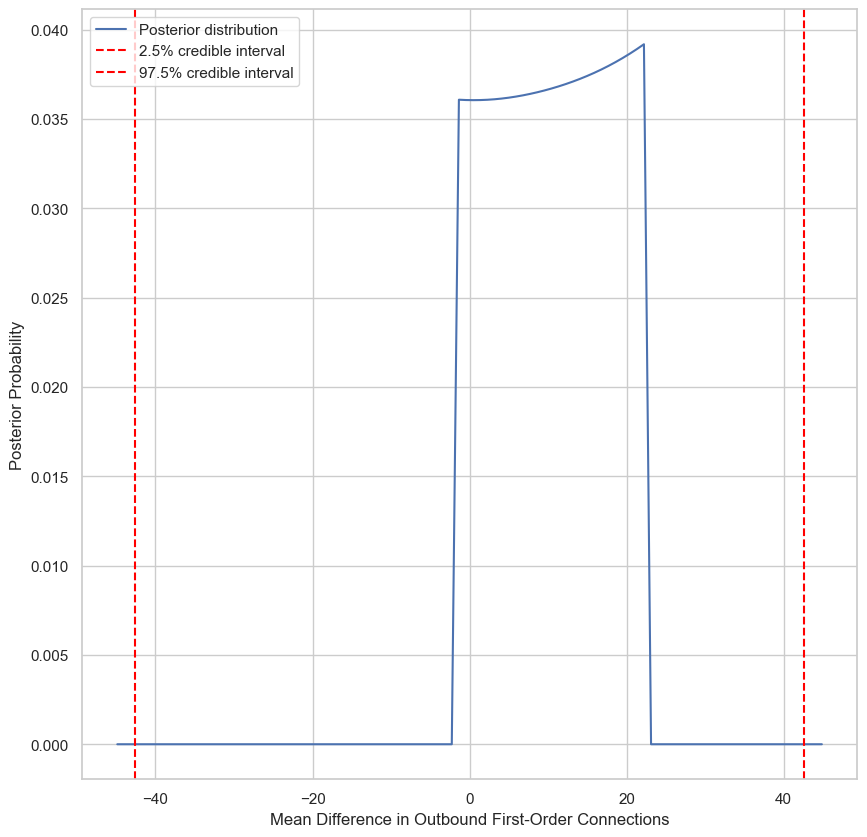

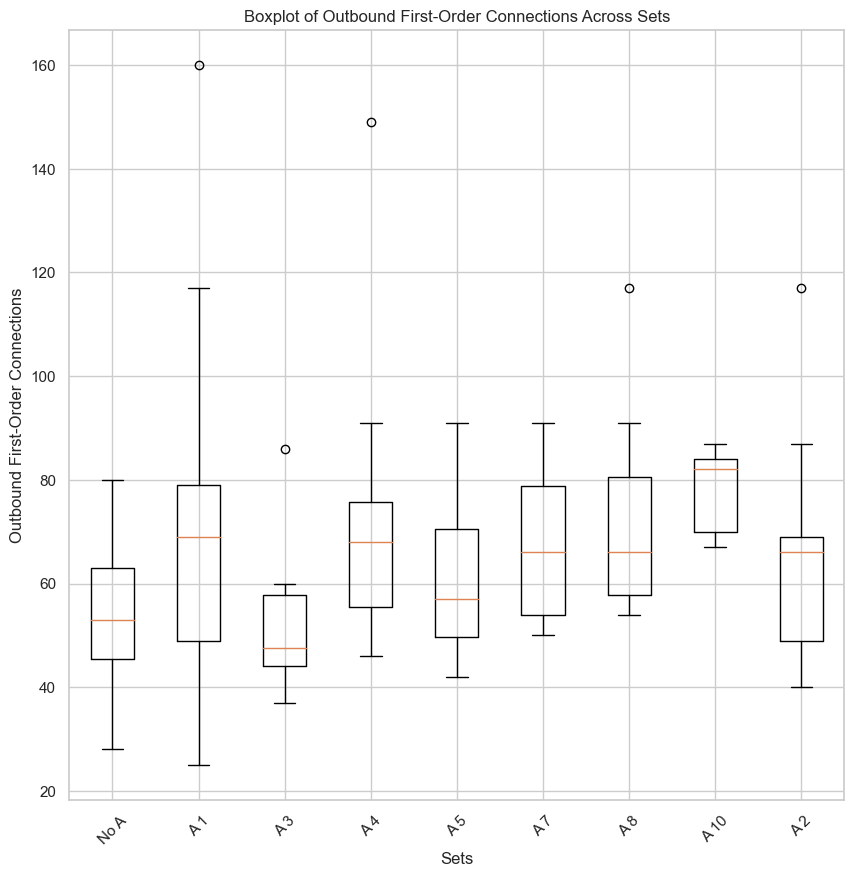

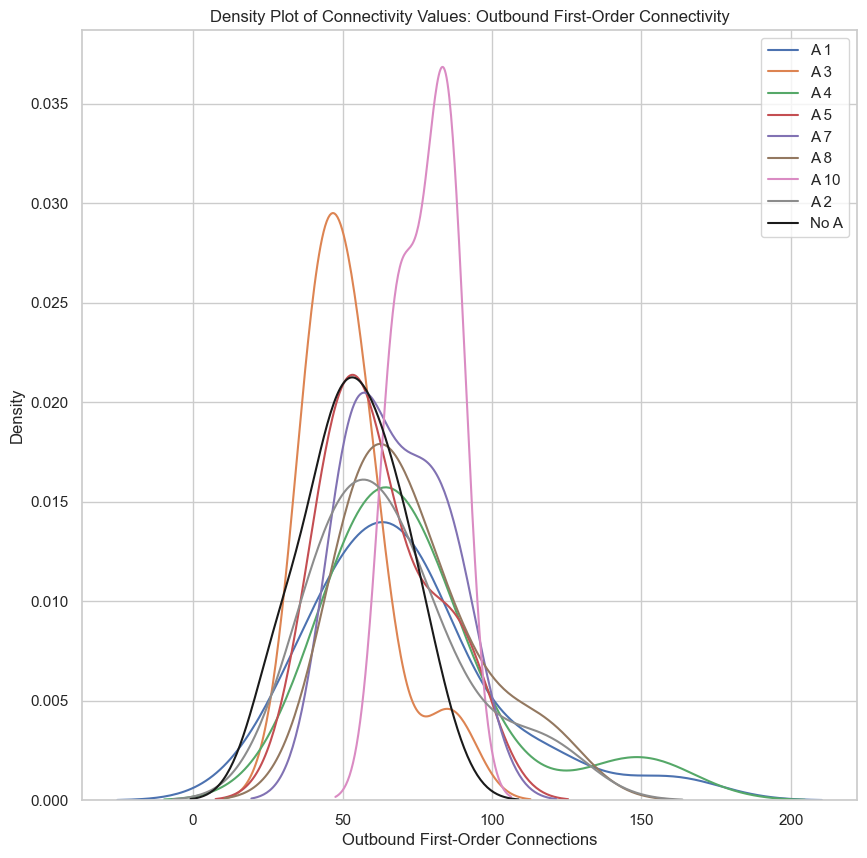

In [ ]:
bayesian_hypothesis_group_testing(connections_dict=outbound_first_order_connections, 
                                  directionality="Outbound",
                                  psd = False)

A 1: Bayes Factor = 12.681357415994329
A 3: Bayes Factor = 13.238874045842682
A 4: Bayes Factor = 12.698716487881097
A 5: Bayes Factor = 12.827770764283542
A 7: Bayes Factor = 12.892770342562638
A 8: Bayes Factor = 12.67339423703694
A 10: Bayes Factor = 13.402749549758113
A 2: Bayes Factor = 12.654628876309223


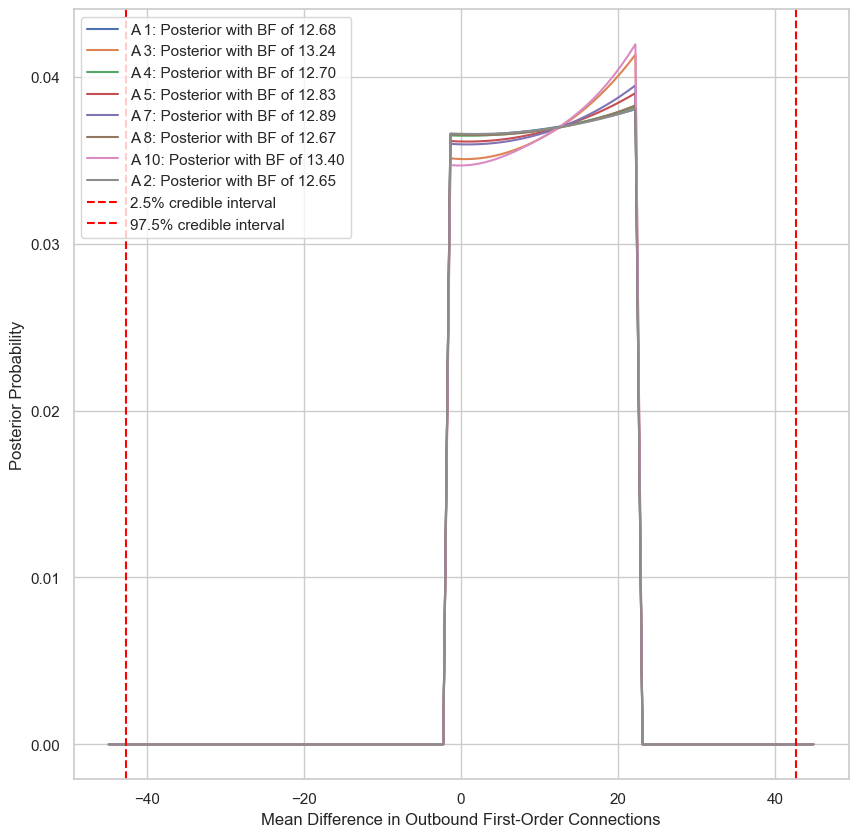

In [ ]:
bayesian_hypothesis_individual_testing(connections_dict=outbound_first_order_connections, 
                                       directionality="Outbound",
                                       psd = False)

Bayes Factor: 0.0
Evidence supports the hypothesis that the assembly datasets do not have a higher mean connectivity.


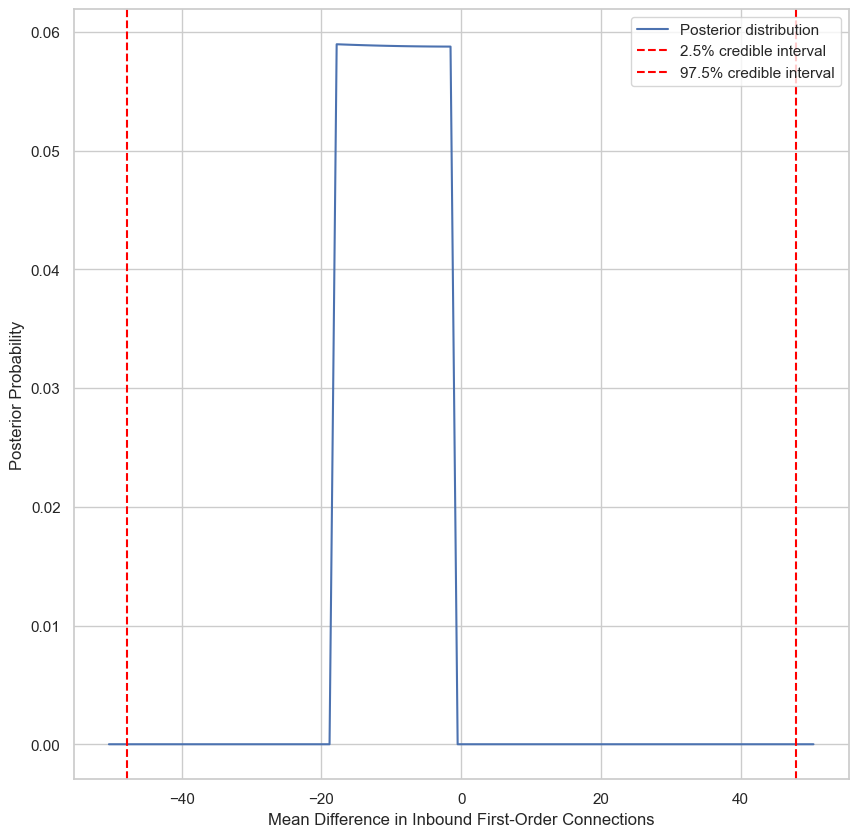

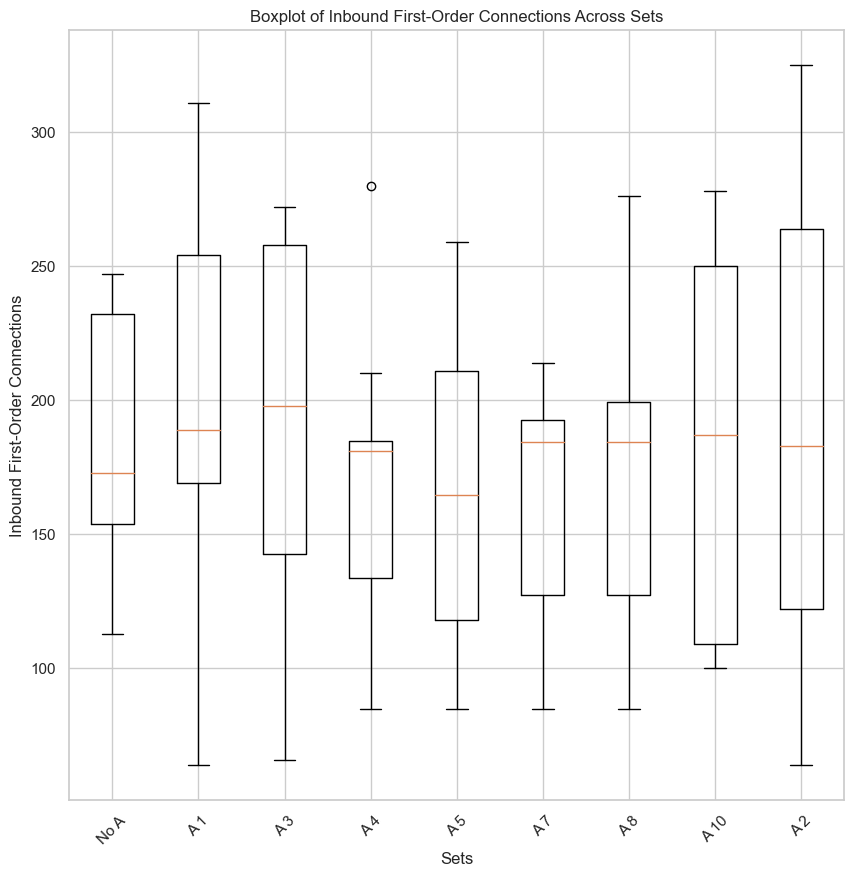

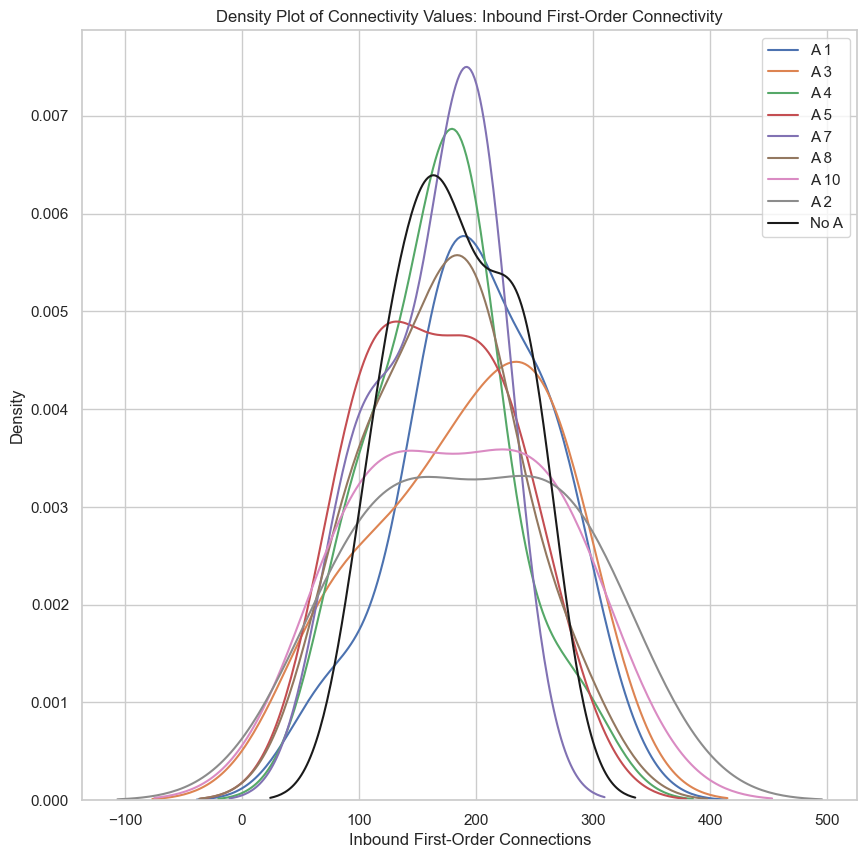

In [ ]:
bayesian_hypothesis_group_testing(connections_dict=inbound_first_order_connections, 
                                  directionality="Inbound",
                                  psd = False)

Bayes Factor: 27.316376515897183
Evidence supports the hypothesis that the assembly datasets have a higher mean connectivity than the non_assemblies.


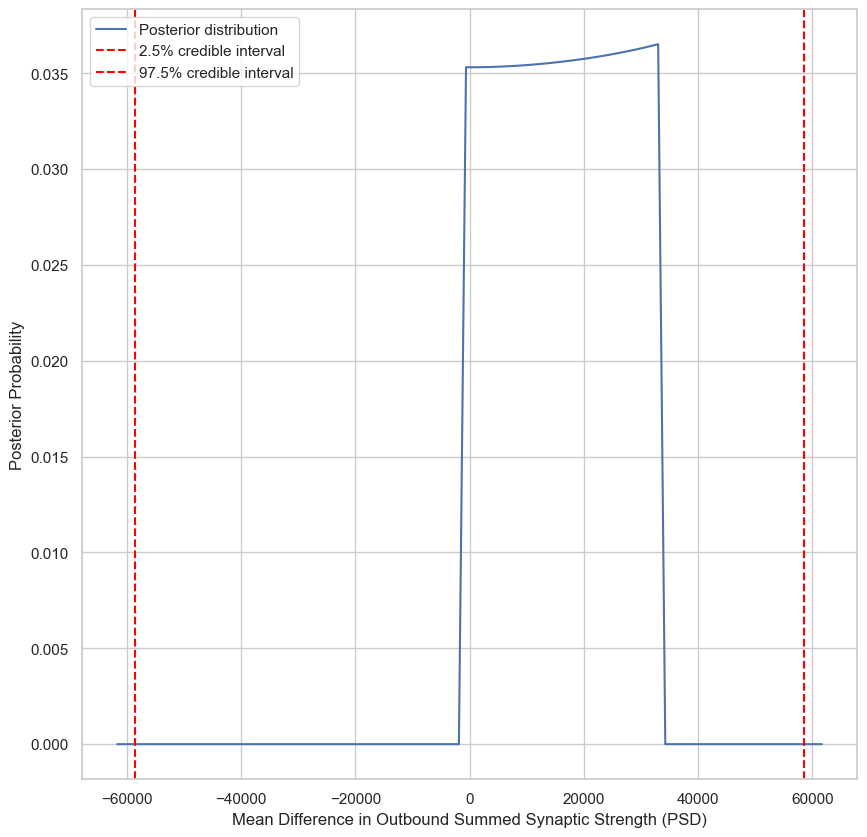

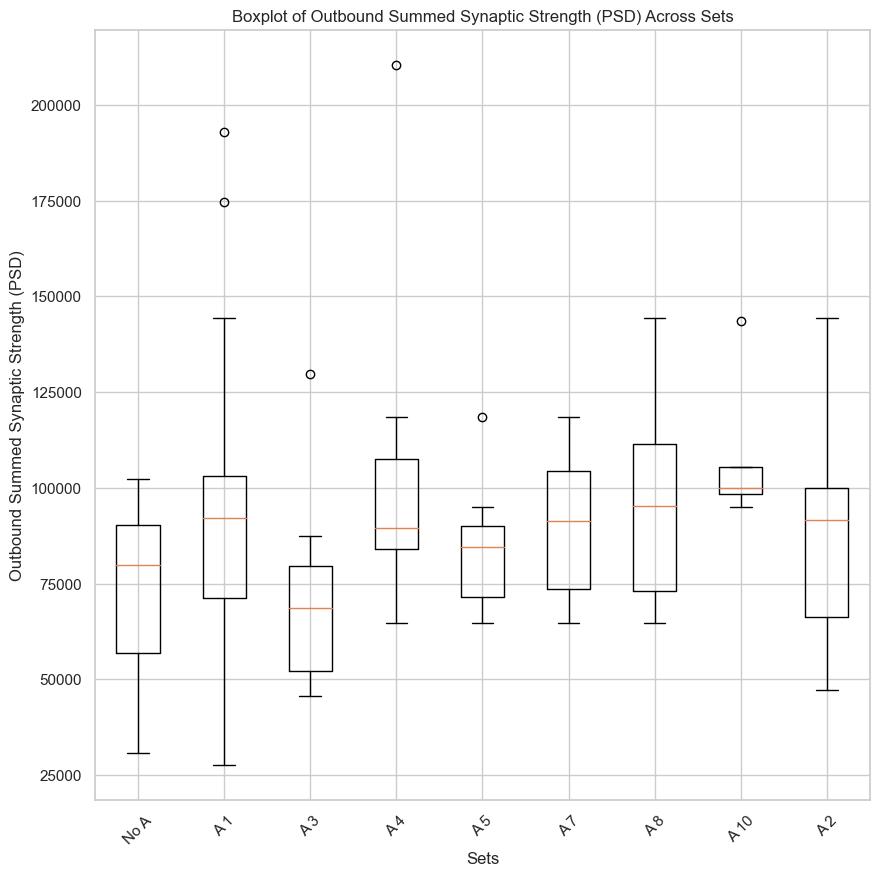

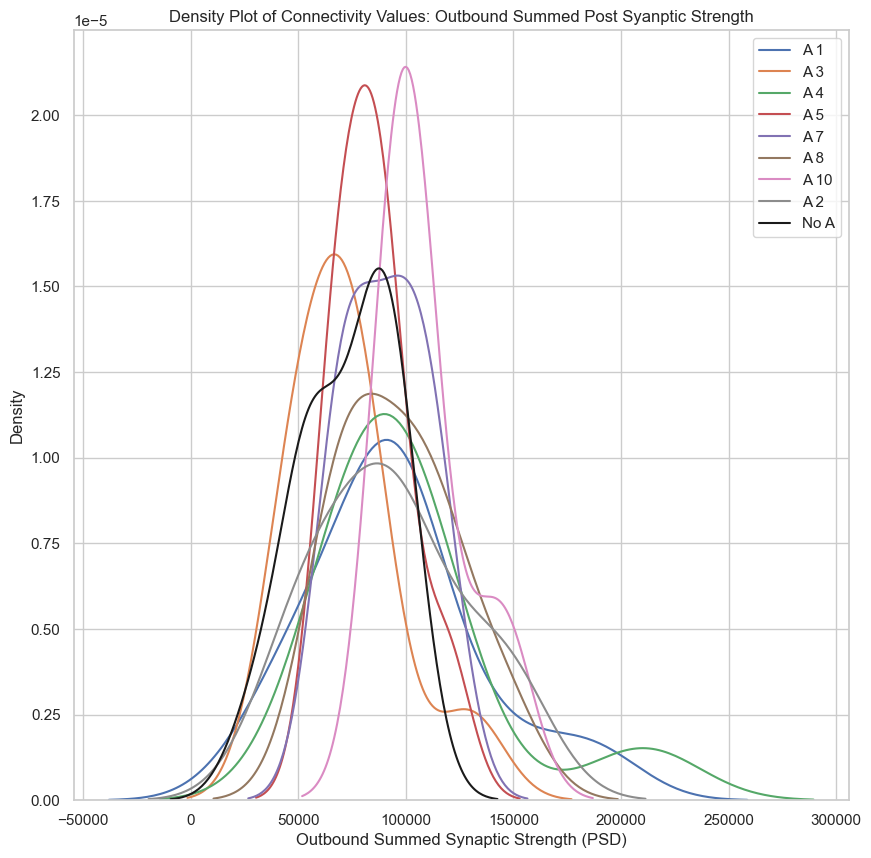

In [ ]:
bayesian_hypothesis_group_testing(connections_dict=outbound_psd_first_order_connections, 
                                  directionality="Outbound",
                                  psd = True)

### Dot-Motif Chain Motif Analysis

In [90]:
# Import Stefan's Library for Data Management of V1DD
from LSMMData.data_management import LSMMData

with open('v1dd_wrangler_input_dict.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
tables = my_data.data
params = my_data.params
dirs = my_data.dirs
mappings = my_data.mappings

In [91]:
assemblies_by_coregistered = invert_dict(mappings['assemblies_by_connectome_index'])

counter = len({item for val in assemblies_by_coregistered.values() if val is not None for item in val})

print("Total Number of Neurons that are Coregistered & Assigned to Assemblies:", counter)
print("Total Number of Neurons that are Coregistered & Assigned to No Assemblies:", len(assemblies_by_coregistered['No A']))
for key, val in assemblies_by_coregistered.items():
    print(key,":", val)
#assemblies_by_coregistered

Total Number of Neurons that are Coregistered & Assigned to Assemblies: 55
Total Number of Neurons that are Coregistered & Assigned to No Assemblies: 12
A 1 : [377, 303, 10, 630, 458, 126, 749, 162, 225, 535, 701, 429, 663, 353, 425, 125, 201, 27, 837, 329, 763]
A 3 : [303, 458, 535, 429, 663, 27, 763, 304, 229, 374]
A 4 : [303, 749, 162, 125, 27, 800, 52, 659, 806, 161]
A 5 : [303, 630, 429, 800, 806, 161, 715, 243]
A 7 : [303, 630, 749, 162, 229, 806, 161, 715]
A 8 : [303, 749, 162, 225, 763, 229, 806, 161]
A 10 : [630, 730, 391, 73, 728]
A 2 : [225, 663, 837, 68, 109, 454, 730, 800, 391]
A 6 : [353, 201, 329, 845]
A 11 : [68]
A 9 : [563, 633]
A 12 : [563]
A 13 : [710]
A 15 : [710]
A 14 : [298]
No A : [597, 255, 379, 764, 770, 234, 34, 419, 484, 799, 808, 89]


In [92]:
### Check that this is the most updated dot motif file
three_chain_dot_motif_result = pd.read_pickle("./dot_motif_results/pyc_three_chain_results.pickle")

max_idx = max([max(d.values()) for d in three_chain_dot_motif_result])
max_idx

851

In [93]:
def enumerate_chain_motifs(dot_motif_dict, A_by_coregistered, assemblies: bool):
    # initialize dataframe
    dot_motif_dict_df = pd.DataFrame(dot_motif_dict)

    # initialize data frames for keeping track of chain motifs
    chains_w_A = pd.DataFrame()
    chains_w_B = pd.DataFrame()
    chains_w_C = pd.DataFrame()

    if assemblies:
        connectome_ids = {id for assignment in A_by_coregistered if assignment != 'No A' for id in A_by_coregistered[assignment]}
        connectome_ids = np.sort(list(connectome_ids))
    else:
        connectome_ids = A_by_coregistered['No A']

    for connectome_id in connectome_ids:
        # we check if the first or third position is an connectome_id assigned to an assembly
        mask = dot_motif_dict_df['A'] == connectome_id
        A = dot_motif_dict_df[mask]
        chains_w_A = pd.concat([chains_w_A, A], ignore_index=True)

        mask = dot_motif_dict_df['B'] == connectome_id
        B = dot_motif_dict_df[mask]
        chains_w_B = pd.concat([chains_w_B, B], ignore_index=True)

        mask = dot_motif_dict_df['C'] == connectome_id
        C = dot_motif_dict_df[mask]
        chains_w_C = pd.concat([chains_w_C, C], ignore_index=True)
    
    # keep track of assigned cell ids
    chains_w_A['assembly_cell_id'] = chains_w_A['A']
    # chains_w_B['assembly_cell_id'] = chains_w_B['B']
    chains_w_C['assembly_cell_id'] = chains_w_C['C']

    # combine all information to one data frame
    all_motifs = pd.DataFrame(pd.concat([chains_w_A,chains_w_B,chains_w_C]))
    return all_motifs

In [94]:
len(three_chain_dot_motif_result)

6052393

In [95]:
assembly_motifs = enumerate_chain_motifs(three_chain_dot_motif_result, assemblies_by_coregistered, assemblies = True)
assembly_motifs

,A,B,C,assembly_cell_id
0,10,3,5,10.0
1,10,3,11,10.0
2,10,3,13,10.0
3,10,3,29,10.0
4,10,3,30,10.0
...,...,...,...,...
391733,850,669,845,845.0
391734,850,841,845,845.0
391735,851,595,845,845.0
391736,851,669,845,845.0


In [96]:
no_assembly_motifs = enumerate_chain_motifs(three_chain_dot_motif_result, assemblies_by_coregistered, assemblies = False)
no_assembly_motifs

,A,B,C,assembly_cell_id
0,597,2,6,597.0
1,597,2,35,597.0
2,597,2,36,597.0
3,597,2,44,597.0
4,597,2,45,597.0
...,...,...,...,...
105898,850,455,89,89.0
105899,850,574,89,89.0
105900,850,668,89,89.0
105901,851,595,89,89.0


assembly_cell_id
377.0    26205
126.0    25497
52.0     24663
225.0    23639
563.0    23401
535.0    20571
728.0    19986
10.0     19296
458.0    19222
715.0    19136
630.0    19085
162.0    19030
429.0    18867
730.0    18805
749.0    18350
125.0    18149
454.0    18119
763.0    18110
201.0    18073
663.0    17851
109.0    16782
425.0    16705
806.0    16699
800.0    14561
304.0    14436
27.0     14387
710.0    14149
391.0    14058
161.0    13968
229.0    13911
659.0    13821
68.0     13498
303.0    12942
329.0    12848
73.0     12659
845.0    12475
701.0    12466
298.0    12121
633.0    10965
837.0    10925
243.0    10292
353.0     9671
374.0     6890
Name: count, dtype: int64
assembly_cell_id
255.0    20371
234.0    19525
764.0    17759
34.0     17453
770.0    16521
379.0    16370
484.0    15848
808.0    13647
89.0     12342
597.0    12337
419.0    11932
799.0     8390
Name: count, dtype: int64


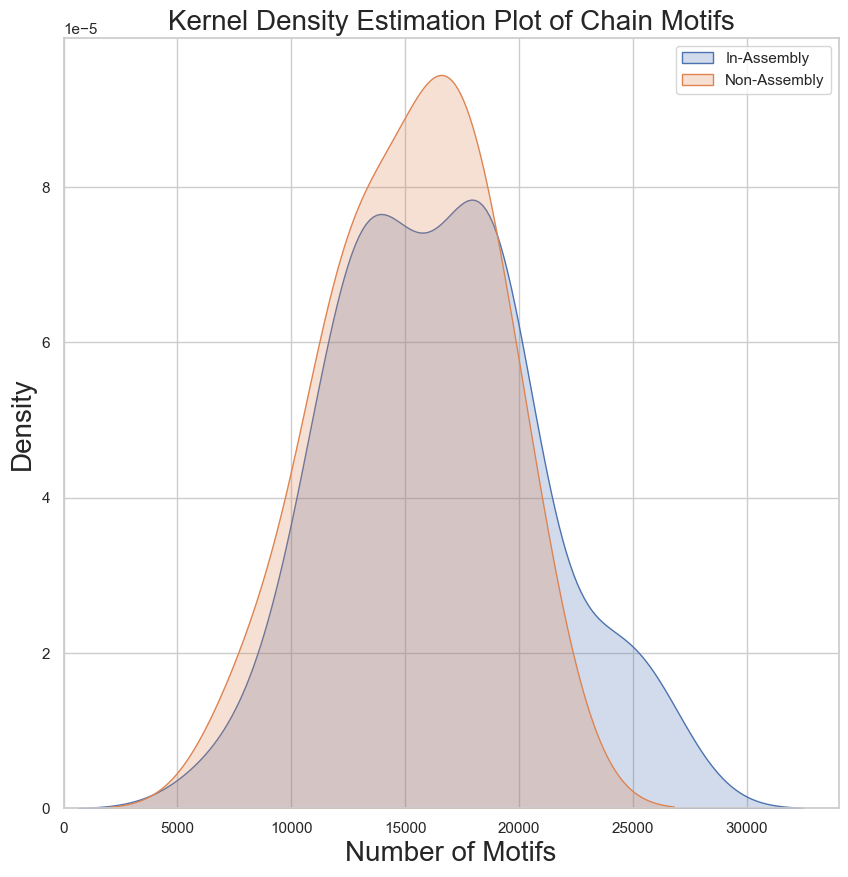

In [97]:
### define the assembly counts
assembly_counts = assembly_motifs['assembly_cell_id'].value_counts()
print(assembly_counts)

### define the non_assembly counts
non_assembly_counts = no_assembly_motifs['assembly_cell_id'].value_counts()
print(non_assembly_counts)

### See the general distribution of the assembly counts to justify the statistical test
## In-assemlby test is bi-modal, so t-test wouldn't be the best to use 
sns.kdeplot(assembly_counts, fill = True, label = 'In-Assembly')
sns.kdeplot(non_assembly_counts, fill = True, label = 'Non-Assembly')
plt.legend()
plt.title('Kernel Density Estimation Plot of Chain Motifs', size = 20)
plt.xlabel('Number of Motifs', size = 20)
plt.ylabel('Density', size = 20)
plt.xlim(0)
plt.show()

In [98]:
print(np.mean(assembly_counts), np.mean(non_assembly_counts))
print(np.median(assembly_counts), np.median(non_assembly_counts))
print(np.std(assembly_counts), np.std(non_assembly_counts))

16448.46511627907 15207.916666666666
16705.0 16109.0
4355.905920508156 3371.882695130752


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_78538/2160557870.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Neurons In Assemblies", "Neurons Outside Assemblies"], size = 16)


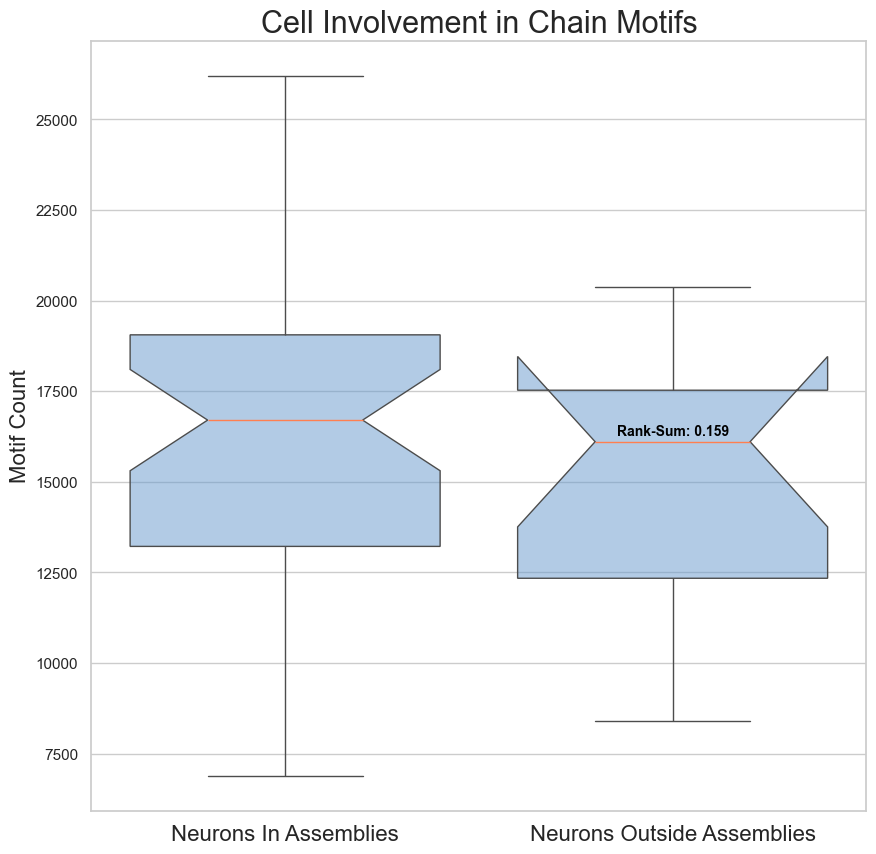

In [99]:
all_arr = [np.array(assembly_counts).flatten(),
            np.array(non_assembly_counts).flatten()]
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=all_arr,
                notch=True, showcaps=True,
                flierprops={"marker": "x"},
                boxprops={"facecolor": (.4, .6, .8, .5)},
                medianprops={"color": "coral"},
            )
ax.set_xticklabels(["Neurons In Assemblies", "Neurons Outside Assemblies"], size = 16)
ax.set_title('Cell Involvement in Chain Motifs', size = 22)
ax.set_ylabel('Motif Count', size = 16)

medians = np.array(
    [np.median(np.array(assembly_counts).flatten()),
     np.median(np.array(non_assembly_counts).flatten())]
)

vertical_offset = medians * 0.01 # offset from median for display
p_values = [np.nan,
            'Rank-Sum: {:.3g}'.format(stats.ranksums(np.array(assembly_counts).flatten(), np.array(non_assembly_counts).flatten(), 'greater').pvalue, 5)]

for xtick in ax.get_xticks():
    if xtick != 0:
        ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick], 
                horizontalalignment='center', size='small', color='black', weight='semibold')

#plt.savefig('dot_motif_three_chain_boxplot.png', dpi = 1200)
plt.show()

### Stefan's Implementation of Chain Count Participation

In [85]:
def motif_produce_boxplot(chain_results, just_pyramidal: bool, chain_num: int):
    coregistered_cell_indexes = mappings['assemblies_by_connectome_index'].keys()
    no_a_cell_indexes = mappings['connectome_indexes_by_assembly']['No A']

    # Get chain participation
    chain_participation_by_coregistered_cell = {}
    for index in coregistered_cell_indexes:
        # this only works because the index cannot appear in the same chain more than once
        chain_participation_by_coregistered_cell[index] = np.where(chain_results == index)[0].size

    pooled_assembly_indexes = list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))

    # Pool cells which are in assemblies
    pooled_assembly_cell_participation = []
    for index in pooled_assembly_indexes:
        pooled_assembly_cell_participation.append(chain_participation_by_coregistered_cell[index])

    # Pool cells which are not in assemblies
    no_a_cell_participation = []
    for index in no_a_cell_indexes:
        no_a_cell_participation.append(chain_participation_by_coregistered_cell[index])

    plt.figure()
    plt.box
    plt.boxplot([pooled_assembly_cell_participation, no_a_cell_participation])
    if just_pyramidal:
        title = f"Pyramidal Cells with Chain Length of {chain_num}"
    else:
        title = f"All Cells with Chain Length of {chain_num}"
    plt.title(title)
    #plt.savefig('pyr_cell_chain_participation.png')

    print('A', pooled_assembly_cell_participation)
    print('No A', no_a_cell_participation)
    print('Mean A:', np.mean(pooled_assembly_cell_participation), 'Median A:', np.median(pooled_assembly_cell_participation))
    print('Mean No A:', np.mean(no_a_cell_participation), 'Median No A:', np.median(no_a_cell_participation))
    print('Done')
    print('Rank-Sum Test:', stats.ranksums(np.array(pooled_assembly_cell_participation).flatten(), np.array(no_a_cell_participation).flatten(), 'greater').pvalue)

In [86]:
all_cells_three_chain_results_array = np.load("dot_motif_results/all_cell_three_chain_results_array.npy")
pyr_cells_three_chain_results_array = np.load("dot_motif_results/pyr_cell_three_chain_results_array.npy")
all_cells_four_chain_results_array = np.load("dot_motif_results/all_cell_four_chain_results_array.npy")
pyr_cells_four_chain_results_array = np.load("dot_motif_results/pyr_cell_four_chain_results_array.npy")

In [11]:
# Import Stefan's Library for Data Management of V1DD
from LSMMData.data_management import LSMMData

with open('v1dd_wrangler_input_dict.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
tables = my_data.data
params = my_data.params
dirs = my_data.dirs
mappings = my_data.mappings

A [17225, 23393, 16374, 20828, 27482, 17062, 17207, 17048, 23615, 19918, 20131, 14157, 22590, 15607, 17088, 31449, 33525, 14567, 15669, 13060, 21945, 16874, 21946, 22744, 15790, 23672, 14985, 15240, 24755, 23006, 31538, 10623, 16342, 23084, 20079, 12522, 12079, 23765, 7637, 35135, 22019, 22103, 33155]
No A [13847, 25336, 19646, 21742, 19608, 24500, 21411, 14024, 18407, 9280, 16332, 14471]
Mean A: 20210.06976744186 Median A: 20079.0
Mean No A: 18217.0 Median No A: 19007.5
Done
Rank-Sum Test: 0.16399587359726192


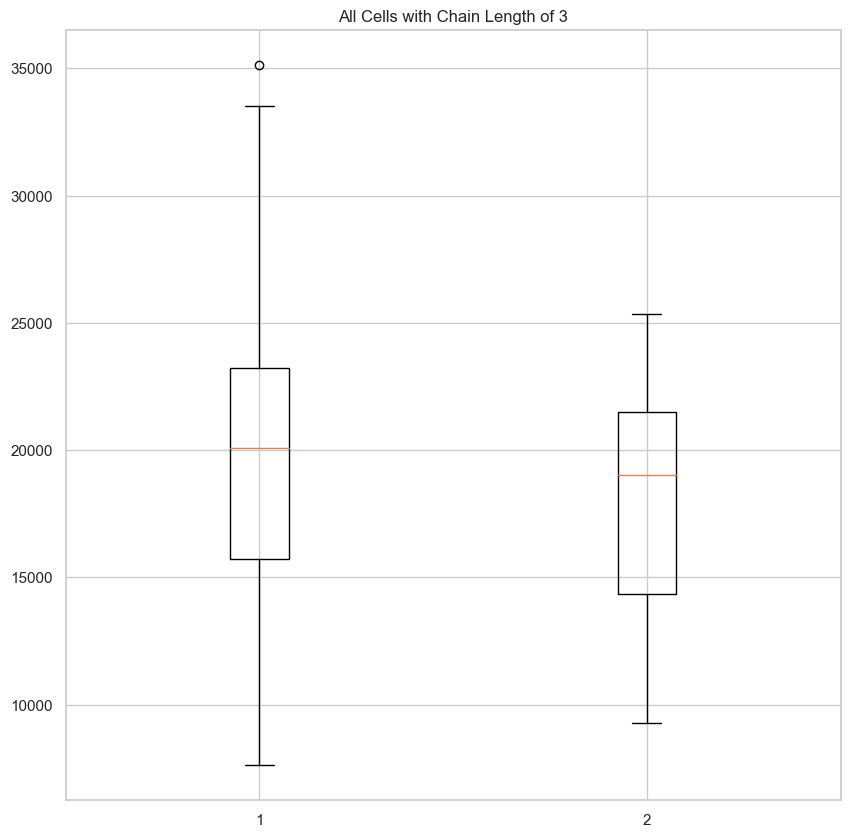

In [87]:
motif_produce_boxplot(all_cells_three_chain_results_array, just_pyramidal = False, chain_num = 3)

A [249, 324, 0, 0, 0, 131, 0, 167, 59, 0, 70, 623, 689, 137, 449, 0, 666, 0, 277, 0, 70, 0, 178, 419, 237, 0, 0, 254, 0, 0, 246, 110, 505, 0, 765, 0, 435, 0, 105, 34, 0, 292, 41]
No A [0, 416, 195, 0, 0, 145, 48, 195, 0, 0, 0, 737]
Mean A: 175.1627906976744 Median A: 70.0
Mean No A: 144.66666666666666 Median No A: 24.0
Done
Rank-Sum Test: 0.2772682908352456


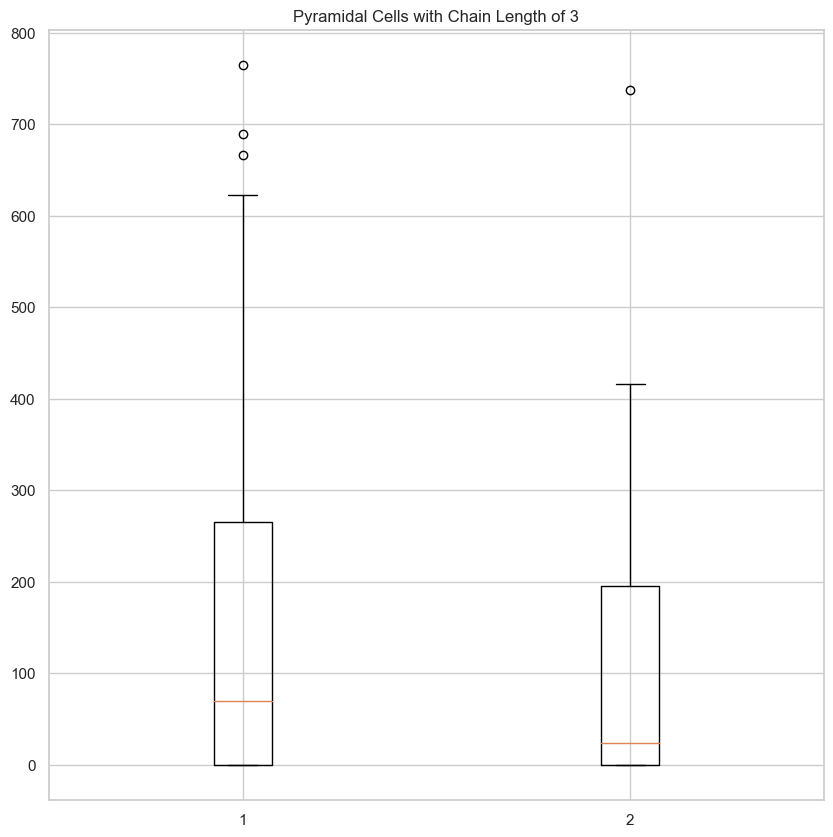

In [88]:
motif_produce_boxplot(pyr_cells_three_chain_results_array, just_pyramidal = True, chain_num = 3)

In [ ]:
motif_produce_boxplot(all_cells_four_chain_results_array, just_pyramidal = False, chain_num = 4)

In [ ]:
motif_produce_boxplot(pyr_cells_four_chain_results_array, just_pyramidal = True, chain_num = 4)

### Chain Participation by Assembly with Boxplot

In [33]:
def produce_motif_by_assembly_boxplot(chain_results_array, 
                                      just_pyramidal: bool, 
                                      chain_num: int,
                                      psd: bool,
                                      show_p_vals: bool, 
                                      fdr_correction: bool):
    
    def produce_two_boxplots(assembly_array, no_assembly_array, all_assemblies: bool):
        suffix = "All Assemblies" if all_assemblies else f"Assembly {a+1}"
        all_arr = [assembly_array, no_assembly_array]
        sns.set_theme(style="whitegrid")
        ax = sns.boxplot(data=all_arr,
                        notch= False, showcaps=True,
                        flierprops={"marker": "x"},
                        boxprops={"facecolor": (.4, .6, .8, .5)},
                        medianprops={"color": "coral"},
                    )
        ax.set_xticklabels(["Neurons In Assembly", "Neurons Outside Assemblies"], size = 16)
        ax.set_title(f'{prefix} Involvement in {chain_num} Chain Motifs: {suffix}', size = 20)
        ax.set_ylabel('Motif Count', size = 16)

        medians = np.array(
            [np.median(np.array(assembly_array).flatten()),
            np.median(np.array(no_assembly_array).flatten())]
        )

        vertical_offset = medians * 0.01 # offset from median for display
        p_values = [np.nan,
                    'Rank-Sum: {:.3g}'.format(stats.ranksums(assembly_array, no_assembly_array, 'greater').pvalue, 5)]

        for xtick in ax.get_xticks():
            if xtick != 0:
                ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick],  # type: ignore
                        horizontalalignment='center', size='small', color='black', weight='semibold')

        #plt.savefig('dot_motif_three_chain_boxplot.png', dpi = 1200)
        plt.tight_layout()
        plt.show()

    prefix = "Pyramidal Cell" if just_pyramidal else "All Cell"
    suffix = "Post Syanptic Strength" if psd else "Participation"
    y_lab = "Summed Synaptic Strength (PSD)" if psd else "Motif Participation"
    
    coregistered_cell_indexes = mappings['assemblies_by_connectome_index'].keys()
    no_a_cell_indexes = mappings['connectome_indexes_by_assembly']['No A']

    # Get chain participation
    chain_participation_by_coregistered_cell = {}
    for index in tqdm(coregistered_cell_indexes):
        # this only works because the index cannot appear in the same chain more than once
        chain_participation_by_coregistered_cell[index] = np.where(chain_results_array == index)[0].size

    pooled_assembly_indexes = list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))
    individual_assembly_indexes = [mappings['connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]

    # Pool cells which are in assemblies
    pooled_assembly_cell_participation = []
    for index in tqdm(pooled_assembly_indexes):
        pooled_assembly_cell_participation.append(chain_participation_by_coregistered_cell[index])

    # Pool cells which are not in assemblies
    no_a_cell_participation = []
    for index in tqdm(no_a_cell_indexes):
        no_a_cell_participation.append(chain_participation_by_coregistered_cell[index])

    # Pool individual assembly participation
    per_assembly_cell_participation = []
    for a in range(len(individual_assembly_indexes)):
        per_assembly_cell_participation.append([])
        for index in tqdm(individual_assembly_indexes[a]):
            per_assembly_cell_participation[a].append(chain_participation_by_coregistered_cell[index])
        
        #produce_two_boxplots(per_assembly_cell_participation[a], no_a_cell_participation, all_assemblies = False)

    # Define P-Values for per Assemblies
    all_arr = [no_a_cell_participation]
    xticks = ["No A"]
    arr_medians = [np.median(np.array(pooled_assembly_cell_participation).flatten())]
    p_values = [np.nan]
    for a in range(len(individual_assembly_indexes)):
        if len(per_assembly_cell_participation[a]) < 5:
            print(f"No Empirical Testing Performed. Assembly {a+1} has less than 5 coregistered cells.")
            continue
        all_arr.append(per_assembly_cell_participation[a])
        xticks.append(f"A {a+1}")
        arr_medians.append(np.median(np.array(per_assembly_cell_participation[a]).flatten()))
        p_values.append(stats.ranksums(per_assembly_cell_participation[a], no_a_cell_participation, 'greater').pvalue)
    
    # Perform False Discoery Correction for our P-Values
    p_values = np.array(p_values)
    print(p_values)
    if fdr_correction:
        p_values[1:] = stats.false_discovery_control(p_values[1:], method = 'bh')
    for i, val in enumerate(p_values):
        p_values[i] = '{:.3g}'.format(val, 5) if i != 0 else p_values[i]
    
    # Define Colors based on Signfiicance
    colors = ['lightgrey' if float(p_val) >= 0.05 or np.isnan(float(p_val)) else (.4, .6, .8, .5) for p_val in p_values]

    # Create a figure with specific size
    _, ax = plt.subplots(figsize=(12, 8))  # Width = 12 inches, Height = 6 inches

    sns.set_theme(style="whitegrid")
    sns.boxplot(data=all_arr,
                    notch= False, showcaps=True,
                    flierprops={"marker": "x"},
                    medianprops={"color": "coral"},
                    palette= colors,
                    ax = ax
                )
    ax.set_xticklabels(xticks, size = 14)
    ax.set_title(f"{prefix} {suffix} in {chain_num} Chain Motifs: All Assemblies", size = 16)
    ax.set_ylabel(y_lab, size = 14)
    plt.xticks(rotation=45)

    # Create legend
    custom_legend = [plt.Line2D([0], [0], color='lightgrey', lw=7, label='No Significant Difference from No A'),
                    plt.Line2D([0], [0], color=(.4, .6, .8, .5), lw=7, label='Significant Difference from No A')]
    plt.legend(handles=custom_legend, loc='upper right')

    # If you want to print P-Values, place them on the plot above the median
    if show_p_vals:
        medians = np.array(arr_medians)
        vertical_offset = medians * 0.005 # offset from median for display
    
        for xtick in ax.get_xticks():
            if xtick != 0:
                ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick],  # type: ignore
                        horizontalalignment='center', fontsize= 10, color='black', weight='semibold')
    
    fig_title = f"{chain_num}_Chain_All_Assemblies_Boxplot.png"
    fig_title = "PSD_" + fig_title if psd else fig_title

    plt.savefig(f'results/{fig_title}', dpi = 1200)
    plt.tight_layout()
    plt.show()

    #produce_two_boxplots(pooled_assembly_cell_participation, no_a_cell_participation, all_assemblies = True)

    print(f"Rank-Sum Test for All A:", stats.ranksums(pooled_assembly_cell_participation, no_a_cell_participation, 'greater').pvalue)

    print('A', pooled_assembly_cell_participation)
    print('No A', no_a_cell_participation)
    print('Done')

In [34]:
from tqdm import tqdm

# Import Stefan's Library for Data Management of V1DD
from LSMMData.data_management import LSMMData

with open('v1dd_wrangler_input_dict.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
tables = my_data.data
params = my_data.params
dirs = my_data.dirs
mappings = my_data.mappings

In [35]:
all_cells_three_chain_results_array = np.load("dot_motif_results/all_cell_three_chain_results_array.npy")
pyr_cells_three_chain_results_array = np.load("dot_motif_results/pyr_cell_three_chain_results_array.npy")
all_cells_four_chain_results_array = np.load("dot_motif_results/all_cell_four_chain_results_array.npy")
pyr_cells_four_chain_results_array = np.load("dot_motif_results/pyr_cell_four_chain_results_array.npy")

In [36]:
three_chain_dot_motif_result = pd.read_pickle("./dot_motif_results/pyc_three_chain_results.pickle")
three_chain_results_array = np.array([list(c.values()) for c in tqdm(three_chain_dot_motif_result)])
three_chain_results_array

100%|██████████| 6052393/6052393 [00:06<00:00, 980723.33it/s] 


array([[  0,   3,   5],
       [  0,   3,  11],
       [  0,   3,  13],
       ...,
       [851, 846, 839],
       [851, 846, 841],
       [851, 846, 850]])

100%|██████████| 1/1 [00:00<00:00, 26886.56it/s]
/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_6626/256964343.py:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, size = 14)


No Empirical Testing Performed. Assembly 6 has less than 5 coregistered cells.
No Empirical Testing Performed. Assembly 9 has less than 5 coregistered cells.
No Empirical Testing Performed. Assembly 11 has less than 5 coregistered cells.
No Empirical Testing Performed. Assembly 12 has less than 5 coregistered cells.
No Empirical Testing Performed. Assembly 13 has less than 5 coregistered cells.
No Empirical Testing Performed. Assembly 14 has less than 5 coregistered cells.
No Empirical Testing Performed. Assembly 15 has less than 5 coregistered cells.
[       nan 0.03929463 0.26121564 0.27644255 0.17796904 0.34983781
 0.14004361 0.10852195 0.14592027]


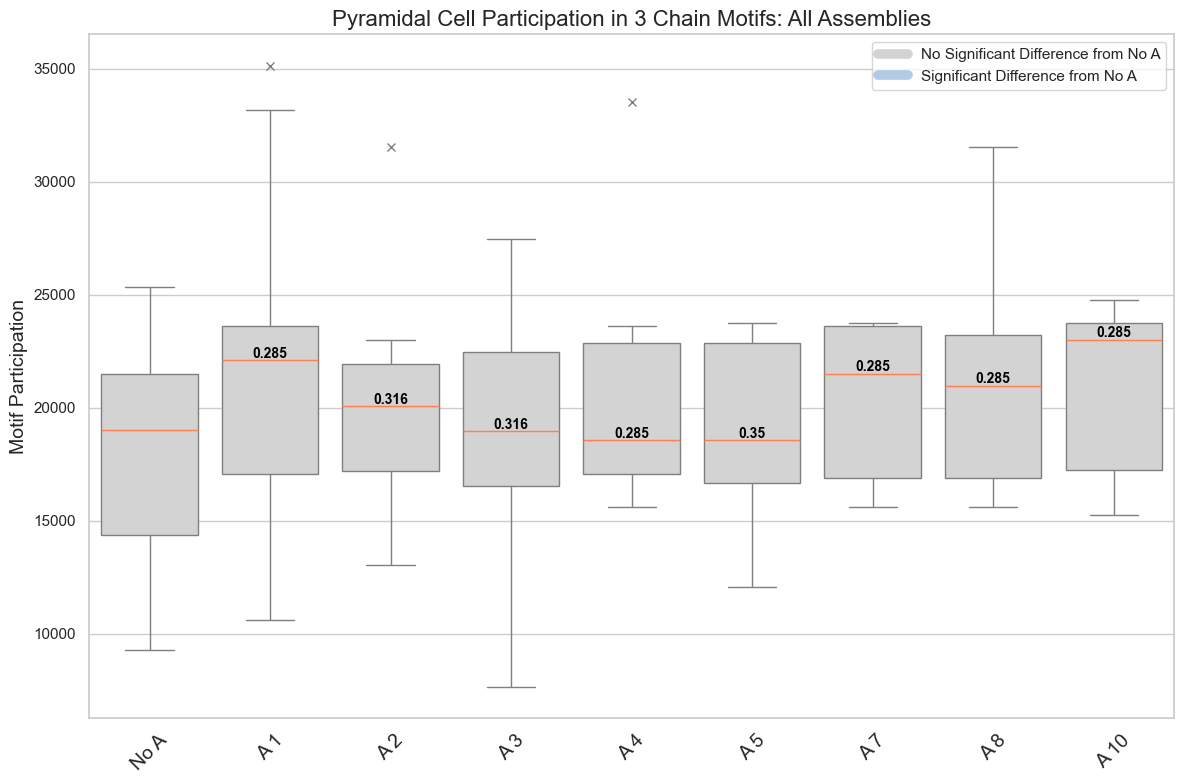

Rank-Sum Test for All A: 0.16399587359726192
A [17225, 23393, 16374, 20828, 27482, 17062, 17207, 17048, 23615, 19918, 20131, 14157, 22590, 15607, 17088, 31449, 33525, 14567, 15669, 13060, 21945, 16874, 21946, 22744, 15790, 23672, 14985, 15240, 24755, 23006, 31538, 10623, 16342, 23084, 20079, 12522, 12079, 23765, 7637, 35135, 22019, 22103, 33155]
No A [13847, 25336, 19646, 21742, 19608, 24500, 21411, 14024, 18407, 9280, 16332, 14471]
Done


In [37]:
produce_motif_by_assembly_boxplot(three_chain_results_array, 
                                  just_pyramidal=True, 
                                  chain_num = 3,
                                  psd = False, 
                                  show_p_vals = True,
                                  fdr_correction= True)

### Adapt R Package into Python Version: Power Test for Wilcoxon Rank-Sum

Code for original R Package is found at: https://github.com/stamats/MKpower/blob/master/R/simSsizeWilcoxTest.R

Original Author - Matthias Kohl

Original Package - MKpower: Power Analysis and Sample Size Calculation

Attempted to Maintain as much as original code nomenclature as possible. Code Adapted with the Assistance of ChatGPT for package identification.

In [330]:
from scipy.stats import mannwhitneyu, wilcoxon

def sim_ssize_wilcox_test(rx, ry=None, mu=0, sig_level=0.05, power=0.8, 
                          test_type='two-sample', alternative='two-sided',
                          n_min=10, n_max=200, step_size= 5, 
                          iter=10000, BREAK=True, correct=True):
    """
    Perform a Monte-Carlo simulation to determine the empirical sample size 
    required for a Wilcoxon test to achieve a specified power.

    Adapted from original R package by Matthias Kohl: 
    https://github.com/stamats/MKpower/blob/master/R/simSsizeWilcoxTest.R

    Parameters:
    - rx: Function to generate random samples for the first group.
    - ry: Function to generate random samples for the second group (for two-sample test).
    - mu: Hypothesized difference in medians (default is 0).
    - sig_level: Significance level (alpha, default is 0.05).
    - power: Desired power of the test (default is 0.8).
    - test_type: Type of test ('two-sample', 'one-sample', 'paired').
    - alternative: Alternative hypothesis ('two-sided', 'less', 'greater').
    - n_min: Minimum sample size to consider.
    - n_max: Maximum sample size to consider.
    - step_size: Step size for increasing sample size.
    - iter: Number of iterations for the simulation.
    - BREAK: Whether to stop early if desired power is reached.
    - correct: Whether to apply continuity correction.

    Returns:
    - Dictionary with sample sizes and corresponding empirical powers.
    """
    
    # Argument validation
    if not (0 < sig_level < 1):
        raise ValueError("'sig.level' has to be in (0, 1)")
    if not (0 < power < 1):
        raise ValueError("'power' has to be in (0, 1)")
    if not callable(rx):
        raise ValueError("'rx' has to be a function")
    if not isinstance(mu, (int, float)):
        raise ValueError("'mu' has to be a numeric value")
    if not isinstance(n_min, int) or n_min < 1:
        raise ValueError("'n.min' has to be a positive integer")
    if not isinstance(n_max, int) or n_max <= n_min:
        raise ValueError("'n.max' has to be greater than 'n.min'")
    if not isinstance(step_size, int) or step_size <= 0:
        raise ValueError("'step.size' has to be a positive integer")
    if not isinstance(iter, int) or iter < 1:
        raise ValueError("'iter' has to be a positive integer")
    
    # Create a range of sample sizes to test and initialize the array to store empirical power
    ns = np.arange(n_min, n_max + 1, step_size)
    emp_power = np.zeros(len(ns))
    
    if test_type == 'two-sample':
        if ry is None or not callable(ry):
            raise ValueError("'ry' has to be a function for 'two-sample' test type")
        
        # Loop through each sample size
        for i, n in enumerate(tqdm(ns)):
            # Generate sample data for both groups
            random.seed(747)
            data_x = np.array([rx(n) for _ in range(iter)])
            random.seed(747)
            data_y = np.array([ry(n) for _ in range(iter)])
            
            # Perform Wilcoxon rank-sum test for each iteration
            p_values = np.array([mannwhitneyu(data_x[j], data_y[j], alternative=alternative, use_continuity=correct).pvalue for j in range(iter)])
            
            # Calculate empirical power
            emp_power[i] = np.mean(p_values < sig_level)

            # Stop early if desired power is reached
            if emp_power[i] > power and BREAK:
                break
        
        METHOD = "Wilcoxon rank sum test"
    
    elif test_type in ['one-sample', 'paired']:
        # Loop through each sample size
        for i, n in enumerate(tqdm(ns)):
            # Generate sample data for the single group
            random.seed(747)
            data_x = np.array([rx(n) for _ in range(iter)])
            
            # Perform Wilcoxon signed-rank test for each iteration
            p_values = np.array([wilcoxon(data_x[j] - mu, alternative=alternative, correction=correct).pvalue for j in range(iter)])
            
            # Calculate empirical power
            emp_power[i] = np.mean(p_values < sig_level)

            # Stop early if desired power is reached
            if emp_power[i] > power and BREAK:
                break
        
        METHOD = "Wilcoxon signed rank test"
    
    else:
        raise ValueError("Invalid 'type'. Should be 'two-sample', 'one-sample', or 'paired'")
    
    # Replace zeros with NaNs in empirical power array
    emp_power[emp_power == 0] = np.nan

    # Filter out any sample sizes with zero power, as well as corresponding power values
    ns = ns[~np.isnan(emp_power)]
    emp_power = emp_power[~np.isnan(emp_power)]
    
    # Compile all results into a dictionary
    result = {
        'n': ns,
        'rx': rx,
        'sig.level': sig_level,
        'emp.power': emp_power,
        'alternative': alternative,
        'method': METHOD,
        'note': "n is number in each group"
    }
    
    if ry is not None:
        result['ry'] = ry
    
    return result

In [331]:
# Example testing (need to define data generating functions)
def rx(n): return np.random.normal(loc=0, scale=1, size=n)
def ry(n): return np.random.normal(loc=0.5, scale=1, size=n)

sim_ssize_wilcox_test(rx, ry=ry, test_type='two-sample', alternative='two-sided')

 31%|███       | 12/39 [00:47<01:45,  3.92s/it]


{'n': array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]),
 'rx': <function __main__.rx(n)>,
 'sig.level': 0.05,
 'emp.power': array([0.1588, 0.2342, 0.3199, 0.3838, 0.4472, 0.5167, 0.5808, 0.6227,
        0.6768, 0.7166, 0.7491, 0.791 , 0.8179]),
 'alternative': 'two-sided',
 'method': 'Wilcoxon rank sum test',
 'note': 'n is number in each group',
 'ry': <function __main__.ry(n)>}

In [332]:
def produce_power_analysis_graph(assembly_sizes, power_analysis_results, empirical_assemblies, order):

    suffix = "First-Order" if order == 1 else f"{order+1}-Chain"
        
    # Sample data: Replace this with your actual data
    df = pd.DataFrame(data = {
        'Assembly_Set': empirical_assemblies,
        'Sample_Size': power_analysis_results,
        'Actual_Sample_Size': assembly_sizes  # Replace with actual sample sizes
    })
    
    # Determine Bar Plot Colors based on Sample Size
    df['Color'] = df.apply(lambda row: 'lightgrey' if row['Sample_Size'] > row['Actual_Sample_Size'] else (.4, .6, .8, .5), axis=1) # type: ignore

    # Create a bar plot with determined Colors
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 8))
    bar_plot = sns.barplot(x='Assembly_Set', y='Actual_Sample_Size', data=df, palette= df['Color'])

    # Add title and labels
    bar_plot.set_title(f'Power Analysis Results: {suffix} Connectivity', fontsize=16)
    bar_plot.set_xlabel('Assemblies', fontsize=14)
    bar_plot.set_ylabel('Assembly Sample Size', fontsize=14)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add horizontal red lines indicating the actual sample size for each assembly
    for index, row in df.iterrows():
        plt.axhline(y=min(row['Sample_Size'], df['Actual_Sample_Size'].max() + 10), color='red', linestyle='-', xmin=index/len(empirical_assemblies), xmax=(index+1)/len(empirical_assemblies))

    # Create legend
    custom_legend = [plt.Line2D([0], [0], color='lightgrey', lw=4, label='Required Sample Size > Actual'),
                    plt.Line2D([0], [0], color=(.4, .6, .8, .5), lw=4, label='Required Sample Size <= Actual'),
                    plt.Line2D([0], [0], color='red', linestyle='-', lw=3, label='Required Sample Size')]
    plt.legend(handles=custom_legend, loc='best')

    # Ensure y-axis ticks are even integers for aesthetic purposes
    y_ticks = range(0, df['Actual_Sample_Size'].max() + 10, 2)
    plt.yticks(y_ticks)
    plt.tight_layout()
    plt.savefig(f'results/{suffix}_Power_Analsysis_By_Assembly.png', dpi = 1200)
    plt.show()

In [333]:
coregistered_cell_indexes = mappings['assemblies_by_connectome_index'].keys()
no_a_cell_indexes = mappings['connectome_indexes_by_assembly']['No A']

# Get chain participation
chain_participation_by_coregistered_cell = {}
for index in tqdm(coregistered_cell_indexes):
    # this only works because the index cannot appear in the same chain more than once
    chain_participation_by_coregistered_cell[index] = np.where(three_chain_results_array == index)[0].size

pooled_assembly_indexes = list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))
individual_assembly_indexes = [mappings['connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]

# Produce Actual Sample Sizes for Power Test
assemblies_by_coregistered = invert_dict(mappings['assemblies_by_connectome_index'])
actual_assembly_sample_sizes = [len(assemblies_by_coregistered[key]) for key in assemblies_by_coregistered.keys() if key != 'No A']

# Pool cells which are not in assemblies
no_a_cell_participation = []
for index in tqdm(no_a_cell_indexes):
    no_a_cell_participation.append(chain_participation_by_coregistered_cell[index])

# Pool individual assembly participation
per_assembly_cell_participation = []
for a in range(len(individual_assembly_indexes)):
    per_assembly_cell_participation.append([])
    for index in tqdm(individual_assembly_indexes[a]):
        per_assembly_cell_participation[a].append(chain_participation_by_coregistered_cell[index])

100%|██████████| 1/1 [00:00<00:00, 5489.93it/s]


In [334]:
from statsmodels.stats.power import tt_ind_solve_power

# parameters for power analysis
nobs1_array = [len(individual_assembly_indexes[i]) for i in range(len(individual_assembly_indexes))]
mean_no_a = np.mean(no_a_cell_participation)
mean_diff_by_difference = [np.mean(per_assembly_cell_participation[a]) - mean_no_a for a in range(len(per_assembly_cell_participation))]
alpha = 0.05
t_test_power_analysis_sample_sizes = []
wilcox_test_power_analysis_sample_sizes = []
actual_assembly_sample_sizes = []
empirical_assemblies = []
# perform power analysis
for a, n in enumerate(nobs1_array):
    if n < 5:
        print(f"No Empirical Testing Performed. Assembly {a+1} has less than 5 coregistered cells.")
        continue
    actual_assembly_sample_sizes.append(len(per_assembly_cell_participation[a]))
    empirical_assemblies.append(f"A {a + 1}")
    effect = mean_diff_by_difference[a] / np.std(per_assembly_cell_participation[a])
    r =  np.sum(nobs1_array) / n
    result = tt_ind_solve_power(effect_size = effect, nobs1 = None, alpha = alpha, power = 0.70,  ratio = r)
    t_test_power_analysis_sample_sizes.append(int(result))
    print(f'T-test: Sample Size for Assembly {a + 1}: %.3f' % result)

    # Need to define data generating functions for each assembly
    random.seed(747)
    def rx(n): return np.array(random.choices(per_assembly_cell_participation[a], k=n))
    def ry(n): return np.array(random.choices(no_a_cell_participation, k=n))

    wilcox_result = sim_ssize_wilcox_test(rx, ry, mu = 0, power = 0.70, n_min = 5, 
                          step_size= 1, test_type='two-sample', alternative='greater')
    print(f'Wilcox: Sample Size for Assembly {a + 1}: %.3f' % wilcox_result['n'][-1])
    wilcox_test_power_analysis_sample_sizes.append(wilcox_result['n'][-1])

T-test: Sample Size for Assembly 1: 21.586


  8%|▊         | 16/196 [00:56<10:32,  3.51s/it]


Wilcox: Sample Size for Assembly 1: 21.000
T-test: Sample Size for Assembly 2: 50.935


 56%|█████▌    | 110/196 [06:39<05:12,  3.64s/it]


Wilcox: Sample Size for Assembly 2: 115.000
T-test: Sample Size for Assembly 3: 349.753


 59%|█████▉    | 116/196 [07:02<04:51,  3.64s/it]


Wilcox: Sample Size for Assembly 3: 121.000
T-test: Sample Size for Assembly 4: 33.391


 26%|██▌       | 51/196 [02:53<08:11,  3.39s/it]


Wilcox: Sample Size for Assembly 4: 56.000
T-test: Sample Size for Assembly 5: 177.419


100%|██████████| 196/196 [13:00<00:00,  3.98s/it]


Wilcox: Sample Size for Assembly 5: 200.000
No Empirical Testing Performed. Assembly 6 has less than 5 coregistered cells.
T-test: Sample Size for Assembly 7: 16.383


 14%|█▍        | 28/196 [01:34<09:28,  3.38s/it]


Wilcox: Sample Size for Assembly 7: 33.000
T-test: Sample Size for Assembly 8: 18.824


  9%|▉         | 18/196 [01:01<10:08,  3.42s/it]


Wilcox: Sample Size for Assembly 8: 23.000
No Empirical Testing Performed. Assembly 9 has less than 5 coregistered cells.
T-test: Sample Size for Assembly 10: 14.377


 12%|█▏        | 24/196 [01:21<09:43,  3.39s/it]

Wilcox: Sample Size for Assembly 10: 29.000
No Empirical Testing Performed. Assembly 11 has less than 5 coregistered cells.
No Empirical Testing Performed. Assembly 12 has less than 5 coregistered cells.
No Empirical Testing Performed. Assembly 13 has less than 5 coregistered cells.
No Empirical Testing Performed. Assembly 14 has less than 5 coregistered cells.
No Empirical Testing Performed. Assembly 15 has less than 5 coregistered cells.


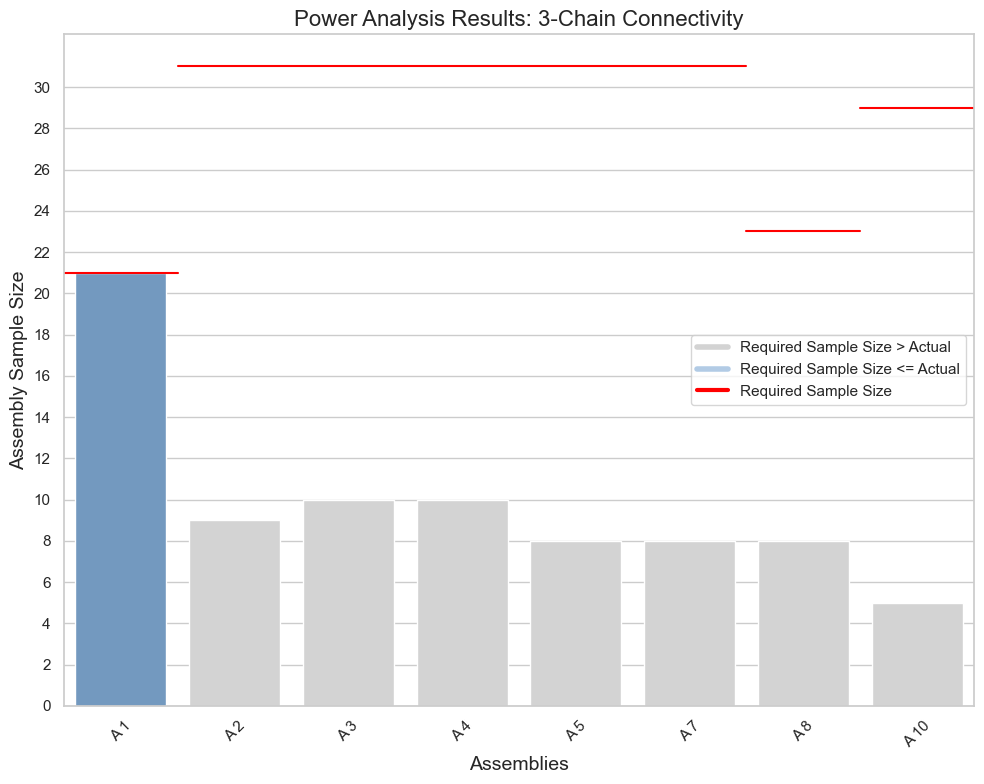

In [335]:
produce_power_analysis_graph(actual_assembly_sample_sizes, wilcox_test_power_analysis_sample_sizes, empirical_assemblies, order = 2)

In [338]:
from statsmodels.stats.power import tt_ind_solve_power

# parameters for power analysis
nobs1_array = [len(individual_assembly_indexes[i]) for i in range(len(individual_assembly_indexes))]
mean_no_a = np.mean(first_order_connections['No A'])
mean_diff_by_difference = [np.mean(first_order_connections[a]) - mean_no_a for a in first_order_connections.keys() if a != 'No A']
alpha = 0.05
first_order_t_test_power_analysis_sample_sizes = []
first_order_wilcox_test_power_analysis_sample_sizes = []
first_order_actual_assembly_sample_sizes = []
first_order_empirical_assemblies = []
# perform power analysis
for a, n in enumerate(nobs1_array):
    if n < 5:
        print(f"No Empirical Testing Performed. Assembly {a+1} has less than 5 coregistered cells.")
        continue
    first_order_actual_assembly_sample_sizes.append(len(first_order_connections[f"A {a+1}"]))
    first_order_empirical_assemblies.append(f"A {a + 1}")
    effect = mean_diff_by_difference[a] / np.std(first_order_connections[f"A {a+1}"])
    r =  np.sum(nobs1_array) / n
    result = tt_ind_solve_power(effect_size = effect, nobs1 = None, alpha = alpha, power = 0.70,  ratio = r)
    first_order_t_test_power_analysis_sample_sizes.append(int(result))
    print(f'T-test: Sample Size for Assembly {a + 1}: %.3f' % result)

    # Need to define data generating functions for each assembly
    random.seed(747)
    def rx(n): return np.array(random.choices(first_order_connections[f"A {a+1}"], k=n))
    def ry(n): return np.array(random.choices(first_order_connections['No A'], k=n))

    wilcox_result = sim_ssize_wilcox_test(rx, ry, mu = 0, power = 0.70, n_min = 4, 
                          step_size= 1, test_type='two-sample', alternative='greater')
    print(f'Wilcox: Sample Size for Assembly {a + 1}: %.3f' % wilcox_result['n'][-1])
    first_order_wilcox_test_power_analysis_sample_sizes.append(wilcox_result['n'][-1])

T-test: Sample Size for Assembly 1: 24.440


 13%|█▎        | 26/197 [01:33<10:14,  3.59s/it]


Wilcox: Sample Size for Assembly 1: 30.000
T-test: Sample Size for Assembly 2: 1376.154


 26%|██▋       | 52/197 [03:09<08:47,  3.64s/it]


Wilcox: Sample Size for Assembly 2: 56.000
T-test: Sample Size for Assembly 3: 3.194


100%|██████████| 197/197 [13:50<00:00,  4.22s/it]


Wilcox: Sample Size for Assembly 3: 196.000
T-test: Sample Size for Assembly 4: 74.104


  6%|▌         | 11/197 [00:43<12:11,  3.93s/it]


Wilcox: Sample Size for Assembly 4: 15.000
T-test: Sample Size for Assembly 5: 8.938


 29%|██▉       | 57/197 [03:27<08:29,  3.64s/it]


Wilcox: Sample Size for Assembly 5: 61.000
No Empirical Testing Performed. Assembly 6 has less than 5 coregistered cells.
T-test: Sample Size for Assembly 7: 2.492


  4%|▍         | 8/197 [00:32<12:47,  4.06s/it]


Wilcox: Sample Size for Assembly 7: 12.000
T-test: Sample Size for Assembly 8: 18.905


  4%|▎         | 7/197 [00:28<13:05,  4.13s/it]


Wilcox: Sample Size for Assembly 8: 11.000
No Empirical Testing Performed. Assembly 9 has less than 5 coregistered cells.
T-test: Sample Size for Assembly 10: 2.379


  1%|          | 1/197 [00:07<24:31,  7.51s/it]

Wilcox: Sample Size for Assembly 10: 5.000
No Empirical Testing Performed. Assembly 11 has less than 5 coregistered cells.
No Empirical Testing Performed. Assembly 12 has less than 5 coregistered cells.
No Empirical Testing Performed. Assembly 13 has less than 5 coregistered cells.
No Empirical Testing Performed. Assembly 14 has less than 5 coregistered cells.
No Empirical Testing Performed. Assembly 15 has less than 5 coregistered cells.


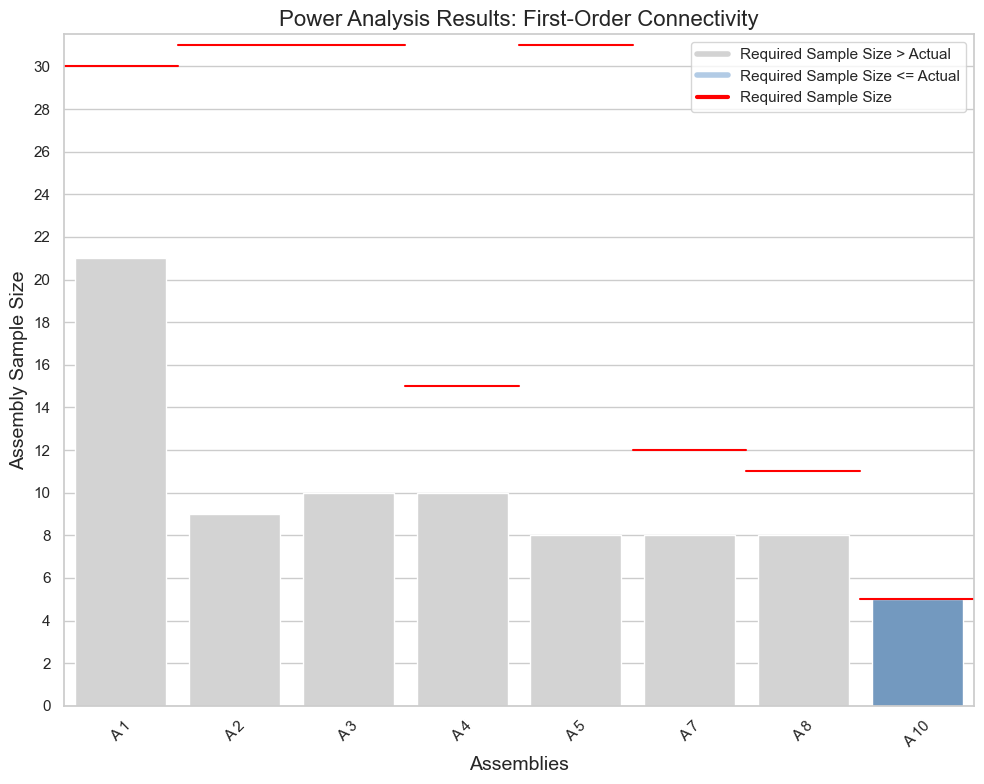

In [339]:
produce_power_analysis_graph(first_order_actual_assembly_sample_sizes, first_order_wilcox_test_power_analysis_sample_sizes, first_order_empirical_assemblies, order = 1)